# Problem 4
Collaborated with Atul Balaji ab5246

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
from torch.autograd import Variable

__all__ = ['resnet18', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet50']

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def resnet18():
    # return torchvision.models.resnet18()
    return ResNet(BasicBlock, [3,3,2])

def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


def resnet32():
    return ResNet(BasicBlock, [5, 5, 5])


def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])


def resnet56():
    return ResNet(BasicBlock, [9, 9, 9])

def resnet50():
    return ResNet(BasicBlock, [8, 8, 8])

def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))



for net_name in __all__:
    if net_name.startswith('resnet'):
        print(net_name)
        test(globals()[net_name]())
        print()


resnet18
Total number of params 195738
Total layers 18

resnet20
Total number of params 269722
Total layers 20

resnet32
Total number of params 464154
Total layers 32

resnet44
Total number of params 658586
Total layers 44

resnet56
Total number of params 853018
Total layers 56

resnet50
Total number of params 755802
Total layers 50



In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Files already downloaded and verified
Files already downloaded and verified


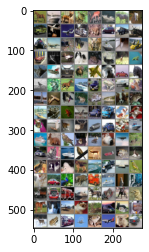

horse  ship   dog  frog  deer  ship horse   dog truck plane plane truck  frog   car truck plane   car plane   cat   dog  deer  ship   cat   car   car   cat  deer   dog  frog  deer  deer  frog plane plane truck  deer plane horse   car horse  bird  frog horse  ship   car  frog plane   cat  ship plane   cat  frog truck  ship   dog  frog  ship  frog  frog  bird   car truck   dog   dog   dog  ship   cat  deer truck   car horse  ship  ship  deer  bird   cat  deer   cat plane  deer   car   dog  ship  bird  deer  ship  frog   dog   cat   dog   dog   dog  ship truck  ship  bird   cat   car  bird   dog truck  ship   cat truck truck   car truck  ship horse   cat   dog  bird horse   cat plane   cat  deer   car   cat truck  deer  frog truck plane  frog plane   dog   car


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [6]:
import time
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = resnet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
losses1 = []
for epoch in range(350):  # loop over the dataset multiple times
    s = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
#         print(i)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losses1.append(loss.item())
        if i % 50 == 49:    # print every 2000 mini-batches
            print((epoch + 1, time.time()-s, running_loss/49))
            running_loss = 0.0
    print('epoch time',time.time()-s)
print('Finished Training')

cuda:0


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(1, 2.1495535373687744, 2.8381733553750172)
(1, 4.210208892822266, 2.125795678216584)
(1, 6.255748987197876, 2.040811799010452)
(1, 8.298354625701904, 1.948969724226971)
(1, 10.338218688964844, 1.897018593184802)
(1, 12.365524291992188, 1.8482384316775264)
(1, 14.417545318603516, 1.8085997104644775)
epoch time 16.130515575408936


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(2, 2.265064001083374, 1.746986445115537)
(2, 4.330906391143799, 1.7163940887061917)
(2, 6.4036242961883545, 1.697037361106094)
(2, 8.478894472122192, 1.6852495913602867)
(2, 10.55160140991211, 1.6672575011545299)
(2, 12.603638172149658, 1.6712529707928092)
(2, 14.66688585281372, 1.6539825006407134)
epoch time 16.327837228775024


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(3, 2.1596646308898926, 1.6225977819793078)
(3, 4.207671880722046, 1.6015306954481163)
(3, 6.227067708969116, 1.5677687148658597)
(3, 8.251033067703247, 1.570545804743864)
(3, 10.25170612335205, 1.5613899839167693)
(3, 12.263693571090698, 1.5653117822141063)
(3, 14.274972438812256, 1.5288603816713606)
epoch time 15.957601308822632


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(4, 2.1637701988220215, 1.4943063745693284)
(4, 4.261988401412964, 1.5060012924427888)
(4, 6.314006328582764, 1.5011884825570243)
(4, 8.361654043197632, 1.480173023379579)
(4, 10.381258487701416, 1.5064755970117998)
(4, 12.413990497589111, 1.4733659272291222)
(4, 14.489996671676636, 1.4791510056476205)
epoch time 16.205044746398926


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(5, 2.1968352794647217, 1.4316342460865876)
(5, 4.240636348724365, 1.434558131256882)
(5, 6.332839727401733, 1.4325446352666737)
(5, 8.385016202926636, 1.4464443995028127)
(5, 10.452836275100708, 1.4069142390270621)
(5, 12.528724431991577, 1.4221212669294707)
(5, 14.592170715332031, 1.4029577727220497)
epoch time 16.259914875030518


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(6, 2.176339626312256, 1.3775382455514402)
(6, 4.260167121887207, 1.368227474543513)
(6, 6.368866682052612, 1.3802901019855423)
(6, 8.444170475006104, 1.3656946128728438)
(6, 10.512859344482422, 1.3609938426893584)
(6, 12.556875467300415, 1.3549079943676383)
(6, 14.660857677459717, 1.359655820593542)
epoch time 16.395129680633545


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(7, 2.2096080780029297, 1.318321943283081)
(7, 4.284937381744385, 1.3223614181791032)
(7, 6.36895751953125, 1.3014491747836678)
(7, 8.464717864990234, 1.3111832166204647)
(7, 10.545567512512207, 1.3273486336883233)
(7, 12.620907306671143, 1.3137175015040807)
(7, 14.685611724853516, 1.318638385558615)
epoch time 16.391684770584106


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(8, 2.185166358947754, 1.2633766446794783)
(8, 4.265115976333618, 1.2653072439894384)
(8, 6.36182165145874, 1.2761231514872338)
(8, 8.48521089553833, 1.273872752578891)
(8, 10.633849143981934, 1.2756637432137314)
(8, 12.769830465316772, 1.2610771753350083)
(8, 14.87951135635376, 1.2666679158502696)
epoch time 16.666170597076416


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(9, 2.2275760173797607, 1.2528442363349759)
(9, 4.315563440322876, 1.2525967018944877)
(9, 6.4148290157318115, 1.2200651740541264)
(9, 8.522873401641846, 1.2147918720634616)
(9, 10.634869575500488, 1.2065721531303562)
(9, 12.742897748947144, 1.2296407198419377)
(9, 14.851577520370483, 1.2184482447955074)
epoch time 16.578474044799805


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(10, 2.2409939765930176, 1.1748693901665357)
(10, 4.392996549606323, 1.1895184966982628)
(10, 6.500974893569946, 1.1784527776192646)
(10, 8.632304430007935, 1.1740754952236099)
(10, 10.733021259307861, 1.1909831081117903)
(10, 12.856989860534668, 1.2016964372323484)
(10, 14.974830865859985, 1.1742968352473513)
epoch time 16.68445086479187


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(11, 2.220482349395752, 1.1451972735171416)
(11, 4.339802503585815, 1.1558065949654093)
(11, 6.412229299545288, 1.1389774509838648)
(11, 8.48824429512024, 1.1453308049513369)
(11, 10.611890077590942, 1.1384633852511037)
(11, 12.711706399917603, 1.1408380744408588)
(11, 14.823773384094238, 1.14692863517878)
epoch time 16.555249214172363


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(12, 2.2044777870178223, 1.1218471539263823)
(12, 4.329121828079224, 1.1112458036870372)
(12, 6.453130483627319, 1.1064375565976512)
(12, 8.576460838317871, 1.0991657023527184)
(12, 10.708473682403564, 1.0943950949882975)
(12, 12.804515838623047, 1.1060114064995124)
(12, 14.923512697219849, 1.116510200257204)
epoch time 16.68729877471924


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(13, 2.2490427494049072, 1.0747752931653236)
(13, 4.397733688354492, 1.0634986223006735)
(13, 6.488997459411621, 1.0663478544780187)
(13, 8.597743511199951, 1.068712127451994)
(13, 10.693718671798706, 1.0849935838154383)
(13, 12.801060676574707, 1.0684658094328277)
(13, 14.909546375274658, 1.0802752801350184)
epoch time 16.6348659992218


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(14, 2.258755683898926, 1.073290652158309)
(14, 4.40678596496582, 1.0394336532573312)
(14, 6.545650482177734, 1.0576361210978762)
(14, 8.682624578475952, 1.0420197029503024)
(14, 10.826772689819336, 1.0389400927387937)
(14, 12.967995405197144, 1.0234925138707063)
(14, 15.108474493026733, 1.0304548776879603)
epoch time 16.869457721710205


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(15, 2.250760793685913, 1.008237630737071)
(15, 4.336967706680298, 1.021127934358558)
(15, 6.421195983886719, 1.0275166204997472)
(15, 8.477221488952637, 1.020458576630573)
(15, 10.505210638046265, 0.9984480349385009)
(15, 12.56120228767395, 1.0145110378460007)
(15, 14.617193222045898, 1.0313331265838779)
epoch time 16.30294632911682


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(16, 2.1661689281463623, 0.9804469651105453)
(16, 4.306180000305176, 0.9710802630502351)
(16, 6.505537509918213, 1.0136188220004647)
(16, 8.526064157485962, 1.011231473514012)
(16, 10.5941743850708, 0.9722150661507432)
(16, 12.625515460968018, 0.9859622120857239)
(16, 14.68220567703247, 1.008170489145785)
epoch time 16.373035430908203


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(17, 2.1770260334014893, 0.9660616711694368)
(17, 4.21233344078064, 0.9884773395499404)
(17, 6.224302291870117, 0.9702033485685077)
(17, 8.252379417419434, 0.9539567694372061)
(17, 10.284897565841675, 0.9655399030568649)
(17, 12.349050283432007, 0.9623041165118315)
(17, 14.372595071792603, 0.9577140552656991)
epoch time 16.03463864326477


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(18, 2.141693592071533, 0.9510903711221657)
(18, 4.294292688369751, 0.947902012844475)
(18, 6.344696044921875, 0.965522361044981)
(18, 8.38163948059082, 0.9172526452006126)
(18, 10.434298276901245, 0.9174752247576811)
(18, 12.485580444335938, 0.9479639882944069)
(18, 14.514316082000732, 0.9427110954206817)
epoch time 16.168898344039917


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(19, 2.1297786235809326, 0.9265005625024134)
(19, 4.160885572433472, 0.9145462926553221)
(19, 6.197313547134399, 0.9155760249313043)
(19, 8.264596939086914, 0.9378575196071547)
(19, 10.316652297973633, 0.936729904340238)
(19, 12.380596160888672, 0.9298421679710855)
(19, 14.448736190795898, 0.9103074219762063)
epoch time 16.126633882522583


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(20, 2.1858086585998535, 0.8976740691126609)
(20, 4.298592805862427, 0.8847200627229652)
(20, 6.3581812381744385, 0.8982762852493598)
(20, 8.3946053981781, 0.8971375896006214)
(20, 10.454336881637573, 0.9208837042049486)
(20, 12.522579193115234, 0.9020172150767579)
(20, 14.5745689868927, 0.9192753592315985)
epoch time 16.295053243637085


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(21, 2.2551567554473877, 0.8856194140959759)
(21, 4.275393009185791, 0.9051604684518308)
(21, 6.29470419883728, 0.8950124066703173)
(21, 8.335403203964233, 0.8759510918539397)
(21, 10.358699560165405, 0.8846217600666747)
(21, 12.379421710968018, 0.8747755374227252)
(21, 14.411391258239746, 0.8772239174161639)
epoch time 16.069791078567505


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(22, 2.173521041870117, 0.8665911457976516)
(22, 4.261053085327148, 0.8477929672416376)
(22, 6.335739612579346, 0.873314520534204)
(22, 8.377524137496948, 0.874917133730285)
(22, 10.416834115982056, 0.8639865894706882)
(22, 12.47682499885559, 0.8455073140105422)
(22, 14.531326532363892, 0.8764570245937425)
epoch time 16.229493141174316


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(23, 2.1759612560272217, 0.8402942041961514)
(23, 4.211263179779053, 0.8170950205958619)
(23, 6.255952835083008, 0.8403278881189774)
(23, 8.247928619384766, 0.8527705438283025)
(23, 10.307957887649536, 0.8365529508006816)
(23, 12.303266763687134, 0.8702971095941505)
(23, 14.319270133972168, 0.8652877296720233)
epoch time 15.993543148040771


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(24, 2.1463065147399902, 0.8286307539258685)
(24, 4.165773868560791, 0.8425089814225022)
(24, 6.258294582366943, 0.7996355818242443)
(24, 8.289604187011719, 0.8403864661041571)
(24, 10.358299970626831, 0.8303119540214539)
(24, 12.442298889160156, 0.8225255754529214)
(24, 14.494278907775879, 0.8529277675005854)
epoch time 16.163724899291992


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(25, 2.1650640964508057, 0.820262863927958)
(25, 4.209753513336182, 0.794603021777406)
(25, 6.2544591426849365, 0.806147957334713)
(25, 8.297809839248657, 0.799906143120357)
(25, 10.32178544998169, 0.8319501791681562)
(25, 12.350457906723022, 0.8365072778293065)
(25, 14.434029340744019, 0.8255343668314875)
epoch time 16.134875059127808


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(26, 2.122769594192505, 0.784603899838973)
(26, 4.146767854690552, 0.7867782310563691)
(26, 6.214818954467773, 0.8100212447497309)
(26, 8.274895191192627, 0.7957869026125693)
(26, 10.263504981994629, 0.802510890425468)
(26, 12.27549958229065, 0.8015134675162179)
(26, 14.27954363822937, 0.815946597225812)
epoch time 15.949531316757202


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(27, 2.153137445449829, 0.7790521577912934)
(27, 4.181139230728149, 0.7728040923877638)
(27, 6.225268363952637, 0.7745329859305401)
(27, 8.229206085205078, 0.786921214084236)
(27, 10.229186534881592, 0.7896894289522755)
(27, 12.249870777130127, 0.795223382054543)
(27, 14.244068622589111, 0.7751686950119174)
epoch time 15.909886121749878


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(28, 2.127143383026123, 0.7665709476081692)
(28, 4.075206756591797, 0.7767531129778648)
(28, 6.071387529373169, 0.766303822702291)
(28, 8.171218156814575, 0.7798474455366329)
(28, 10.175858974456787, 0.7630164379976234)
(28, 12.199105024337769, 0.7710232722515963)
(28, 14.211180448532104, 0.7741922127957247)
epoch time 15.897305727005005


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(29, 2.1458189487457275, 0.773660553961384)
(29, 4.146978139877319, 0.7517743122820951)
(29, 6.179149150848389, 0.7480474418523361)
(29, 8.233967065811157, 0.7311222504596321)
(29, 10.24626088142395, 0.7509458575929914)
(29, 12.27846074104309, 0.7479356612477984)
(29, 14.298479318618774, 0.7738530380385262)
epoch time 15.957378387451172


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(30, 2.1491477489471436, 0.7391684347269486)
(30, 4.156893014907837, 0.7309042568109474)
(30, 6.188991069793701, 0.7273552764435204)
(30, 8.24901270866394, 0.7314496149822157)
(30, 10.320337772369385, 0.7439640346838503)
(30, 12.392075538635254, 0.7364812323025295)
(30, 14.47298812866211, 0.7335905055610501)
epoch time 16.155680179595947


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(31, 2.1726181507110596, 0.71346771230503)
(31, 4.21688175201416, 0.717202573406453)
(31, 6.292552947998047, 0.7226377901982288)
(31, 8.336546659469604, 0.7219864519274964)
(31, 10.393690824508667, 0.732215593055803)
(31, 12.4190194606781, 0.7365010563208132)
(31, 14.436590194702148, 0.7136391468194067)
epoch time 16.101691246032715


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(32, 2.1228625774383545, 0.685985051855749)
(32, 4.1587278842926025, 0.7047762955938067)
(32, 6.211438179016113, 0.7040554893260099)
(32, 8.263512134552002, 0.73015004761365)
(32, 10.327467441558838, 0.7236924499881511)
(32, 12.411458969116211, 0.7152783481442199)
(32, 14.45479702949524, 0.6981548441916096)
epoch time 16.146218061447144


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(33, 2.1403932571411133, 0.6928689041916205)
(33, 4.180542230606079, 0.6986337547399559)
(33, 6.233131647109985, 0.6895605289206213)
(33, 8.257126331329346, 0.7012896866214519)
(33, 10.273125886917114, 0.6978179994894533)
(33, 12.324923038482666, 0.6843669603065569)
(33, 14.34053349494934, 0.7049251612351866)
epoch time 15.990843296051025


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(34, 2.129401683807373, 0.6768869660338577)
(34, 4.154071569442749, 0.6785392347647219)
(34, 6.159050464630127, 0.6607147917455557)
(34, 8.21008849143982, 0.6820504896494807)
(34, 10.273454189300537, 0.6847180249739666)
(34, 12.397403240203857, 0.6874845100908863)
(34, 14.45395278930664, 0.6719504199465927)
epoch time 16.14906930923462


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(35, 2.1362621784210205, 0.6572645166698767)
(35, 4.1482648849487305, 0.6744616068139369)
(35, 6.156905174255371, 0.6631090324752185)
(35, 8.112908363342285, 0.6629688277536508)
(35, 10.116241455078125, 0.6630128573398201)
(35, 12.10820460319519, 0.6809163665284916)
(35, 14.13226318359375, 0.678196162593608)
epoch time 15.751636505126953


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(36, 2.096640110015869, 0.6489045182052924)
(36, 4.1007585525512695, 0.6494831710445638)
(36, 6.105182886123657, 0.6608618582998004)
(36, 8.10517406463623, 0.664177417755127)
(36, 10.117220163345337, 0.6607738392693656)
(36, 12.156503677368164, 0.6520082628240391)
(36, 14.213200807571411, 0.6507832772877752)
epoch time 15.87015438079834


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(37, 2.182239532470703, 0.619460220847811)
(37, 4.2145092487335205, 0.6367416400082258)
(37, 6.2222723960876465, 0.6203657139320763)
(37, 8.226512908935547, 0.633619277452936)
(37, 10.274925470352173, 0.6478424485848875)
(37, 12.298941135406494, 0.6456713627795784)
(37, 14.314925909042358, 0.6625035545047449)
epoch time 16.01611351966858


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(38, 2.142735719680786, 0.6117308875735925)
(38, 4.218733310699463, 0.6062320902639505)
(38, 6.21073579788208, 0.6387029077325549)
(38, 8.214718580245972, 0.6111591470484831)
(38, 10.242073774337769, 0.6367431812140406)
(38, 12.306073904037476, 0.6237499355053415)
(38, 14.386718273162842, 0.6351951129582464)
epoch time 16.062231063842773


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(39, 2.104299306869507, 0.6036022457541251)
(39, 4.1196372509002686, 0.6322141599898435)
(39, 6.131708860397339, 0.5967819094657898)
(39, 8.140272617340088, 0.6023756113587594)
(39, 10.164390087127686, 0.6222475122432319)
(39, 12.184434175491333, 0.6123801591444988)
(39, 14.191670179367065, 0.6188745346604562)
epoch time 15.846542596817017


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(40, 2.1331028938293457, 0.5916340801180625)
(40, 4.16977858543396, 0.5947510782553225)
(40, 6.197094678878784, 0.6105624248786848)
(40, 8.20974850654602, 0.6037874994229298)
(40, 10.205753326416016, 0.609342914454791)
(40, 12.221081018447876, 0.5902763453065133)
(40, 14.265111207962036, 0.5934936045383921)
epoch time 15.946377754211426


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(41, 2.102616548538208, 0.5584342808139567)
(41, 4.082626581192017, 0.5606466969665216)
(41, 6.098514080047607, 0.5808931400581282)
(41, 8.074623346328735, 0.5867279105040492)
(41, 10.074564933776855, 0.5929641966917076)
(41, 12.070672035217285, 0.6152179490546791)
(41, 14.106696605682373, 0.6095469101351134)
epoch time 15.788113355636597


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(42, 2.1790966987609863, 0.5487073301052561)
(42, 4.22309422492981, 0.5761383267081513)
(42, 6.2667200565338135, 0.5622961016333833)
(42, 8.30289888381958, 0.5643720937018492)
(42, 10.338343620300293, 0.5699636930105637)
(42, 12.37848973274231, 0.5839714967474645)
(42, 14.586402416229248, 0.5869053249456444)
epoch time 16.32769775390625


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(43, 2.178610324859619, 0.5503608925001962)
(43, 4.230608224868774, 0.5336814163898935)
(43, 6.267289876937866, 0.551803953793584)
(43, 8.331312894821167, 0.5758312752052229)
(43, 10.366788148880005, 0.564027796594464)
(43, 12.394667863845825, 0.5528071273346337)
(43, 14.443325757980347, 0.5681149296614588)
epoch time 16.165430068969727


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(44, 2.141036033630371, 0.522491957460131)
(44, 4.177120685577393, 0.5366977155208588)
(44, 6.233773231506348, 0.5363062504602938)
(44, 8.301778078079224, 0.5430174293566723)
(44, 10.373770475387573, 0.5586932988799348)
(44, 12.421122074127197, 0.5397423809888412)
(44, 14.461777687072754, 0.5586943413530078)
epoch time 16.185784101486206


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(45, 2.211195945739746, 0.5111354121140071)
(45, 4.255899429321289, 0.5141377005041862)
(45, 6.335886240005493, 0.5451143797563047)
(45, 8.387782096862793, 0.5340120907948942)
(45, 10.411301851272583, 0.5443814323872936)
(45, 12.491304636001587, 0.5497668981552124)
(45, 14.55116057395935, 0.5285770120669384)
epoch time 16.202921152114868


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(46, 2.136225700378418, 0.4881020206577924)
(46, 4.164576530456543, 0.5159842542239598)
(46, 6.1968700885772705, 0.5072476699644205)
(46, 8.256209135055542, 0.5308208806174142)
(46, 10.284238338470459, 0.5368300761495318)
(46, 12.288482427597046, 0.5204262435436249)
(46, 14.318670272827148, 0.5412018773507099)
epoch time 16.00338101387024


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(47, 2.153397798538208, 0.47858856648814924)
(47, 4.157416105270386, 0.4935639719573819)
(47, 6.181430339813232, 0.494826828338662)
(47, 8.201821565628052, 0.5177432487205583)
(47, 10.21742844581604, 0.5117058285645076)
(47, 12.284696340560913, 0.5163763725027746)
(47, 14.305397987365723, 0.5203860018934522)
epoch time 15.96428918838501


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(48, 2.1363277435302734, 0.47835375155721394)
(48, 4.1755194664001465, 0.48716630558578333)
(48, 6.229017496109009, 0.48360936191617226)
(48, 8.264381647109985, 0.4795512569193937)
(48, 10.284350872039795, 0.5018222563120783)
(48, 12.280436754226685, 0.49692911943610835)
(48, 14.30501914024353, 0.49498896574487494)
epoch time 15.96224856376648


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(49, 2.23868989944458, 0.4550595946457921)
(49, 4.326467752456665, 0.47655581150736126)
(49, 6.40270471572876, 0.482977778935919)
(49, 8.465951681137085, 0.48357936314174105)
(49, 10.54197883605957, 0.483532220733409)
(49, 12.594107389450073, 0.4772967246113991)
(49, 14.642673969268799, 0.48342245756363383)
epoch time 16.32862401008606


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(50, 2.177260398864746, 0.4292024489568204)
(50, 4.233339548110962, 0.4436977335384914)
(50, 6.277360677719116, 0.4705585709639958)
(50, 8.281312704086304, 0.4713986540327267)
(50, 10.277959823608398, 0.4648359052988948)
(50, 12.30931043624878, 0.49000170644448726)
(50, 14.337998151779175, 0.4644287940190763)
epoch time 15.988759756088257


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(51, 2.1429781913757324, 0.43942043246055135)
(51, 4.189129114151001, 0.44825369302107365)
(51, 6.252484321594238, 0.4471646091159509)
(51, 8.321119785308838, 0.4417481741734913)
(51, 10.356447696685791, 0.4353243234206219)
(51, 12.412406206130981, 0.4706291313074073)
(51, 14.500572204589844, 0.4720650503830034)
epoch time 16.196062326431274


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(52, 2.164315938949585, 0.43266086189114317)
(52, 4.248730182647705, 0.42125317271874874)
(52, 6.260981321334839, 0.4449832104906744)
(52, 8.284986734390259, 0.429116892571352)
(52, 10.333491325378418, 0.45763338646110224)
(52, 12.372981071472168, 0.44023523464494824)
(52, 14.429013729095459, 0.46040887552864695)
epoch time 16.09570598602295


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(53, 2.169163465499878, 0.413317045691062)
(53, 4.287146329879761, 0.4043391541558869)
(53, 6.3006675243377686, 0.4259084669911132)
(53, 8.31697940826416, 0.4187049154116183)
(53, 10.329197883605957, 0.44187224762780325)
(53, 12.424694538116455, 0.43112457893332656)
(53, 14.440463542938232, 0.4412226579627212)
epoch time 16.07794427871704


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(54, 2.119140386581421, 0.38257719059379736)
(54, 4.114411354064941, 0.40106262783614954)
(54, 6.077561855316162, 0.40150495816250237)
(54, 8.042494058609009, 0.423192808214499)
(54, 10.038453102111816, 0.42779292439927863)
(54, 12.026438236236572, 0.42628118152521094)
(54, 14.026365756988525, 0.4316766541831347)
epoch time 15.662909507751465


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(55, 2.123368501663208, 0.38465394748716936)
(55, 4.175354480743408, 0.3949175026952004)
(55, 6.224107027053833, 0.4105590490662322)
(55, 8.227258682250977, 0.4089284593961677)
(55, 10.244792461395264, 0.4064379243218169)
(55, 12.25542688369751, 0.4070256991045816)
(55, 14.298617124557495, 0.41095431970090285)
epoch time 15.957289457321167


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(56, 2.1099891662597656, 0.3926875968368686)
(56, 4.086135625839233, 0.3837939552506622)
(56, 6.10263204574585, 0.3833860517764578)
(56, 8.118667840957642, 0.3925605160849435)
(56, 10.110658884048462, 0.3876274319327607)
(56, 12.114659547805786, 0.3970996232665315)
(56, 14.101980447769165, 0.4129542452948434)
epoch time 15.784846305847168


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(57, 2.1215732097625732, 0.37757343023407214)
(57, 4.117316961288452, 0.3710751186828224)
(57, 6.213001728057861, 0.355806045386256)
(57, 8.27390432357788, 0.3818770549735244)
(57, 10.298918724060059, 0.3779066423980557)
(57, 12.329081296920776, 0.37404909060925856)
(57, 14.337058782577515, 0.39028356087451077)
epoch time 16.00773000717163


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(58, 2.137235164642334, 0.35165587554172595)
(58, 4.141197204589844, 0.3395247170511557)
(58, 6.153467893600464, 0.36276858132712697)
(58, 8.134051084518433, 0.35884816093104227)
(58, 10.137253046035767, 0.3741132315932488)
(58, 12.133878946304321, 0.3700984494418514)
(58, 14.121180295944214, 0.3774674282390244)
epoch time 15.791013717651367


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(59, 2.1221158504486084, 0.3469526430173796)
(59, 4.081081867218018, 0.335180616196321)
(59, 6.106794357299805, 0.34463728477760236)
(59, 8.158776044845581, 0.3587008897139102)
(59, 10.166790962219238, 0.3570344177435856)
(59, 12.218108892440796, 0.3515624714140989)
(59, 14.242067337036133, 0.3640162284885134)
epoch time 15.925559282302856


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(60, 2.1551382541656494, 0.3104013666814687)
(60, 4.192972660064697, 0.33533613748696384)
(60, 6.220481634140015, 0.33305111983600927)
(60, 8.24063491821289, 0.32407367989724994)
(60, 10.261119604110718, 0.3380475214549473)
(60, 12.256421566009521, 0.37081786047439186)
(60, 14.285194158554077, 0.3712569307916018)
epoch time 15.935203313827515


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(61, 2.117147445678711, 0.31646106255297757)
(61, 4.13314962387085, 0.32186331493513926)
(61, 6.121415376663208, 0.32764856456493846)
(61, 8.233222246170044, 0.3167278946054225)
(61, 10.193159818649292, 0.33417037950486556)
(61, 12.201842308044434, 0.3426565038306372)
(61, 14.23393201828003, 0.34029174063886913)
epoch time 15.838388204574585


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(62, 2.13932204246521, 0.29541604129635557)
(62, 4.150911331176758, 0.301844057684042)
(62, 6.178680658340454, 0.30183050583819954)
(62, 8.147321939468384, 0.3214721223529504)
(62, 10.115152835845947, 0.3285540117292988)
(62, 12.131332635879517, 0.3157244869032685)
(62, 14.107338905334473, 0.3236847632393545)
epoch time 15.7809419631958


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(63, 2.0902838706970215, 0.2934462136151839)
(63, 4.085609436035156, 0.29647985191977755)
(63, 6.146010398864746, 0.29103111582142965)
(63, 8.189610242843628, 0.32531089016369413)
(63, 10.23759388923645, 0.3136430005637967)
(63, 12.273624181747437, 0.30111900488941035)
(63, 14.273544788360596, 0.32400366207774806)
epoch time 15.913679361343384


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(64, 2.136411190032959, 0.2948129697113621)
(64, 4.152538776397705, 0.2894170129177522)
(64, 6.179882764816284, 0.2814992797009799)
(64, 8.219849824905396, 0.29876797114099773)
(64, 10.280525207519531, 0.3091012248579337)
(64, 12.315015316009521, 0.30866463269506184)
(64, 14.371853113174438, 0.3126298858194935)
epoch time 16.304534673690796


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(65, 2.159292221069336, 0.251489272531198)
(65, 4.191264390945435, 0.26206905622871557)
(65, 6.219228982925415, 0.2700655618492438)
(65, 8.275890588760376, 0.2864916093495427)
(65, 10.311919689178467, 0.2848498054913112)
(65, 12.339962720870972, 0.28793976014974165)
(65, 14.399924039840698, 0.28884856220410793)
epoch time 16.084770441055298


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(66, 2.1623289585113525, 0.25838929977344005)
(66, 4.197883367538452, 0.2536641800281953)
(66, 6.22678804397583, 0.27111576740839044)
(66, 8.227041721343994, 0.2534516444619821)
(66, 10.226333618164062, 0.2763418178169095)
(66, 12.263030052185059, 0.28674255585183905)
(66, 14.259079694747925, 0.2817624846891481)
epoch time 15.92400336265564


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(67, 2.1590025424957275, 0.2463033582483019)
(67, 4.190193176269531, 0.24663311455930984)
(67, 6.210937261581421, 0.24294714964165978)
(67, 8.210211277008057, 0.24980250092185274)
(67, 10.230936527252197, 0.2663655992673368)
(67, 12.290232181549072, 0.26834893226623535)
(67, 14.374963998794556, 0.2729303201242369)
epoch time 16.03692626953125


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(68, 2.1499197483062744, 0.23186985433709864)
(68, 4.174108982086182, 0.23860127037885237)
(68, 6.237221956253052, 0.24776240605480818)
(68, 8.277226209640503, 0.24208622714694666)
(68, 10.333940982818604, 0.2605091762177798)
(68, 12.355558156967163, 0.25787376931735445)
(68, 14.381568670272827, 0.2579680684269691)
epoch time 16.061105728149414


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(69, 2.1130988597869873, 0.22089415393313583)
(69, 4.164714097976685, 0.2398806427206312)
(69, 6.196364402770996, 0.230460668096737)
(69, 8.24797534942627, 0.24326134944448666)
(69, 10.312016487121582, 0.23342371047759541)
(69, 12.423754453659058, 0.2416029101123615)
(69, 14.512046098709106, 0.2509724616396184)
epoch time 16.2230007648468


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(70, 2.19695782661438, 0.20477831470114843)
(70, 4.2849061489105225, 0.21784745947438844)
(70, 6.33366584777832, 0.22558046603689388)
(70, 8.40894627571106, 0.23146145349862624)
(70, 10.463918209075928, 0.2455027611279974)
(70, 12.50492238998413, 0.23550719113982455)
(70, 14.565613031387329, 0.24704537008489882)
epoch time 16.283171892166138


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(71, 2.193725109100342, 0.20090829352943265)
(71, 4.25387167930603, 0.20916322208180718)
(71, 6.330358505249023, 0.21107121085634037)
(71, 8.39435076713562, 0.203564603109749)
(71, 10.425667762756348, 0.2284440422544674)
(71, 12.517685890197754, 0.22369231587770033)
(71, 14.642618179321289, 0.24238843075474914)
epoch time 16.31085181236267


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(72, 2.1633877754211426, 0.20183637814254177)
(72, 4.210740089416504, 0.18995379063547874)
(72, 6.24672794342041, 0.19530411642424914)
(72, 8.290678024291992, 0.20746577257404522)
(72, 10.311009883880615, 0.21061533583062036)
(72, 12.358716487884521, 0.2182169179527127)
(72, 14.370768547058105, 0.22562881179001867)
epoch time 16.041320085525513


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(73, 2.1299891471862793, 0.1907831827292637)
(73, 4.158005475997925, 0.18490811893526388)
(73, 6.205690622329712, 0.2034265627058185)
(73, 8.253304481506348, 0.20288183068742557)
(73, 10.269989728927612, 0.21373402220862253)
(73, 12.309333562850952, 0.21703550964593887)
(73, 14.378026008605957, 0.21416774635412256)
epoch time 16.080662965774536


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(74, 2.1812245845794678, 0.1870286828097032)
(74, 4.248922348022461, 0.1788038009283494)
(74, 6.353231430053711, 0.1817470156416601)
(74, 8.385257720947266, 0.17615124096675794)
(74, 10.449243783950806, 0.18546199844199784)
(74, 12.50475549697876, 0.20801044878911)
(74, 14.566118001937866, 0.22333085719419984)
epoch time 16.25594186782837


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(75, 2.145209789276123, 0.17289396831575704)
(75, 4.205207347869873, 0.17601264222544066)
(75, 6.261178255081177, 0.17579812465273603)
(75, 8.30066990852356, 0.187806991746231)
(75, 10.369174480438232, 0.19478624861459343)
(75, 12.417201042175293, 0.21341761444904367)
(75, 14.486355543136597, 0.2079838041444214)
epoch time 16.224569082260132


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(76, 2.1925172805786133, 0.15740999472992762)
(76, 4.259767055511475, 0.1776744340147291)
(76, 6.334242582321167, 0.17322239918368204)
(76, 8.423839092254639, 0.17669011743701235)
(76, 10.527865171432495, 0.18782508616544763)
(76, 12.572539329528809, 0.18971828234438992)
(76, 14.607837438583374, 0.18596780315345648)
epoch time 16.279523611068726


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(77, 2.17681622505188, 0.15227205078212583)
(77, 4.212917804718018, 0.15946412755518544)
(77, 6.27293062210083, 0.15877899740423476)
(77, 8.300288438796997, 0.17764983645507268)
(77, 10.352910995483398, 0.18144988131766415)
(77, 12.384923696517944, 0.1920329347556951)
(77, 14.436900854110718, 0.18326935430570523)
epoch time 16.132977962493896


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(78, 2.1751580238342285, 0.1536405300911592)
(78, 4.243812799453735, 0.156552076643827)
(78, 6.307864189147949, 0.1651272527417358)
(78, 8.37913990020752, 0.16841131144640398)
(78, 10.419174671173096, 0.16794434159385915)
(78, 12.483827829360962, 0.16916336651359284)
(78, 14.519118309020996, 0.17655034104780276)
epoch time 16.186636447906494


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(79, 2.145124673843384, 0.15049659384756672)
(79, 4.184751272201538, 0.14323088541931037)
(79, 6.280448913574219, 0.15507933314965697)
(79, 8.336992502212524, 0.15823542858873094)
(79, 10.360426664352417, 0.1620646450592547)
(79, 12.420477867126465, 0.1657719551300516)
(79, 14.46910285949707, 0.17100134309457274)
epoch time 16.219707012176514


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(80, 2.204634666442871, 0.1397138692590655)
(80, 4.2926716804504395, 0.14272314690205515)
(80, 6.3653318881988525, 0.14136128560925015)
(80, 8.421616077423096, 0.15543408874346284)
(80, 10.513332843780518, 0.14221331902912684)
(80, 12.592933893203735, 0.14850286941747276)
(80, 14.652667999267578, 0.15811081078587746)
epoch time 16.342326879501343


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(81, 2.170457601547241, 0.12372809161945265)
(81, 4.234196662902832, 0.13981375584796985)
(81, 6.270230770111084, 0.1376008316874504)
(81, 8.306143999099731, 0.14003313226359232)
(81, 10.342889308929443, 0.14586000418176456)
(81, 12.37409234046936, 0.1481883037759333)
(81, 14.386274814605713, 0.1618099857349785)
epoch time 16.09441351890564


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(82, 2.2637581825256348, 0.13275775206940515)
(82, 4.336390495300293, 0.12147843183911576)
(82, 6.380420207977295, 0.12379794552618144)
(82, 8.39591383934021, 0.14141400067173704)
(82, 10.443758010864258, 0.14403657523953184)
(82, 12.467713117599487, 0.1415342621657313)
(82, 14.480383396148682, 0.1507082251565797)
epoch time 16.14891529083252


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(83, 2.1953847408294678, 0.13291048684290477)
(83, 4.195362091064453, 0.13489886251639346)
(83, 6.215404272079468, 0.1222620752392983)
(83, 8.239377975463867, 0.12903569897218625)
(83, 10.267388820648193, 0.1343261810893915)
(83, 12.270677328109741, 0.1431704663804599)
(83, 14.315369367599487, 0.14785919399285802)
epoch time 15.971404314041138


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(84, 2.1838598251342773, 0.1186626745882083)
(84, 4.219865560531616, 0.12032835641685798)
(84, 6.255864381790161, 0.11889266876541839)
(84, 8.255868911743164, 0.12228845227129605)
(84, 10.295866012573242, 0.12146368729216712)
(84, 12.299867630004883, 0.12827098263161524)
(84, 14.339221239089966, 0.14084643277586723)
epoch time 15.991447687149048


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(85, 2.0760319232940674, 0.11430420315995508)
(85, 4.068325042724609, 0.10890452974304861)
(85, 6.044355630874634, 0.11599740127519685)
(85, 7.996329069137573, 0.11824414711825702)
(85, 9.99164080619812, 0.11967814865769172)
(85, 11.996323585510254, 0.12252156071516933)
(85, 14.024322748184204, 0.12325318332533447)
epoch time 15.662906885147095


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(86, 2.0966055393218994, 0.10662095476778186)
(86, 4.153292894363403, 0.11027224453128114)
(86, 6.148562908172607, 0.10459141159544186)
(86, 8.161293268203735, 0.11039172584305004)
(86, 10.173308372497559, 0.12553232315243507)
(86, 12.189297199249268, 0.12345055916479655)
(86, 14.224578380584717, 0.12390398834736979)
epoch time 15.915529012680054


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(87, 2.108978509902954, 0.09784360648113855)
(87, 4.097671985626221, 0.10278220330269969)
(87, 6.056999683380127, 0.10645836454873182)
(87, 8.03367805480957, 0.11477473598657822)
(87, 10.033666849136353, 0.10955369457298396)
(87, 12.00566291809082, 0.12167905772827109)
(87, 13.976614952087402, 0.11043820659420928)
epoch time 15.587320804595947


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(88, 2.0938289165496826, 0.10817060961711164)
(88, 4.465501308441162, 0.11274483640279089)
(88, 6.518250226974487, 0.1068153299239217)
(88, 8.518253564834595, 0.10724861859058847)
(88, 10.541553974151611, 0.11183167933201303)
(88, 12.589614152908325, 0.11367453170978294)
(88, 14.625594139099121, 0.11244357225238061)
epoch time 16.301836490631104


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(89, 2.1225745677948, 0.09361698372023446)
(89, 4.132326126098633, 0.09308760263481919)
(89, 6.148361444473267, 0.09787868381458886)
(89, 8.163662195205688, 0.11621242396685542)
(89, 10.195857286453247, 0.10713263319767251)
(89, 12.228342771530151, 0.1201626534516714)
(89, 14.236349105834961, 0.1091452852195623)
epoch time 15.910955905914307


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(90, 2.1292834281921387, 0.08884867942150758)
(90, 4.164543628692627, 0.08748433746549548)
(90, 6.305282115936279, 0.10132831259041417)
(90, 8.364610195159912, 0.10077275168530796)
(90, 10.432838201522827, 0.10412049886523461)
(90, 12.492978572845459, 0.1043823942998234)
(90, 14.545324087142944, 0.10762321333191832)
epoch time 16.277710676193237


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(91, 2.179504871368408, 0.08703402376600675)
(91, 4.178823471069336, 0.09052215520368546)
(91, 6.190901756286621, 0.0903303607233933)
(91, 8.179647207260132, 0.09258529308195017)
(91, 10.166791677474976, 0.0854008216791007)
(91, 12.166850328445435, 0.1043395108106185)
(91, 14.150804042816162, 0.09562999869183618)
epoch time 15.777065515518188


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(92, 2.13832426071167, 0.08672874375265471)
(92, 4.1377012729644775, 0.08391903135545399)
(92, 6.1903252601623535, 0.08698139978306633)
(92, 8.174351692199707, 0.08650799498570208)
(92, 10.194330215454102, 0.08980851734475213)
(92, 12.238333463668823, 0.10511821706076058)
(92, 14.281120777130127, 0.09667191137464679)
epoch time 15.916091442108154


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(93, 2.106153964996338, 0.08246827672938911)
(93, 4.146173715591431, 0.07523775914189768)
(93, 6.149345874786377, 0.08182453812689197)
(93, 8.165826320648193, 0.08186051690456819)
(93, 10.186164855957031, 0.08343962754826156)
(93, 12.186175346374512, 0.08147370252682239)
(93, 14.185593605041504, 0.09823338330096128)
epoch time 15.817953824996948


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(94, 2.103442430496216, 0.08633784311158317)
(94, 4.139489412307739, 0.07250814367921984)
(94, 6.228153705596924, 0.0848413732435022)
(94, 8.344123601913452, 0.0904901427577953)
(94, 10.38010573387146, 0.0914300800282128)
(94, 12.399394989013672, 0.09946174220162995)
(94, 14.424131155014038, 0.09761019818940941)
epoch time 16.072277784347534


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(95, 2.166584014892578, 0.08613394999078341)
(95, 4.2043163776397705, 0.06515234807620243)
(95, 6.251736640930176, 0.07550685320581708)
(95, 8.267603874206543, 0.08453582607361736)
(95, 10.259052753448486, 0.07584159311895468)
(95, 12.26284384727478, 0.085074996765779)
(95, 14.307040452957153, 0.08628563065918124)
epoch time 15.991353988647461


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(96, 2.151620864868164, 0.0760723173010106)
(96, 4.1803107261657715, 0.07288100479208694)
(96, 6.192282199859619, 0.08046022597320225)
(96, 8.215737342834473, 0.07030165845490231)
(96, 10.251669645309448, 0.07981609195774915)
(96, 12.268301486968994, 0.0764044458616753)
(96, 14.280086517333984, 0.07723724940905766)
epoch time 15.946253538131714


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(97, 2.203301429748535, 0.06380097792312807)
(97, 4.233960151672363, 0.06582291355850745)
(97, 6.249847173690796, 0.06480781342454102)
(97, 8.273280143737793, 0.0754395673165516)
(97, 10.305954933166504, 0.07477521310959544)
(97, 12.322923183441162, 0.07814578065762715)
(97, 14.349259853363037, 0.08932576047218575)
epoch time 16.002829551696777


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(98, 2.1142876148223877, 0.07147155797147021)
(98, 4.1347815990448, 0.06787937993601877)
(98, 6.149720191955566, 0.06211648881435394)
(98, 8.214372158050537, 0.0644563222874184)
(98, 10.289501428604126, 0.06694899700886132)
(98, 12.32701587677002, 0.07841059295650647)
(98, 14.362998723983765, 0.0745783624600391)
epoch time 16.049248695373535


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(99, 2.1656813621520996, 0.06144770063763978)
(99, 4.209036350250244, 0.05996295083694312)
(99, 6.241697072982788, 0.06579844041594438)
(99, 8.253685712814331, 0.06885555595615689)
(99, 10.305002689361572, 0.07028571493467506)
(99, 12.337719202041626, 0.06589666982086337)
(99, 14.36095929145813, 0.06948220205246186)
epoch time 16.03965473175049


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(100, 2.1579458713531494, 0.061476324285779683)
(100, 4.17392635345459, 0.05783596946572771)
(100, 6.198099136352539, 0.05813905946454223)
(100, 8.22997760772705, 0.06748349287984323)
(100, 10.317928791046143, 0.061004006398879755)
(100, 12.31321406364441, 0.06545208299494519)
(100, 14.317275285720825, 0.06305834263259051)
epoch time 15.977223634719849


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(101, 2.0805797576904297, 0.05367457433318605)
(101, 4.067898988723755, 0.06363934388726342)
(101, 6.091972589492798, 0.060819353338102906)
(101, 8.075940608978271, 0.07082552052274042)
(101, 10.080609560012817, 0.07285176247966532)
(101, 12.099968910217285, 0.06961540322826833)
(101, 14.140642642974854, 0.07505913823843002)
epoch time 15.76889967918396


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(102, 2.0749521255493164, 0.06146912501022524)
(102, 4.103618144989014, 0.05547746856297765)
(102, 6.066985845565796, 0.06413656727848005)
(102, 8.06310248374939, 0.0686068619620435)
(102, 10.058961629867554, 0.08214786728577954)
(102, 12.12696647644043, 0.06828463754179526)
(102, 14.13899278640747, 0.0696176651637165)
epoch time 15.780908823013306


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(103, 2.106417179107666, 0.05595677634891199)
(103, 4.1066272258758545, 0.06532128250264392)
(103, 6.126230239868164, 0.06428530055801479)
(103, 8.154648303985596, 0.05808035147433378)
(103, 10.14596438407898, 0.06521735925759588)
(103, 12.150620460510254, 0.07433804763214928)
(103, 14.153918504714966, 0.06036713384852117)
epoch time 15.794987916946411


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(104, 2.1029648780822754, 0.05722913138416349)
(104, 4.098882436752319, 0.05452264746537014)
(104, 6.067543029785156, 0.061713840318273525)
(104, 8.034941673278809, 0.06898126595330481)
(104, 10.014834880828857, 0.0626153189460842)
(104, 12.018978357315063, 0.06248233132824606)
(104, 14.075548648834229, 0.06200110254695221)
epoch time 15.729243993759155


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(105, 2.1626081466674805, 0.054614542432281435)
(105, 4.201610565185547, 0.05073416597989141)
(105, 6.226226329803467, 0.05709792293456136)
(105, 8.260083198547363, 0.05820711485433335)
(105, 10.293535947799683, 0.05160343057799096)
(105, 12.338212728500366, 0.05775594327370731)
(105, 14.309370994567871, 0.06274570973247898)
epoch time 15.944557428359985


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(106, 2.0889155864715576, 0.055921818376803885)
(106, 4.0218424797058105, 0.055419911117273936)
(106, 5.993563175201416, 0.05273584801019454)
(106, 8.005528211593628, 0.06188286437976117)
(106, 10.021595478057861, 0.05595296651733165)
(106, 11.997565269470215, 0.05978891941509685)
(106, 14.056886911392212, 0.05501205477939577)
epoch time 15.691773414611816


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(107, 2.085176944732666, 0.04677564449304221)
(107, 4.109723806381226, 0.049242112747564605)
(107, 6.101693153381348, 0.054982238468162865)
(107, 8.105046033859253, 0.050981113040933806)
(107, 10.141018629074097, 0.07207607702181047)
(107, 12.169067144393921, 0.058377322645819914)
(107, 14.225038766860962, 0.05797060579061508)
epoch time 15.890995502471924


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(108, 2.1059646606445312, 0.04685884375809407)
(108, 4.113986968994141, 0.04647537358865446)
(108, 6.121973037719727, 0.04928148245172841)
(108, 8.129801034927368, 0.05600383588854147)
(108, 10.154608964920044, 0.051027777205620496)
(108, 12.142664194107056, 0.06202760346385897)
(108, 14.098618745803833, 0.06047553561475812)
epoch time 15.765169382095337


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(109, 2.1373660564422607, 0.045121184721284985)
(109, 4.1613757610321045, 0.040477052749115595)
(109, 6.173356056213379, 0.05048485638155621)
(109, 8.209383726119995, 0.05160509525057005)
(109, 10.2453453540802, 0.05139901355973312)
(109, 12.252703666687012, 0.0586782909397568)
(109, 14.297374486923218, 0.06590258645616015)
epoch time 16.094875812530518


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(110, 2.162376642227173, 0.058699561891203025)
(110, 4.20574688911438, 0.05114846726005175)
(110, 6.262588262557983, 0.054219172317154556)
(110, 8.314387321472168, 0.05681190008715707)
(110, 10.325725793838501, 0.05559133567220094)
(110, 12.72971248626709, 0.049808465818665465)
(110, 14.729765892028809, 0.04751975355403764)
epoch time 16.475263357162476


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(111, 2.178253173828125, 0.05104304298910559)
(111, 4.194291353225708, 0.04744690185298725)
(111, 6.222795486450195, 0.045880560211989344)
(111, 8.267050504684448, 0.04895226957694608)
(111, 10.301631689071655, 0.054894535973363995)
(111, 12.315018892288208, 0.053783356687244106)
(111, 14.342663049697876, 0.055233009729762465)
epoch time 16.026291370391846


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(112, 2.135991334915161, 0.04507515913977915)
(112, 4.16793966293335, 0.04448746943048069)
(112, 6.232641220092773, 0.04260116640706452)
(112, 8.255984544754028, 0.04188603360433968)
(112, 10.285401105880737, 0.05172807050450724)
(112, 12.32022500038147, 0.0511085325281839)
(112, 14.31820034980774, 0.04668984102199272)
epoch time 15.97202181816101


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(113, 2.175879955291748, 0.045164563750125925)
(113, 4.224555253982544, 0.045760100555359104)
(113, 6.292538166046143, 0.0396889473634715)
(113, 8.34444522857666, 0.03723798943113307)
(113, 10.403910875320435, 0.04552732081133492)
(113, 12.428550720214844, 0.051157937974345924)
(113, 14.491962432861328, 0.047237176144001435)
epoch time 16.14421272277832


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(114, 2.1398470401763916, 0.040326447625245364)
(114, 4.147732496261597, 0.036923720368317196)
(114, 6.168248891830444, 0.03751517499664)
(114, 8.179662704467773, 0.05163231948200537)
(114, 10.19155240058899, 0.04098166439834298)
(114, 12.231555938720703, 0.05154197883545136)
(114, 14.272221088409424, 0.04782640979606278)
epoch time 15.948806762695312


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(115, 2.1952872276306152, 0.038434658902792296)
(115, 4.235353946685791, 0.03537195107462455)
(115, 6.290653467178345, 0.034785750017938565)
(115, 8.338613748550415, 0.03552687202333188)
(115, 10.382684469223022, 0.03961282499058514)
(115, 12.458990335464478, 0.04560771383041022)
(115, 14.527081966400146, 0.0381786669889579)
epoch time 16.209648370742798


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(116, 2.1409480571746826, 0.03363013136371666)
(116, 4.189594030380249, 0.03858696809988849)
(116, 6.2169976234436035, 0.03532721450058173)
(116, 8.2569260597229, 0.044773107774707735)
(116, 10.280941247940063, 0.038210719234633206)
(116, 12.304911613464355, 0.04645452511553862)
(116, 14.357577085494995, 0.04487179231126698)
epoch time 16.03275418281555


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(117, 2.1920166015625, 0.045998038267906834)
(117, 4.324728727340698, 0.04074974586160816)
(117, 6.40469765663147, 0.04201489546317227)
(117, 8.492913722991943, 0.04064508595941018)
(117, 10.576046466827393, 0.04090093433552859)
(117, 12.63621187210083, 0.04412028410148864)
(117, 14.732696533203125, 0.04699475985324504)
epoch time 16.399479150772095


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(118, 2.19771409034729, 0.034296924134298246)
(118, 4.268458604812622, 0.04507395149949862)
(118, 6.364548683166504, 0.03804279029445381)
(118, 8.473159790039062, 0.037595488188066045)
(118, 10.553147315979004, 0.0420795234718493)
(118, 12.596429347991943, 0.03981119928387355)
(118, 14.761139154434204, 0.0399089766172122)
epoch time 16.45913290977478


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(119, 2.1972694396972656, 0.03770983947098863)
(119, 4.35796594619751, 0.03218577252890991)
(119, 6.38924503326416, 0.03446205937284596)
(119, 8.457910537719727, 0.03430162239059502)
(119, 10.541924953460693, 0.035947681784781874)
(119, 12.62405014038086, 0.04129870566634499)
(119, 14.717908143997192, 0.03736630078329115)
epoch time 16.424596071243286


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(120, 2.164848566055298, 0.040483529907556215)
(120, 4.332593202590942, 0.03802142018566326)
(120, 6.421252250671387, 0.039197487851642836)
(120, 8.489243745803833, 0.04710289949969369)
(120, 10.609262704849243, 0.04571382836343683)
(120, 12.676965475082397, 0.047614335671675445)
(120, 14.721267700195312, 0.04196244075286145)
epoch time 16.414565801620483


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(121, 2.2019197940826416, 0.04036476577118951)
(121, 4.34218430519104, 0.041486495611618976)
(121, 6.4223058223724365, 0.04045676782119031)
(121, 8.517796039581299, 0.04475434937951516)
(121, 10.622590065002441, 0.04785844132456244)
(121, 12.68159008026123, 0.044306847057780444)
(121, 14.74659276008606, 0.04325080298039378)
epoch time 16.446030378341675


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(122, 2.1644508838653564, 0.04135207499244383)
(122, 4.224450349807739, 0.04669936837590471)
(122, 6.295840263366699, 0.03514088811923047)
(122, 8.392448902130127, 0.033496860775868505)
(122, 10.480450630187988, 0.04274126906328055)
(122, 12.554977416992188, 0.035721054186626355)
(122, 14.656564712524414, 0.04361075736886384)
epoch time 16.372892141342163


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(123, 2.190828800201416, 0.033933046026801576)
(123, 4.3754799365997314, 0.03004495217940029)
(123, 6.458791017532349, 0.033179844406490425)
(123, 8.546782732009888, 0.0343879818042018)
(123, 10.624963760375977, 0.033289977330334335)
(123, 12.726989507675171, 0.031663185042538206)
(123, 14.794832468032837, 0.03275956643023053)
epoch time 16.53322172164917


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(124, 2.2295446395874023, 0.029597251657016422)
(124, 4.326151609420776, 0.03135427034326962)
(124, 6.417526006698608, 0.02990684316170459)
(124, 8.49014949798584, 0.03262860943772355)
(124, 10.582156419754028, 0.029342758260211165)
(124, 12.645577669143677, 0.032538023150088836)
(124, 14.729501724243164, 0.037184600376200916)
epoch time 16.460930347442627


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(125, 2.2009880542755127, 0.02946310153953275)
(125, 4.361127614974976, 0.03435469498591764)
(125, 6.481140375137329, 0.03223818804764626)
(125, 8.58542776107788, 0.033965843957753816)
(125, 10.684560775756836, 0.037702899293175766)
(125, 12.761012554168701, 0.03250575939915618)
(125, 14.809138774871826, 0.03442314255754558)
epoch time 16.49958348274231


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(126, 2.1894798278808594, 0.032321980451138654)
(126, 4.229480266571045, 0.03313528662737535)
(126, 6.257485628128052, 0.036801443929422875)
(126, 8.304847717285156, 0.03736909444690967)
(126, 10.377534866333008, 0.03006784560881099)
(126, 12.436748743057251, 0.02957794549209731)
(126, 14.497242450714111, 0.03102605012530575)
epoch time 16.17428183555603


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(127, 2.158625364303589, 0.03353685112099866)
(127, 4.248503684997559, 0.02584000779505895)
(127, 6.331093788146973, 0.031250027445506076)
(127, 8.354867935180664, 0.026328088202494746)
(127, 10.430446863174438, 0.03332653548568487)
(127, 12.52248501777649, 0.03745515726278631)
(127, 14.610388994216919, 0.04124012359474995)
epoch time 16.326083183288574


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(128, 2.17229962348938, 0.036813385252441676)
(128, 4.228930950164795, 0.03341095233146025)
(128, 6.260228157043457, 0.028462871224904547)
(128, 8.276575088500977, 0.025296947500687474)
(128, 10.308152675628662, 0.02641496877661165)
(128, 12.317180633544922, 0.03001516219228506)
(128, 14.364241600036621, 0.0340263606524285)
epoch time 16.05638885498047


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(129, 2.1637587547302246, 0.026644772308289398)
(129, 4.265921592712402, 0.030025456271761536)
(129, 6.312411069869995, 0.0233071929566106)
(129, 8.375747919082642, 0.024800867070348894)
(129, 10.471735954284668, 0.02525900119953618)
(129, 12.504410743713379, 0.02786989789456129)
(129, 14.575713396072388, 0.03126937107240059)
epoch time 16.253317832946777


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(130, 2.175017833709717, 0.02606905175715077)
(130, 4.218369007110596, 0.03177775980486554)
(130, 6.290318965911865, 0.035149939358234406)
(130, 8.350349426269531, 0.027307318789618357)
(130, 10.434305906295776, 0.023622457356173163)
(130, 12.466355562210083, 0.026965279892391086)
(130, 14.494387865066528, 0.028325650004708037)
epoch time 16.203596830368042


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(131, 2.142761468887329, 0.029935835993715694)
(131, 4.187158584594727, 0.02542711858998756)
(131, 6.326612710952759, 0.023037804765816853)
(131, 8.39869213104248, 0.022702749552471296)
(131, 10.4666166305542, 0.0277823502273888)
(131, 12.531315088272095, 0.033312885470840395)
(131, 14.602707624435425, 0.035903975633638244)
epoch time 16.289680242538452


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(132, 2.176856756210327, 0.026110830507716353)
(132, 4.261619806289673, 0.024990609257805104)
(132, 6.333679914474487, 0.024430350438520616)
(132, 8.373564720153809, 0.02777981885461783)
(132, 10.444871187210083, 0.028526608433042253)
(132, 12.525546550750732, 0.0352018523809253)
(132, 15.029032707214355, 0.033558658267162284)
epoch time 16.714023113250732


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(133, 2.1868057250976562, 0.030573075827287167)
(133, 4.222771644592285, 0.0297609363321443)
(133, 6.303432464599609, 0.030855803132741427)
(133, 8.375165224075317, 0.027095353439906423)
(133, 10.451458215713501, 0.027579620252458418)
(133, 12.487455606460571, 0.030219323914117958)
(133, 14.51476240158081, 0.0263166412597104)
epoch time 16.183185338974


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(134, 2.164141893386841, 0.02929880806453982)
(134, 4.207504034042358, 0.03286338800906527)
(134, 6.240173816680908, 0.032027997855781296)
(134, 8.293797016143799, 0.02514533046633005)
(134, 10.34814167022705, 0.026111498227989187)
(134, 12.341214656829834, 0.027801883425943707)
(134, 14.367506742477417, 0.031983355535384346)
epoch time 16.05499505996704


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(135, 2.1843690872192383, 0.019109253990178814)
(135, 4.261080980300903, 0.023196385489130507)
(135, 6.313058853149414, 0.03070932102142548)
(135, 8.372631549835205, 0.028050769956744447)
(135, 10.468324422836304, 0.019177927226968566)
(135, 12.50905466079712, 0.028137735623334135)
(135, 14.529076337814331, 0.02842010517737695)
epoch time 16.222737550735474


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(136, 2.142254590988159, 0.02142471312640273)
(136, 4.149414300918579, 0.020374083188267385)
(136, 6.182238578796387, 0.024948307217992082)
(136, 8.23755955696106, 0.022021165877884746)
(136, 10.281497478485107, 0.02334344878374618)
(136, 12.270144939422607, 0.023203050489632452)
(136, 14.31022834777832, 0.02573811479521041)
epoch time 16.000658750534058


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(137, 2.133338451385498, 0.023833354250813017)
(137, 4.205475330352783, 0.023104565826301673)
(137, 6.256868839263916, 0.02495070402415431)
(137, 8.389474630355835, 0.02778125985772634)
(137, 10.425472497940063, 0.022166356805483907)
(137, 12.461472034454346, 0.03316068170326097)
(137, 14.517471551895142, 0.026137671528422102)
epoch time 16.22625994682312


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(138, 2.1868529319763184, 0.025514987050270548)
(138, 4.242835760116577, 0.026235408168666218)
(138, 6.303194046020508, 0.02605548607451575)
(138, 8.335572481155396, 0.02241503788462403)
(138, 10.395117044448853, 0.022841203473128225)
(138, 12.431121587753296, 0.02103207600588093)
(138, 14.47872543334961, 0.02626358924851734)
epoch time 16.201323986053467


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(139, 2.161914587020874, 0.018322730037782873)
(139, 4.193694353103638, 0.02731243755706415)
(139, 6.30505895614624, 0.024259483650782888)
(139, 8.44105052947998, 0.020122114806531036)
(139, 10.493738412857056, 0.020021844579249014)
(139, 12.545696496963501, 0.02711724822542497)
(139, 14.577697992324829, 0.024725373093114823)
epoch time 16.275041341781616


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(140, 2.161895751953125, 0.025074318878124564)
(140, 4.221889495849609, 0.022906404074129402)
(140, 6.234474182128906, 0.022648430039764057)
(140, 8.23395299911499, 0.022917045603449246)
(140, 10.265944242477417, 0.024067377462526972)
(140, 12.28240442276001, 0.02442335377314261)
(140, 14.301854372024536, 0.02591308527531064)
epoch time 15.98054814338684


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(141, 2.1419472694396973, 0.030536517396341174)
(141, 4.145929336547852, 0.025343367554323405)
(141, 6.189279556274414, 0.021548794430433487)
(141, 8.281915426254272, 0.021167484321156328)
(141, 10.381267547607422, 0.0234907505539607)
(141, 12.433950662612915, 0.027047266898562714)
(141, 14.465278625488281, 0.023150165194683537)
epoch time 16.14405870437622


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(142, 2.1657731533050537, 0.018990160764328072)
(142, 4.153127431869507, 0.02016079728966769)
(142, 6.179263353347778, 0.02120668012458755)
(142, 8.2097909450531, 0.022567401317005256)
(142, 10.269791603088379, 0.02537015115614144)
(142, 12.357142448425293, 0.023173175238985187)
(142, 14.401123285293579, 0.022800804990134677)
epoch time 16.06056499481201


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(143, 2.18042254447937, 0.025745870878121684)
(143, 4.244472980499268, 0.02281928619331851)
(143, 6.291932821273804, 0.02397871470763063)
(143, 8.38490080833435, 0.02420732517707713)
(143, 10.464440107345581, 0.0232114232411342)
(143, 12.500463962554932, 0.02353401841329677)
(143, 14.587425470352173, 0.020580975481366018)
epoch time 16.291072368621826


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(144, 2.1652984619140625, 0.01599230364497219)
(144, 4.261299133300781, 0.016353812296779787)
(144, 6.295482873916626, 0.014077244773126987)
(144, 8.361945867538452, 0.01769034090280837)
(144, 10.409990310668945, 0.01812493425736926)
(144, 12.433973550796509, 0.023621013483070597)
(144, 14.465374231338501, 0.021049136733066062)
epoch time 16.158257961273193


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(145, 2.171623945236206, 0.020844640229277466)
(145, 4.230926513671875, 0.017643582788581143)
(145, 6.30300235748291, 0.01883772182829526)
(145, 8.386961221694946, 0.02012276833838954)
(145, 10.547609329223633, 0.019227113356167565)
(145, 12.622940063476562, 0.020902352369561488)
(145, 14.65960144996643, 0.01952500903636825)
epoch time 16.340039253234863


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(146, 2.158843517303467, 0.01958576732372143)
(146, 4.251464605331421, 0.01657338137263242)
(146, 6.34347128868103, 0.021285291865696103)
(146, 8.41883397102356, 0.018084746386323656)
(146, 10.451467514038086, 0.01966480780582951)
(146, 12.519468069076538, 0.017789678363015458)
(146, 14.539468765258789, 0.021127770265222202)
epoch time 16.191555500030518


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(147, 2.163119077682495, 0.01958516366513712)
(147, 4.179400205612183, 0.020991921092250516)
(147, 6.227129936218262, 0.02024972892119264)
(147, 8.247159004211426, 0.02126202712367688)
(147, 10.335117101669312, 0.020431044064842318)
(147, 12.383415699005127, 0.020431299760405506)
(147, 14.427856206893921, 0.0289778134082349)
epoch time 16.098310947418213


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(148, 2.153419017791748, 0.02449912366894435)
(148, 4.188721656799316, 0.020885708770353575)
(148, 6.229413747787476, 0.017733783375623882)
(148, 8.225417613983154, 0.0227425672132902)
(148, 10.25505256652832, 0.031784373753685126)
(148, 12.297106504440308, 0.023607000347454936)
(148, 14.309430599212646, 0.02535562438662259)
epoch time 15.958713054656982


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(149, 2.150620222091675, 0.018364301302983443)
(149, 4.146612644195557, 0.015818817579016393)
(149, 6.129981517791748, 0.015362985688736853)
(149, 8.137977838516235, 0.02367171561535524)
(149, 10.166625499725342, 0.018772630534153813)
(149, 12.262624502182007, 0.02285528012874479)
(149, 14.306640863418579, 0.020250883229000836)
epoch time 15.956788539886475


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(150, 2.185023069381714, 0.019780515788161025)
(150, 4.2417473793029785, 0.01885402827922787)
(150, 6.294754505157471, 0.02160286478584214)
(150, 8.36174988746643, 0.031158008042494863)
(150, 10.357757568359375, 0.02285743074263541)
(150, 12.325068950653076, 0.02304881482328079)
(150, 14.349069595336914, 0.02552239702330256)
epoch time 16.009767293930054


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(151, 2.1038620471954346, 0.028004824487986614)
(151, 4.067096471786499, 0.021147737374567255)
(151, 6.067256450653076, 0.0236930642657134)
(151, 8.015435934066772, 0.023134216761254534)
(151, 9.97986364364624, 0.025970151856997793)
(151, 11.971865892410278, 0.020560099249135474)
(151, 13.96722412109375, 0.018844951770971625)
epoch time 15.628239154815674


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(152, 2.150890350341797, 0.02127221950843018)
(152, 4.171555519104004, 0.018143017567238028)
(152, 6.182918548583984, 0.022253363431260293)
(152, 8.207546472549438, 0.02007593959569931)
(152, 10.207563877105713, 0.021217980270026898)
(152, 12.198877334594727, 0.023341425998630573)
(152, 14.203557014465332, 0.01974374399881582)
epoch time 15.884705543518066


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(153, 2.16274094581604, 0.022307839700762108)
(153, 4.194059133529663, 0.022459325732245128)
(153, 6.210731267929077, 0.019433889766128695)
(153, 8.218200922012329, 0.026191148194199314)
(153, 10.2420494556427, 0.02346876700769882)
(153, 12.250463962554932, 0.0243561752140522)
(153, 14.334094762802124, 0.02093141824387166)
epoch time 16.06833004951477


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(154, 2.1423354148864746, 0.01741185159973648)
(154, 4.183835983276367, 0.01414451351845447)
(154, 6.2376062870025635, 0.014726464427551446)
(154, 8.261599779129028, 0.01590577936826312)
(154, 10.257538795471191, 0.014033479449738349)
(154, 12.270331621170044, 0.014091730374386725)
(154, 14.2895667552948, 0.01695238633499462)
epoch time 15.935086250305176


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(155, 2.1545298099517822, 0.01725434678207551)
(155, 4.634533166885376, 0.01690218278339931)
(155, 7.319138288497925, 0.01608155294302471)
(155, 9.342473983764648, 0.01472898136482251)
(155, 11.398398160934448, 0.018196664227894982)
(155, 13.411719560623169, 0.01886307970829764)
(155, 15.522525548934937, 0.02092716910363156)
epoch time 17.20178198814392


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(156, 2.1719682216644287, 0.018311832161924363)
(156, 4.220602035522461, 0.020521835224436864)
(156, 6.249258756637573, 0.015666229203723524)
(156, 8.284509420394897, 0.020216000076307326)
(156, 10.340580463409424, 0.025556435513937353)
(156, 12.36127257347107, 0.01792369879858226)
(156, 14.417258739471436, 0.01927011408748067)
epoch time 16.10282015800476


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(157, 2.173642873764038, 0.014542186504457983)
(157, 4.221831798553467, 0.018064555037310536)
(157, 6.261747360229492, 0.016495463599888037)
(157, 8.290344476699829, 0.015482073231619231)
(157, 10.346356391906738, 0.015798169463796884)
(157, 12.389671802520752, 0.016267977341325308)
(157, 14.46234917640686, 0.01605204618250837)
epoch time 16.187246561050415


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(158, 2.1704938411712646, 0.014673904496796277)
(158, 4.2070276737213135, 0.018001517528021822)
(158, 6.230348110198975, 0.014194940245349189)
(158, 8.26633095741272, 0.011106095851722116)
(158, 10.326345443725586, 0.012197132602486074)
(158, 12.346598863601685, 0.01325904235852008)
(158, 14.35462498664856, 0.014553132286409334)
epoch time 16.026692628860474


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(159, 2.1798672676086426, 0.014509518108121594)
(159, 4.204242467880249, 0.016227383294846028)
(159, 6.223590135574341, 0.014043948817427973)
(159, 8.263559579849243, 0.014934694841123966)
(159, 10.275819301605225, 0.01666261488571763)
(159, 12.332222938537598, 0.016001457491015295)
(159, 14.372389078140259, 0.016477183581386903)
epoch time 16.053568840026855


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(160, 2.1784000396728516, 0.012371753850875765)
(160, 4.2138590812683105, 0.014525605327620799)
(160, 6.2546727657318115, 0.011798116392741094)
(160, 8.282294750213623, 0.015345982432707536)
(160, 10.322566270828247, 0.014088985225071713)
(160, 12.358571290969849, 0.01827343810843874)
(160, 14.378584146499634, 0.01752306060029232)
epoch time 16.07217502593994


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(161, 2.166288137435913, 0.014267845440427867)
(161, 4.1976072788238525, 0.012548829001203483)
(161, 6.250292539596558, 0.017944637676510885)
(161, 8.282315015792847, 0.013979946614756268)
(161, 10.330456256866455, 0.021956200012937188)
(161, 12.382305145263672, 0.022144614994449884)
(161, 14.426288604736328, 0.023247764531370937)
epoch time 16.116002559661865


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(162, 2.189500331878662, 0.019872213200647002)
(162, 4.253506660461426, 0.021735372050304194)
(162, 6.298194885253906, 0.024373988658950036)
(162, 8.306244850158691, 0.021511555734869778)
(162, 10.362230777740479, 0.021521547105999624)
(162, 12.409533500671387, 0.016140256932347406)
(162, 14.417752027511597, 0.018827940831531068)
epoch time 16.080429553985596


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(163, 2.1610186100006104, 0.01655423931055227)
(163, 4.2009758949279785, 0.018187796792053446)
(163, 6.205695629119873, 0.01303711691301088)
(163, 8.21309757232666, 0.01667090582338219)
(163, 10.213151931762695, 0.0151049093229278)
(163, 12.19769549369812, 0.019958841880517348)
(163, 14.19005799293518, 0.021277098393789967)
epoch time 15.844993352890015


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(164, 2.1685965061187744, 0.014034320999469076)
(164, 4.224624395370483, 0.01684557238346612)
(164, 6.2726216316223145, 0.015668329355135863)
(164, 8.320602893829346, 0.016022320993586768)
(164, 10.356116771697998, 0.012712248691300653)
(164, 12.410563230514526, 0.011572826026501705)
(164, 14.435171127319336, 0.014271061173735224)
epoch time 16.1058988571167


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(165, 2.1899311542510986, 0.01347611128466622)
(165, 4.254620313644409, 0.014756684134505232)
(165, 6.281967878341675, 0.013847653231374463)
(165, 8.338560819625854, 0.016084248166797415)
(165, 10.461937427520752, 0.01558317599475992)
(165, 12.494604110717773, 0.016751978470354666)
(165, 14.554604291915894, 0.01630395058808582)
epoch time 16.235027074813843


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(166, 2.1515073776245117, 0.01895450629598024)
(166, 4.162866592407227, 0.019158279508998503)
(166, 6.195479154586792, 0.019126972288121373)
(166, 8.19949722290039, 0.014032288368943394)
(166, 10.216650009155273, 0.013921083663875351)
(166, 12.238824605941772, 0.014620336741969293)
(166, 14.259795904159546, 0.014613136953237106)
epoch time 15.937546253204346


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(167, 2.1571619510650635, 0.008898527446982205)
(167, 4.205841302871704, 0.010294658112890867)
(167, 6.241873025894165, 0.011684183767825668)
(167, 8.273114204406738, 0.010366907780419807)
(167, 10.3218412399292, 0.008913648476329993)
(167, 12.409905195236206, 0.012411143820808858)
(167, 14.449211359024048, 0.015515738870112263)
epoch time 16.152769088745117


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(168, 2.1565659046173096, 0.01295875595426377)
(168, 4.224247932434082, 0.01529015356921876)
(168, 6.244993686676025, 0.013184144109373495)
(168, 8.260318994522095, 0.013300445249152124)
(168, 10.284997701644897, 0.017331025273330053)
(168, 12.328341722488403, 0.013991736711896196)
(168, 14.38031816482544, 0.014174505288959766)
epoch time 16.067320585250854


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(169, 2.17329740524292, 0.01450909806263386)
(169, 4.185577630996704, 0.012238104243249613)
(169, 6.181584119796753, 0.010619942844864361)
(169, 8.205564260482788, 0.012372974981078687)
(169, 10.239116430282593, 0.011898637853790911)
(169, 12.261559247970581, 0.012932372897179151)
(169, 14.26904559135437, 0.011136317454582574)
epoch time 15.951430559158325


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(170, 2.1780598163604736, 0.010063706170197348)
(170, 4.282042026519775, 0.011188528932897108)
(170, 6.345384836196899, 0.01994120245039159)
(170, 8.425713539123535, 0.015457046066163754)
(170, 10.514089345932007, 0.014648099249342874)
(170, 12.581392049789429, 0.01628320461272129)
(170, 14.601369142532349, 0.017134069218015184)
epoch time 16.313602924346924


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(171, 2.1917622089385986, 0.014797402883176597)
(171, 4.216367244720459, 0.016641892701843564)
(171, 6.248365879058838, 0.013691138542656387)
(171, 8.255422115325928, 0.01279546723377948)
(171, 10.284343004226685, 0.01195406900452716)
(171, 12.276346445083618, 0.018396550703945816)
(171, 14.276265382766724, 0.01760570597074622)
epoch time 15.974107027053833


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(172, 2.129516839981079, 0.011227556143184098)
(172, 4.182153940200806, 0.011429979023998794)
(172, 6.278195381164551, 0.015342597650097949)
(172, 8.337686777114868, 0.013136011956981858)
(172, 10.386167049407959, 0.011531188694418085)
(172, 12.437512874603271, 0.012738816649177852)
(172, 14.450154066085815, 0.01367595852162613)
epoch time 16.096836805343628


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(173, 2.1502952575683594, 0.015585261563371335)
(173, 4.173222541809082, 0.010790881857618081)
(173, 6.472628355026245, 0.013678692000899084)
(173, 8.75283169746399, 0.01136558770905344)
(173, 10.768579483032227, 0.013369175605475903)
(173, 12.784591436386108, 0.017858176302088767)
(173, 14.825251340866089, 0.0136456649550902)
epoch time 16.4982807636261


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(174, 2.126873016357422, 0.010236959970955337)
(174, 4.138267993927002, 0.01895637796925647)
(174, 6.1855151653289795, 0.018298853473851875)
(174, 8.254762649536133, 0.010470050691189815)
(174, 10.294854640960693, 0.016623822040855885)
(174, 12.365601062774658, 0.014369995751399167)
(174, 14.39088487625122, 0.021597421328936304)
epoch time 16.057801246643066


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(175, 2.212222099304199, 0.017926261085560734)
(175, 4.273024082183838, 0.01651748785825104)
(175, 6.300272464752197, 0.014647566485313736)
(175, 8.33269715309143, 0.01414342942096445)
(175, 10.364267587661743, 0.017055698841506123)
(175, 12.38028860092163, 0.0196716807098413)
(175, 14.35295057296753, 0.015281476883445772)
epoch time 16.003901958465576


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(176, 2.108949899673462, 0.01461444468218453)
(176, 4.140962362289429, 0.013354269882702097)
(176, 6.229196786880493, 0.011559987032063762)
(176, 8.27630615234375, 0.011488330298654583)
(176, 10.324570178985596, 0.013577919120767288)
(176, 12.36043095588684, 0.013638487660649175)
(176, 14.428282737731934, 0.014136289179857289)
epoch time 16.156031608581543


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(177, 2.232830286026001, 0.01484898950581496)
(177, 4.248833894729614, 0.012614976842792667)
(177, 6.284119367599487, 0.012472536585920927)
(177, 8.308850765228271, 0.014811541481247666)
(177, 10.356861591339111, 0.01811235590970942)
(177, 12.404833316802979, 0.02118639716859527)
(177, 14.432833194732666, 0.01689090823032418)
epoch time 16.08910036087036


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(178, 2.139652967453003, 0.014476889972479976)
(178, 4.179655313491821, 0.01245411419385702)
(178, 6.227546453475952, 0.01504722519834735)
(178, 8.347650527954102, 0.016112711290087626)
(178, 10.403678894042969, 0.01885695967405122)
(178, 12.45167088508606, 0.01851173416160199)
(178, 14.506930112838745, 0.018122337977116813)
epoch time 16.169505834579468


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(179, 2.1420376300811768, 0.01735993278954102)
(179, 4.177371978759766, 0.019894995070917874)
(179, 6.202064275741577, 0.01693084844559127)
(179, 8.238059997558594, 0.01577768088983638)
(179, 10.274052143096924, 0.013670221294219397)
(179, 12.30138897895813, 0.01758428280032715)
(179, 14.349418878555298, 0.015922084227394388)
epoch time 16.080631494522095


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(180, 2.197329521179199, 0.01253888048991865)
(180, 4.228674411773682, 0.013120834744174262)
(180, 6.317311763763428, 0.011192584068191295)
(180, 8.441315412521362, 0.013823399852429117)
(180, 10.484654188156128, 0.0113599430674649)
(180, 12.592630863189697, 0.009550429258153451)
(180, 14.672544479370117, 0.011908640329516967)
epoch time 16.364335536956787


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(181, 2.1439507007598877, 0.009420878363165016)
(181, 4.212663412094116, 0.010132322349224468)
(181, 6.2889323234558105, 0.014672069292401477)
(181, 8.333895683288574, 0.018743255612801532)
(181, 10.376889705657959, 0.014235300558372115)
(181, 12.404162168502808, 0.019322747307620486)
(181, 14.448566198348999, 0.019184526569229)
epoch time 16.10011625289917


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(182, 2.155970811843872, 0.01899079169260756)
(182, 4.188080310821533, 0.016705701849898513)
(182, 6.252678394317627, 0.012575551800962006)
(182, 8.344691038131714, 0.014755411035552318)
(182, 10.44852614402771, 0.012727386641259096)
(182, 12.512049674987793, 0.02061256431328247)
(182, 14.580053567886353, 0.016557179253586397)
epoch time 16.270931720733643


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(183, 2.2210562229156494, 0.009953671961794702)
(183, 4.285038471221924, 0.009212760416296671)
(183, 6.393664360046387, 0.009513924715622348)
(183, 8.445871829986572, 0.01036506281139291)
(183, 10.508880615234375, 0.013356603102340383)
(183, 12.597023725509644, 0.01335619737356141)
(183, 14.673671245574951, 0.012631791225653522)
epoch time 16.393967390060425


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(184, 2.2636053562164307, 0.01224591757398935)
(184, 4.34359884262085, 0.013326274463906884)
(184, 6.395828008651733, 0.013941472814399369)
(184, 8.52837061882019, 0.012489704538744931)
(184, 10.579598426818848, 0.014793741326703101)
(184, 12.646973848342896, 0.014573045369541767)
(184, 14.70759916305542, 0.009964972967281938)
epoch time 16.415098190307617


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(185, 2.202059745788574, 0.008426840079720227)
(185, 4.256394386291504, 0.009180360473692417)
(185, 6.30842137336731, 0.008468843640151377)
(185, 8.344067096710205, 0.01073133943089265)
(185, 10.427729606628418, 0.010745942915732764)
(185, 12.45974612236023, 0.009987437527398673)
(185, 14.500404357910156, 0.00936169039020885)
epoch time 16.170759916305542


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(186, 2.1385810375213623, 0.009094338674022227)
(186, 4.185541391372681, 0.0082273220296531)
(186, 6.21756649017334, 0.009393875330344451)
(186, 8.252830743789673, 0.012140621801800266)
(186, 10.316827297210693, 0.013228541914829793)
(186, 12.389545440673828, 0.012895204887098196)
(186, 14.493544101715088, 0.014055208417073804)
epoch time 16.182220697402954


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(187, 2.194507122039795, 0.010547566165843484)
(187, 4.2672436237335205, 0.009511930849023012)
(187, 6.330926895141602, 0.010541097930993656)
(187, 8.354512691497803, 0.008703160584353062)
(187, 10.378941297531128, 0.01108211277014747)
(187, 12.411243677139282, 0.01105067022002245)
(187, 14.438594341278076, 0.01432944321054585)
epoch time 16.109038829803467


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(188, 2.125074863433838, 0.011562392115592957)
(188, 4.1536900997161865, 0.01076441821737253)
(188, 6.1860997676849365, 0.009283252112681464)
(188, 8.19737982749939, 0.010158668345847756)
(188, 10.277411699295044, 0.012859691742199416)
(188, 12.314129829406738, 0.012057558604877214)
(188, 14.330095291137695, 0.012394647959771812)
epoch time 15.996264457702637


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(189, 2.149752616882324, 0.01466738678305885)
(189, 4.1851372718811035, 0.01181831934527323)
(189, 6.208989858627319, 0.011853026691824198)
(189, 8.225038051605225, 0.014319341111814186)
(189, 10.24508547782898, 0.014202870818197119)
(189, 12.24575161933899, 0.010040757612192206)
(189, 14.249699592590332, 0.010831341560815975)
epoch time 15.90459942817688


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(190, 2.2003684043884277, 0.007253433891324972)
(190, 4.245036602020264, 0.009123444561941587)
(190, 6.296379566192627, 0.010868745827477197)
(190, 8.365059852600098, 0.009297344698190537)
(190, 10.473040103912354, 0.010480055585503578)
(190, 12.569034099578857, 0.010360244880145301)
(190, 14.621054410934448, 0.011101888079310254)
epoch time 16.305307388305664


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(191, 2.1789944171905518, 0.012130101425193099)
(191, 4.227613687515259, 0.010652639613277753)
(191, 6.250970363616943, 0.012066020639803337)
(191, 8.303623676300049, 0.017110256449680547)
(191, 10.339014053344727, 0.014185948496950524)
(191, 12.35162091255188, 0.012602433362709624)
(191, 14.387644529342651, 0.010764013576720442)
epoch time 16.041933059692383


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(192, 2.141606092453003, 0.009353424850091035)
(192, 4.221569299697876, 0.011481682180750127)
(192, 6.273315906524658, 0.012844370616295812)
(192, 8.299701690673828, 0.009980029198436104)
(192, 10.36117935180664, 0.008784745924402865)
(192, 12.461601972579956, 0.008595508423500828)
(192, 14.52558708190918, 0.0088735706367701)
epoch time 16.23724889755249


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(193, 2.196267604827881, 0.011554919188005887)
(193, 4.284290313720703, 0.01284012712101091)
(193, 6.344281911849976, 0.008760792455084774)
(193, 8.387558460235596, 0.015815113528574606)
(193, 10.440121412277222, 0.014804716060432245)
(193, 12.484258890151978, 0.011452561548473884)
(193, 14.548257827758789, 0.009465753419172704)
epoch time 16.21774983406067


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(194, 2.193708896636963, 0.009284219547764075)
(194, 4.23372483253479, 0.009719568570809705)
(194, 6.302417755126953, 0.010714754813863915)
(194, 8.354424476623535, 0.010818832872283399)
(194, 10.394083499908447, 0.009617251075557148)
(194, 12.530439853668213, 0.013197411578718801)
(194, 14.598423719406128, 0.01225592352316848)
epoch time 16.32179617881775


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(195, 2.8598554134368896, 0.00825313544280979)
(195, 4.980267763137817, 0.006724245927049493)
(195, 7.084517002105713, 0.00889546269009232)
(195, 9.17651629447937, 0.010341923916712403)
(195, 11.271815061569214, 0.011451948681200037)
(195, 13.360518217086792, 0.010946451472498628)
(195, 15.432485818862915, 0.010665193081320244)
epoch time 17.1335391998291


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(196, 2.218877077102661, 0.013019885967618652)
(196, 4.326157093048096, 0.01091515379767789)
(196, 6.430898666381836, 0.01078338527158663)
(196, 8.498220205307007, 0.009264722048323982)
(196, 10.575474262237549, 0.009481134306525394)
(196, 12.674875736236572, 0.00810310821885205)
(196, 14.806274890899658, 0.007561328656952448)
epoch time 16.552961826324463


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(197, 2.221153736114502, 0.010645144747342078)
(197, 4.313560485839844, 0.010828409524520442)
(197, 6.429822683334351, 0.008133219977916807)
(197, 8.54520845413208, 0.00872705187363436)
(197, 10.645830631256104, 0.010697352533627833)
(197, 12.752126455307007, 0.007817183260102662)
(197, 14.873128175735474, 0.00820836522711479)
epoch time 16.62467670440674


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(198, 2.2884206771850586, 0.00971364856897188)
(198, 4.405094861984253, 0.008837869267302508)
(198, 6.565084218978882, 0.009824700853122132)
(198, 8.692447662353516, 0.0070951493475966305)
(198, 10.820351362228394, 0.009111033044565392)
(198, 13.00086259841919, 0.013065375934107875)
(198, 15.128382921218872, 0.010054690345209472)
epoch time 16.881914615631104


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(199, 2.2423548698425293, 0.00991085161008321)
(199, 4.359053611755371, 0.007749705532641739)
(199, 6.475572824478149, 0.00819560884241471)
(199, 8.587005376815796, 0.007284975465748231)
(199, 10.692174673080444, 0.008869691096170217)
(199, 12.82304310798645, 0.010377033257248754)
(199, 14.946319103240967, 0.007906019435815361)
epoch time 16.673887491226196


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(200, 2.2403693199157715, 0.013999568395867792)
(200, 4.373061180114746, 0.010725149975101255)
(200, 6.472304344177246, 0.011527242806588053)
(200, 8.600912094116211, 0.010531347496815177)
(200, 10.71305775642395, 0.008763502979156922)
(200, 12.900496482849121, 0.012310549669081763)
(200, 15.02905797958374, 0.010361165511516892)
epoch time 16.794687747955322


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(201, 2.2262985706329346, 0.008020689269071636)
(201, 4.329606771469116, 0.011203295242383468)
(201, 6.441625356674194, 0.010888904931821994)
(201, 8.562284231185913, 0.011679740237756347)
(201, 10.705904722213745, 0.010246641691584063)
(201, 12.822299480438232, 0.010517201343627304)
(201, 14.951781272888184, 0.01452887485431013)
epoch time 16.704246282577515


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(202, 2.165961742401123, 0.010193346244073948)
(202, 4.245150804519653, 0.011411559473419068)
(202, 6.349956274032593, 0.01460313520213703)
(202, 8.465944528579712, 0.012822400398400366)
(202, 10.589245080947876, 0.01168170137501949)
(202, 12.677945375442505, 0.017538177614499415)
(202, 14.753962516784668, 0.016103666570341707)
epoch time 16.41032385826111


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(203, 2.209099769592285, 0.015197954112093667)
(203, 4.279531717300415, 0.018582021598989258)
(203, 6.335532903671265, 0.016220993210314488)
(203, 8.415623903274536, 0.015424373360084636)
(203, 10.479533672332764, 0.015802086886892816)
(203, 12.526893138885498, 0.013504043511324088)
(203, 14.598885297775269, 0.01773561829967158)
epoch time 16.304649829864502


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(204, 2.1701114177703857, 0.010164155002341283)
(204, 4.246155261993408, 0.00855258198416963)
(204, 6.350196838378906, 0.010712262062469915)
(204, 8.418815851211548, 0.014326121681845006)
(204, 10.502695322036743, 0.012565975381555607)
(204, 12.64279580116272, 0.021063207591674765)
(204, 14.706143856048584, 0.025579131336654633)
epoch time 16.436727046966553


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(205, 2.2173001766204834, 0.01611284900228588)
(205, 4.3016157150268555, 0.014105242002299246)
(205, 6.417394161224365, 0.011838862242424215)
(205, 8.489985227584839, 0.014603539270215802)
(205, 10.617332220077515, 0.015898374384459183)
(205, 12.670095682144165, 0.012626297116203576)
(205, 14.75398063659668, 0.011038407089416774)
epoch time 16.475282907485962


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(206, 2.197920560836792, 0.010299153633092587)
(206, 4.241881847381592, 0.009458576048705347)
(206, 6.298790454864502, 0.009955267664235162)
(206, 8.370607614517212, 0.00942543236899893)
(206, 10.464017391204834, 0.011784104193199654)
(206, 12.534618377685547, 0.015414874226196992)
(206, 14.57792329788208, 0.016137879365598972)
epoch time 16.27323842048645


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(207, 2.21722412109375, 0.011025017374480257)
(207, 4.269257068634033, 0.011629361602268656)
(207, 6.328535079956055, 0.014185078646417479)
(207, 8.421294927597046, 0.013565685058354723)
(207, 10.453486442565918, 0.009956485758136426)
(207, 12.504980564117432, 0.011316943775900468)
(207, 14.565265893936157, 0.0122726230777572)
epoch time 16.264816999435425


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(208, 2.1967456340789795, 0.01834010719606767)
(208, 4.260258913040161, 0.01440153037654046)
(208, 6.327722549438477, 0.018399802929892833)
(208, 8.399702310562134, 0.0159135548473925)
(208, 10.472019672393799, 0.016480398958320826)
(208, 12.624351501464844, 0.016113554488639444)
(208, 14.676191806793213, 0.015414464700853035)
epoch time 16.36455750465393


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(209, 2.1669933795928955, 0.012960369793736205)
(209, 4.267032146453857, 0.01223079877791508)
(209, 6.32767915725708, 0.011242481913151485)
(209, 8.367706537246704, 0.014897339345355119)
(209, 10.455209016799927, 0.014712086222989827)
(209, 12.507015228271484, 0.010132019308262638)
(209, 14.567701578140259, 0.009908232552816674)
epoch time 16.270179271697998


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(210, 2.181401014328003, 0.011641503126379482)
(210, 4.297594308853149, 0.011537233918753206)
(210, 6.3414084911346436, 0.011147861136123538)
(210, 8.369419813156128, 0.01034026768305624)
(210, 10.40848708152771, 0.014049395291628887)
(210, 12.529451608657837, 0.010274998230707585)
(210, 14.58042287826538, 0.010102260620238222)
epoch time 16.278359413146973


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(211, 2.1869540214538574, 0.010115596551296055)
(211, 4.261067867279053, 0.0097766877389608)
(211, 6.318258762359619, 0.009658035071452662)
(211, 8.390274286270142, 0.009888299838259665)
(211, 10.486974239349365, 0.010402265090343296)
(211, 12.546982526779175, 0.007830531075026612)
(211, 14.600651264190674, 0.009232431141735643)
epoch time 16.288994312286377


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(212, 2.1852173805236816, 0.014887356113794506)
(212, 4.22188138961792, 0.013457668978454811)
(212, 6.245851039886475, 0.010220099107495375)
(212, 8.277080535888672, 0.010513525370660484)
(212, 10.329607963562012, 0.010095923397766084)
(212, 12.437862634658813, 0.011509644333273172)
(212, 14.585855484008789, 0.011518087561185263)
epoch time 16.303303241729736


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(213, 2.17446231842041, 0.009022267554335448)
(213, 4.2538161277771, 0.010989566751736768)
(213, 6.361734390258789, 0.010112294119459634)
(213, 8.430578708648682, 0.009507665667226729)
(213, 10.494497776031494, 0.00890801978601637)
(213, 12.550527095794678, 0.00812446057786975)
(213, 14.590459823608398, 0.009523497984687589)
epoch time 16.286426067352295


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(214, 2.1714906692504883, 0.008175155577934062)
(214, 4.215934991836548, 0.007454083365274175)
(214, 6.279926538467407, 0.00952155476825654)
(214, 8.371278524398804, 0.012449706985368108)
(214, 10.447923421859741, 0.010557235950337989)
(214, 12.543240547180176, 0.011658918625694148)
(214, 14.636686563491821, 0.008233747962976292)
epoch time 16.36330556869507


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(215, 2.200547695159912, 0.009280142224659877)
(215, 4.279922962188721, 0.010515278606789604)
(215, 6.3325536251068115, 0.010507674217794319)
(215, 8.391762256622314, 0.009847545478378936)
(215, 10.4320707321167, 0.012811712359971538)
(215, 12.499946594238281, 0.01229671604589236)
(215, 14.535864114761353, 0.012292972057867719)
epoch time 16.222803831100464


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(216, 2.164911985397339, 0.007829627573338091)
(216, 4.417025804519653, 0.00946821024812454)
(216, 6.901635408401489, 0.008255687779841982)
(216, 8.913656234741211, 0.009501024990399577)
(216, 10.977643966674805, 0.01091620529412615)
(216, 13.049680709838867, 0.011009432765066015)
(216, 15.185655355453491, 0.010457897501788577)
epoch time 16.901426553726196


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(217, 2.1555213928222656, 0.009618337755566654)
(217, 4.203453063964844, 0.011326778746609176)
(217, 6.2235846519470215, 0.009421779983201805)
(217, 8.268123149871826, 0.013998412493882435)
(217, 10.296122789382935, 0.015200725780343828)
(217, 12.295914649963379, 0.014604153712660226)
(217, 14.30812692642212, 0.010920181233739975)
epoch time 15.970071792602539


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(218, 2.1219964027404785, 0.013586601325576859)
(218, 4.166021347045898, 0.010328011793958746)
(218, 6.185577869415283, 0.010640422504737365)
(218, 8.233954906463623, 0.011797182238185587)
(218, 10.249952793121338, 0.012509285467581786)
(218, 12.273204565048218, 0.014538218181732357)
(218, 14.36126184463501, 0.013605324722522375)
epoch time 16.040308713912964


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(219, 2.1495728492736816, 0.012016765478694317)
(219, 4.184938192367554, 0.013859137374793693)
(219, 6.224842071533203, 0.00933852736191938)
(219, 8.26560091972351, 0.009919817217302566)
(219, 10.301567077636719, 0.011557673740827916)
(219, 12.437553644180298, 0.011264110283393945)
(219, 14.481323003768921, 0.015057426829803355)
epoch time 16.15454411506653


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(220, 2.186245918273926, 0.00816457862585631)
(220, 4.251221418380737, 0.01052919178678445)
(220, 6.3467018604278564, 0.015336552948443865)
(220, 8.402587413787842, 0.015379980676902496)
(220, 10.482927083969116, 0.012086942402303827)
(220, 12.558951616287231, 0.010746058984184447)
(220, 14.69827938079834, 0.012612136327946673)
epoch time 16.36992645263672


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(221, 2.2248945236206055, 0.011285928814500874)
(221, 4.288253307342529, 0.01617444415899868)
(221, 6.360901355743408, 0.023245331370366776)
(221, 8.384244203567505, 0.01610054575591063)
(221, 10.435896635055542, 0.020866486372198075)
(221, 12.500505208969116, 0.02404041154956331)
(221, 14.54824709892273, 0.02037138212947365)
epoch time 16.227974891662598


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(222, 2.120175361633301, 0.014043745542021126)
(222, 4.184838533401489, 0.011946339611610284)
(222, 6.184183120727539, 0.00926052168847955)
(222, 8.19686245918274, 0.011336953369710518)
(222, 10.22015929222107, 0.007941620205814133)
(222, 12.212587118148804, 0.008810659915645967)
(222, 14.268839359283447, 0.010254937927333676)
epoch time 16.03327250480652


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(223, 2.1480705738067627, 0.013896463400855357)
(223, 4.174771785736084, 0.008345632942165343)
(223, 6.223489999771118, 0.012688520763601576)
(223, 8.23547649383545, 0.018702019980101257)
(223, 10.249824285507202, 0.013559591642828012)
(223, 12.255468606948853, 0.011803588943974095)
(223, 14.283235788345337, 0.016025377741577675)
epoch time 15.949720621109009


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(224, 2.165663480758667, 0.014569382691679865)
(224, 4.153660297393799, 0.017302972074522048)
(224, 6.176980972290039, 0.014665744310168892)
(224, 8.212965488433838, 0.013992324442963819)
(224, 10.269687414169312, 0.014491471433441858)
(224, 12.304165601730347, 0.012543235088185388)
(224, 14.349083423614502, 0.012336898409780495)
epoch time 16.105273485183716


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(225, 2.1803088188171387, 0.011295481499436558)
(225, 4.264291048049927, 0.01853757053946278)
(225, 6.248183012008667, 0.015947976852862204)
(225, 8.256335735321045, 0.011567791420206124)
(225, 10.247586250305176, 0.008914005101601384)
(225, 12.275599241256714, 0.011984693632480137)
(225, 14.295641422271729, 0.013007597266031163)
epoch time 15.965662479400635


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(226, 2.1336796283721924, 0.011635386639236644)
(226, 4.166540145874023, 0.010932635397137123)
(226, 6.174549102783203, 0.008915116986715975)
(226, 8.197893619537354, 0.011136594199936609)
(226, 10.230544090270996, 0.00956658246850937)
(226, 12.250542402267456, 0.011464983557483979)
(226, 14.262579202651978, 0.012483431406471193)
epoch time 15.923560380935669


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(227, 2.2468910217285156, 0.013834449362808041)
(227, 4.278247117996216, 0.011520729096112202)
(227, 6.302897214889526, 0.011716066030500343)
(227, 8.302291631698608, 0.011913889306312313)
(227, 10.326244831085205, 0.013570969240093718)
(227, 12.362877368927002, 0.012991648471477081)
(227, 14.430230617523193, 0.014175730643375796)
epoch time 16.100738763809204


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(228, 2.1715874671936035, 0.010565300928238703)
(228, 4.1973960399627686, 0.007790486782085986)
(228, 6.245403289794922, 0.011338415384596708)
(228, 8.269407272338867, 0.009502459027595361)
(228, 10.289423942565918, 0.009184309020068268)
(228, 12.310033321380615, 0.009066826896741986)
(228, 14.306041717529297, 0.01114325442978618)
epoch time 15.9719717502594


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(229, 2.2019968032836914, 0.008165734211857222)
(229, 4.2455737590789795, 0.006601304371784232)
(229, 6.273333311080933, 0.010137657786966587)
(229, 8.325995206832886, 0.008342972676250704)
(229, 10.369255542755127, 0.007551863818068286)
(229, 12.405339002609253, 0.008624327863205453)
(229, 14.449241638183594, 0.009801766286338014)
epoch time 16.12726926803589


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(230, 2.150611400604248, 0.008616862357689105)
(230, 4.186600685119629, 0.009054335575474769)
(230, 6.213935613632202, 0.007167833705185627)
(230, 8.237952470779419, 0.007616320700973881)
(230, 10.266597032546997, 0.007370191505083776)
(230, 12.282029151916504, 0.010164013925977811)
(230, 14.302618503570557, 0.011495551422276363)
epoch time 15.942078351974487


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(231, 2.1484315395355225, 0.012816101680889877)
(231, 4.176339864730835, 0.013890054188573695)
(231, 6.239893913269043, 0.01405893089439796)
(231, 8.288439989089966, 0.009965348789202315)
(231, 10.359745979309082, 0.012646236228851639)
(231, 12.400428295135498, 0.013462314044828621)
(231, 14.451802015304565, 0.016288650022553548)
epoch time 16.143001794815063


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(232, 2.1373350620269775, 0.010660190527251333)
(232, 4.1646716594696045, 0.009579091779507545)
(232, 6.251888036727905, 0.007677322543435255)
(232, 8.313166618347168, 0.007267764467765026)
(232, 10.349330425262451, 0.008554802634943353)
(232, 12.372674465179443, 0.009557803021268728)
(232, 14.39337944984436, 0.009656409942069831)
epoch time 16.059420585632324


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(233, 2.1418280601501465, 0.009351427034874047)
(233, 4.208322525024414, 0.012727753385160195)
(233, 6.229161024093628, 0.011028655605124576)
(233, 8.261133193969727, 0.011533500018472575)
(233, 10.277816772460938, 0.00879782984717464)
(233, 12.285996198654175, 0.012153812608092415)
(233, 14.313137292861938, 0.01499031696050447)
epoch time 15.987374067306519


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(234, 2.1216344833374023, 0.012465253075565763)
(234, 4.1657044887542725, 0.014917851991153188)
(234, 6.2223594188690186, 0.014902075686092888)
(234, 8.226349830627441, 0.011331921994534075)
(234, 10.281957387924194, 0.009382160252188238)
(234, 12.325726509094238, 0.011287366372666188)
(234, 14.370367288589478, 0.012537513213346198)
epoch time 16.038809537887573


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(235, 2.170767307281494, 0.00975380934138155)
(235, 4.2394678592681885, 0.01021470408886671)
(235, 6.378793478012085, 0.011880606859542278)
(235, 8.439466714859009, 0.007647892602776386)
(235, 10.518836975097656, 0.008450788928062789)
(235, 12.587474584579468, 0.008734634245878883)
(235, 14.64289140701294, 0.00978479773632954)
epoch time 16.327106952667236


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(236, 2.1482574939727783, 0.007726035415841152)
(236, 4.139610052108765, 0.00881442742906891)
(236, 6.143615245819092, 0.007729664041033509)
(236, 8.164252042770386, 0.008226093232669696)
(236, 10.179584503173828, 0.011310785025244161)
(236, 12.18425989151001, 0.010754948439152569)
(236, 14.188251256942749, 0.011740250631748718)
epoch time 15.848228454589844


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(237, 2.1558079719543457, 0.008926455435172027)
(237, 4.267244577407837, 0.00875408798978873)
(237, 6.342190742492676, 0.006845962938054332)
(237, 8.37593126296997, 0.006216503081044981)
(237, 10.423312187194824, 0.006955378667489454)
(237, 12.491297006607056, 0.008579639551628913)
(237, 14.559932470321655, 0.0074501497556968615)
epoch time 16.624277353286743


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(238, 2.498809814453125, 0.010191112588045701)
(238, 4.512016773223877, 0.008209155886719118)
(238, 6.535563945770264, 0.01143366670026919)
(238, 8.547561168670654, 0.008645774511506363)
(238, 10.571564197540283, 0.008646295251495833)
(238, 12.583581924438477, 0.01059187801877911)
(238, 14.623799324035645, 0.011331588676085278)
epoch time 16.308622121810913


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(239, 2.1583564281463623, 0.012064484123862823)
(239, 4.174687385559082, 0.01098060046265624)
(239, 6.348832130432129, 0.007282623450975029)
(239, 8.498844861984253, 0.01131313095553493)
(239, 10.562841176986694, 0.010572575835739168)
(239, 12.60273814201355, 0.007406534532047048)
(239, 14.618841648101807, 0.007950955937730566)
epoch time 16.292577743530273


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(240, 2.169600248336792, 0.014203994511151495)
(240, 4.205574035644531, 0.008398831427591492)
(240, 6.213563442230225, 0.00877325154118696)
(240, 8.209486961364746, 0.009846382959726818)
(240, 10.222175359725952, 0.009676330599325652)
(240, 12.22951602935791, 0.009836957823219044)
(240, 14.314218521118164, 0.008387498804653178)
epoch time 15.964483976364136


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(241, 2.1536173820495605, 0.009604121144975022)
(241, 4.165626764297485, 0.005779510815342774)
(241, 6.168950080871582, 0.007098281470944687)
(241, 8.245623350143433, 0.008516856820835752)
(241, 10.280610084533691, 0.007948289114544739)
(241, 12.301610469818115, 0.009452879647439232)
(241, 14.336966276168823, 0.006499382182575611)
epoch time 16.0408353805542


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(242, 2.167935371398926, 0.009639110040793918)
(242, 4.204399108886719, 0.0072051103070036185)
(242, 6.21996545791626, 0.008237831085464177)
(242, 8.236035585403442, 0.009465613012791288)
(242, 10.244017839431763, 0.008236866734199683)
(242, 12.292667150497437, 0.006983847172018521)
(242, 14.31267261505127, 0.00622378597131037)
epoch time 15.991959571838379


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(243, 2.18061900138855, 0.008097887797072073)
(243, 4.183991432189941, 0.007162132081860791)
(243, 6.196540355682373, 0.006224994531034359)
(243, 8.275962591171265, 0.006678111200239889)
(243, 10.31199336051941, 0.004786514926568738)
(243, 12.32861852645874, 0.005951558832525827)
(243, 14.380615472793579, 0.008259327844621576)
epoch time 16.057557344436646


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(244, 2.1430251598358154, 0.006574591581367565)
(244, 4.154325008392334, 0.0062332926056708916)
(244, 6.170984268188477, 0.005449116410573526)
(244, 8.218969583511353, 0.005053245628784809)
(244, 10.262516021728516, 0.00585174504715037)
(244, 12.270328760147095, 0.007767985536887938)
(244, 14.3063645362854, 0.0058774491368165736)
epoch time 15.970966339111328


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(245, 2.1637442111968994, 0.004440254365493145)
(245, 4.215925693511963, 0.005788932650644636)
(245, 6.207248210906982, 0.006320379396463383)
(245, 8.263259172439575, 0.007966290895675063)
(245, 10.363954067230225, 0.006701212685213101)
(245, 12.36379885673523, 0.008773212670348585)
(245, 14.38017225265503, 0.008394890006308501)
epoch time 16.034069776535034


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(246, 2.1017684936523438, 0.007462103014849886)
(246, 4.1457579135894775, 0.004962568378018938)
(246, 6.149066209793091, 0.005182638522047474)
(246, 8.195790767669678, 0.004948098744664874)
(246, 10.189101457595825, 0.004159049556248498)
(246, 12.233391284942627, 0.005016496200684686)
(246, 14.281089782714844, 0.004849619809443093)
epoch time 15.95186471939087


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(247, 2.1537721157073975, 0.0049762642961375565)
(247, 4.197796821594238, 0.003912821459602945)
(247, 6.217136383056641, 0.004643274483042865)
(247, 8.245765924453735, 0.00413363280097897)
(247, 10.345765113830566, 0.004920109976985853)
(247, 12.371644973754883, 0.003500061632343093)
(247, 14.417787790298462, 0.003838525002831783)
epoch time 16.1055326461792


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(248, 2.1711859703063965, 0.002775935743631301)
(248, 4.227517604827881, 0.004086651397412833)
(248, 6.319486618041992, 0.004817858138786895)
(248, 8.380156755447388, 0.007999756929407619)
(248, 10.43638801574707, 0.006822226685471833)
(248, 12.455486297607422, 0.006203599122105812)
(248, 14.47486424446106, 0.008751635147467712)
epoch time 16.14263916015625


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(249, 2.169433355331421, 0.010666819655203394)
(249, 4.228723764419556, 0.006287133570627442)
(249, 6.217448472976685, 0.0051720600446914225)
(249, 8.248664855957031, 0.004879356003176345)
(249, 10.308835506439209, 0.0056891703968677595)
(249, 12.372779846191406, 0.005663660879969141)
(249, 14.42076301574707, 0.005880165581439375)
epoch time 16.098215579986572


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(250, 2.168203353881836, 0.005219960176595011)
(250, 4.243129014968872, 0.0037069945543890402)
(250, 6.262449502944946, 0.004437490152575227)
(250, 8.255132675170898, 0.0038471490154232905)
(250, 10.215116262435913, 0.004908522918858394)
(250, 12.215110778808594, 0.006489507231519235)
(250, 14.202419757843018, 0.009064383609980648)
epoch time 15.85249400138855


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(251, 2.1420252323150635, 0.008170299241509365)
(251, 4.134341716766357, 0.004711329882337275)
(251, 6.133896589279175, 0.004883888460296605)
(251, 8.113874197006226, 0.005437496139629915)
(251, 10.11852502822876, 0.005061861175131433)
(251, 12.153884887695312, 0.004599820166750222)
(251, 14.146553039550781, 0.00678429484120285)
epoch time 15.820034742355347


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(252, 2.1623854637145996, 0.006732836175633937)
(252, 4.154024839401245, 0.006327757188974291)
(252, 6.177838087081909, 0.006182096071769388)
(252, 8.166399240493774, 0.006743553429556896)
(252, 10.182384967803955, 0.008173697499786409)
(252, 12.190387964248657, 0.007344985905825636)
(252, 14.214402675628662, 0.005880606605443268)
epoch time 15.860238790512085


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(253, 2.11165714263916, 0.008403030468854216)
(253, 4.109313249588013, 0.008296469680261704)
(253, 6.097943067550659, 0.008130211200165962)
(253, 8.117433309555054, 0.0065939433145697935)
(253, 10.105860233306885, 0.00981628156637735)
(253, 12.077428817749023, 0.008809065401116957)
(253, 14.10934329032898, 0.009471225031955662)
epoch time 15.779462814331055


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(254, 2.1265017986297607, 0.005910125896049549)
(254, 4.141838073730469, 0.006135811385394511)
(254, 6.169826507568359, 0.0076328903526942035)
(254, 8.18174934387207, 0.005007309390098921)
(254, 10.227881908416748, 0.006367928141785063)
(254, 12.269802331924438, 0.004431893140296166)
(254, 14.302495241165161, 0.005438437226836627)
epoch time 15.945999383926392


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(255, 2.167738199234009, 0.005290586959893758)
(255, 4.1879284381866455, 0.0051965429851481195)
(255, 6.228371620178223, 0.005927463986302669)
(255, 8.236369371414185, 0.004838623064902744)
(255, 10.25639533996582, 0.0053501844154290705)
(255, 12.247714281082153, 0.007680675366475266)
(255, 14.296515226364136, 0.006005844559843595)
epoch time 15.972580432891846


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(256, 2.167691230773926, 0.004718624939191706)
(256, 4.227566719055176, 0.004700959833547929)
(256, 6.2510716915130615, 0.0059566278680588825)
(256, 8.267014503479004, 0.006850451071822673)
(256, 10.315674543380737, 0.005701449970543689)
(256, 12.363676309585571, 0.0036532577573872953)
(256, 14.387688398361206, 0.004915563570221468)
epoch time 16.041186094284058


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(257, 2.1144258975982666, 0.008017102508254501)
(257, 4.1297523975372314, 0.005361724710234498)
(257, 6.166635990142822, 0.003663745015023314)
(257, 8.20844030380249, 0.00403218772689983)
(257, 10.225696563720703, 0.004066131497039555)
(257, 12.30582070350647, 0.004798681390880398)
(257, 14.318397760391235, 0.004579887447441567)
epoch time 16.028791904449463


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(258, 2.1968846321105957, 0.0047910263386497995)
(258, 4.232836723327637, 0.004659152733475654)
(258, 6.2743353843688965, 0.00378256780570563)
(258, 8.332905054092407, 0.0044590940827275724)
(258, 10.401530742645264, 0.005634074923772441)
(258, 12.440836906433105, 0.0047288734123718985)
(258, 14.469560623168945, 0.004317856924750899)
epoch time 16.143616676330566


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(259, 2.1571896076202393, 0.00550188963795651)
(259, 4.16981840133667, 0.004788595229168708)
(259, 6.2051286697387695, 0.005348660012621584)
(259, 8.217196464538574, 0.0060324315409347115)
(259, 10.253820180892944, 0.00460961390742842)
(259, 12.281142950057983, 0.00664669438265264)
(259, 15.175427913665771, 0.005900734073330401)
epoch time 16.903003931045532


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(260, 2.192556619644165, 0.004316988752736729)
(260, 4.290684938430786, 0.003911293411095228)
(260, 6.3746116161346436, 0.006224446666274904)
(260, 8.442041158676147, 0.010521827626745311)
(260, 10.482776641845703, 0.007891126269265553)
(260, 12.53835415840149, 0.006325510494429998)
(260, 14.586069107055664, 0.006014424829971881)
epoch time 16.224613189697266


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(261, 2.1573641300201416, 0.0042532148274441)
(261, 4.201295852661133, 0.0048916089153677525)
(261, 6.245330333709717, 0.005539251332247287)
(261, 8.297976732254028, 0.004072724399632033)
(261, 10.344021797180176, 0.0044894584856110115)
(261, 12.39397144317627, 0.008218956555296876)
(261, 14.417330026626587, 0.006253270254166303)
epoch time 16.177080392837524


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(262, 2.195565938949585, 0.004380722691742133)
(262, 4.2482922077178955, 0.004993447134679906)
(262, 6.336815595626831, 0.0054810219634400335)
(262, 8.396798133850098, 0.004340283634445193)
(262, 10.41535997390747, 0.006091558034721838)
(262, 12.452807188034058, 0.006021001561525829)
(262, 14.452165603637695, 0.007241045036923369)
epoch time 16.112274408340454


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(263, 2.1562485694885254, 0.005546799908411138)
(263, 4.207799673080444, 0.005249441332868015)
(263, 6.244462251663208, 0.0043027484290567896)
(263, 8.263795137405396, 0.006006366739581738)
(263, 10.279856204986572, 0.007891110618532236)
(263, 12.308275938034058, 0.006356980589845655)
(263, 14.364467859268188, 0.007056857138511022)
epoch time 16.050501585006714


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(264, 2.1854121685028076, 0.01013510007819883)
(264, 4.2338385581970215, 0.00892287558324787)
(264, 6.261855363845825, 0.00619537964206645)
(264, 8.325834035873413, 0.005026253635225323)
(264, 10.34584903717041, 0.007977489911837086)
(264, 12.385576963424683, 0.006674209638137599)
(264, 14.441575050354004, 0.004772893432290198)
epoch time 16.10694408416748


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(265, 2.1675586700439453, 0.0055801048565998065)
(265, 4.210794448852539, 0.0047252420086546666)
(265, 6.25480842590332, 0.006124037239529497)
(265, 8.28213620185852, 0.005758658956679307)
(265, 10.310143947601318, 0.008235708370861806)
(265, 12.326808452606201, 0.006540612457795259)
(265, 14.314793825149536, 0.008460349954512655)
epoch time 15.99164867401123


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(266, 2.238442897796631, 0.008104480239942822)
(266, 4.273447751998901, 0.008502049183910142)
(266, 6.294872283935547, 0.009737256653036694)
(266, 8.33440613746643, 0.0075824486010955)
(266, 10.379086256027222, 0.00705965095180638)
(266, 12.387115955352783, 0.005399618590041539)
(266, 14.38236379623413, 0.004852671801036566)
epoch time 16.050514936447144


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(267, 2.191819429397583, 0.007539713406004012)
(267, 4.228454828262329, 0.004839910714582977)
(267, 6.239778518676758, 0.00588248809799552)
(267, 8.280447959899902, 0.008337412069893765)
(267, 10.311792850494385, 0.004714138544525723)
(267, 12.34400987625122, 0.004985734497253992)
(267, 14.35647201538086, 0.005170412366373503)
epoch time 16.010388135910034


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(268, 2.1492843627929688, 0.00364449945972206)
(268, 4.257988929748535, 0.004810210495559993)
(268, 6.3133416175842285, 0.004211144597858799)
(268, 8.353961944580078, 0.004812979776108143)
(268, 10.36996054649353, 0.0038137929430896683)
(268, 12.433970928192139, 0.005820899187321109)
(268, 14.513987064361572, 0.007633685006056817)
epoch time 16.191493034362793


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(269, 2.117676019668579, 0.008379828047045335)
(269, 4.129739046096802, 0.009564374932278024)
(269, 6.154370546340942, 0.008144059427538696)
(269, 8.19365668296814, 0.006446416686973249)
(269, 10.233751773834229, 0.004640222299007737)
(269, 12.25840449333191, 0.004472300913945145)
(269, 14.285681009292603, 0.00551160211836425)
epoch time 15.947710752487183


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(270, 2.141939640045166, 0.006570972516486535)
(270, 4.246572256088257, 0.006418891520743087)
(270, 6.281942367553711, 0.006304469936033141)
(270, 8.298582553863525, 0.006861345474228111)
(270, 10.305908203125, 0.005301486617619438)
(270, 12.357963800430298, 0.005890151181695413)
(270, 14.349881410598755, 0.004622724271921098)
epoch time 16.024717569351196


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(271, 2.1296117305755615, 0.007942461168716605)
(271, 4.13711953163147, 0.011325310621106503)
(271, 6.141753196716309, 0.008748570891876459)
(271, 8.158182621002197, 0.009222555112055674)
(271, 10.205029964447021, 0.009640272799404147)
(271, 12.225562810897827, 0.00915583411982397)
(271, 14.224526405334473, 0.007160513143872424)
epoch time 15.90446138381958


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(272, 2.1371967792510986, 0.0059960759553716195)
(272, 4.177199840545654, 0.004758632434199431)
(272, 6.281198501586914, 0.006669760216027498)
(272, 8.25320816040039, 0.004842709082330824)
(272, 10.26120114326477, 0.006176015701886191)
(272, 12.332504034042358, 0.007221361128043155)
(272, 14.380552291870117, 0.007913657459335364)
epoch time 16.047346830368042


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(273, 2.133073329925537, 0.004457175716216087)
(273, 4.130645036697388, 0.0038980006534910325)
(273, 6.117403745651245, 0.0047280135189126035)
(273, 8.113742351531982, 0.005629965866801842)
(273, 10.129721641540527, 0.007938378842129392)
(273, 12.145039796829224, 0.005934122640981662)
(273, 14.169724225997925, 0.006653090893785108)
epoch time 15.819037914276123


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(274, 2.154633045196533, 0.005080634261224875)
(274, 4.149881362915039, 0.004804932811696615)
(274, 6.157979726791382, 0.003813313396305454)
(274, 8.15858507156372, 0.0039251512938122055)
(274, 10.198639631271362, 0.0027956732760221524)
(274, 12.206039190292358, 0.0031216852046188196)
(274, 14.238252639770508, 0.005993550749048971)
epoch time 15.898967266082764


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(275, 2.140341281890869, 0.005697180205785042)
(275, 4.1349122524261475, 0.005402726278051126)
(275, 6.178795099258423, 0.007613529215984959)
(275, 8.17130446434021, 0.006445966435273235)
(275, 10.134844541549683, 0.0052356437200262234)
(275, 12.130906105041504, 0.003667422755602367)
(275, 14.158848285675049, 0.005533269752643774)
epoch time 15.80529236793518


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(276, 2.1336262226104736, 0.007333985017850159)
(276, 4.154157876968384, 0.005912592216413848)
(276, 6.176127910614014, 0.00596433798117297)
(276, 8.318182945251465, 0.005100401527039251)
(276, 10.350142240524292, 0.0056407796646639405)
(276, 12.406145334243774, 0.0051899229542219216)
(276, 14.474164962768555, 0.0068519672340884505)
epoch time 16.158690452575684


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(277, 2.1713645458221436, 0.006952312668044196)
(277, 4.218731641769409, 0.006260856888637098)
(277, 6.259376764297485, 0.006387576161484633)
(277, 8.299414873123169, 0.005716693680258278)
(277, 10.307356357574463, 0.006491926410805662)
(277, 12.347357749938965, 0.00850679877223637)
(277, 14.382671594619751, 0.007927929098736875)
epoch time 16.05297541618347


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(278, 2.146306037902832, 0.00586087674339663)
(278, 4.1823036670684814, 0.006007115445717485)
(278, 6.226290941238403, 0.007213683074283205)
(278, 8.273575782775879, 0.003654143362001953)
(278, 10.330291986465454, 0.0038194200998096137)
(278, 12.354281187057495, 0.007143898843312446)
(278, 14.373605012893677, 0.004701982558780939)
epoch time 16.056756496429443


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(279, 2.1367735862731934, 0.006080530895091289)
(279, 4.160792827606201, 0.005405280613150372)
(279, 6.1452319622039795, 0.005059227086033444)
(279, 8.148766040802002, 0.0059686949790208315)
(279, 10.133434534072876, 0.003990563508170676)
(279, 12.105446100234985, 0.004390434269337174)
(279, 14.116900205612183, 0.0040258706157684935)
epoch time 15.767343521118164


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(280, 2.12927508354187, 0.0035916786196603613)
(280, 4.1659955978393555, 0.004155805323757611)
(280, 6.180258512496948, 0.004316772652637898)
(280, 8.257956504821777, 0.005640876989060899)
(280, 10.29332160949707, 0.008025094921396551)
(280, 12.29761004447937, 0.0067073731892267055)
(280, 14.321517944335938, 0.007879291924800039)
epoch time 15.993335485458374


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(281, 2.120340585708618, 0.013103300586760956)
(281, 4.156566858291626, 0.007677574915222215)
(281, 6.164154052734375, 0.007470596279967956)
(281, 8.176566123962402, 0.007560312189636942)
(281, 10.820577383041382, 0.0075353966474685135)
(281, 13.088595628738403, 0.00539445409750832)
(281, 15.124382495880127, 0.004862284145260952)
epoch time 16.795980215072632


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(282, 2.131843328475952, 0.00434515859494556)
(282, 4.135861396789551, 0.003999718899686574)
(282, 6.160534620285034, 0.005508514585648188)
(282, 8.09984302520752, 0.005651720000041306)
(282, 10.148502111434937, 0.005724177910822767)
(282, 12.192508220672607, 0.0038591165033796306)
(282, 14.196504592895508, 0.004619255318658008)
epoch time 15.888555526733398


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(283, 2.1398568153381348, 0.003864208515495898)
(283, 4.167235612869263, 0.006325549421100212)
(283, 6.1918580532073975, 0.006513408596665427)
(283, 8.184808015823364, 0.009406215506510772)
(283, 10.203190088272095, 0.005654984662233263)
(283, 12.231905937194824, 0.006069107695093036)
(283, 14.295828342437744, 0.00545287332901427)
epoch time 15.961278200149536


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(284, 2.1345279216766357, 0.004490000053251885)
(284, 4.145841121673584, 0.004889882737485578)
(284, 6.150277853012085, 0.005727267367955373)
(284, 8.170484066009521, 0.0051154719584868575)
(284, 10.258360624313354, 0.006071575634580638)
(284, 12.305869102478027, 0.00601804895060403)
(284, 14.313883304595947, 0.00563952453881122)
epoch time 15.998119592666626


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(285, 2.179731845855713, 0.0036213286814983097)
(285, 4.20761513710022, 0.00428588492486968)
(285, 6.227602958679199, 0.0048681330304041655)
(285, 8.26859712600708, 0.00482978259465106)
(285, 10.283707618713379, 0.0044513394205583905)
(285, 12.336267948150635, 0.0046091019389770775)
(285, 14.388175964355469, 0.0035702526101329345)
epoch time 16.041367292404175


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(286, 2.1384835243225098, 0.0030817127126097983)
(286, 4.118132829666138, 0.0038291902164928615)
(286, 6.058069944381714, 0.0042725692120646796)
(286, 8.054118394851685, 0.0061497332157605155)
(286, 10.066434860229492, 0.007205992339568555)
(286, 12.178806781768799, 0.003868417811998147)
(286, 14.215829610824585, 0.004768328699615917)
epoch time 15.890859127044678


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(287, 2.1351125240325928, 0.0056400059232944435)
(287, 4.131822109222412, 0.004761034873437745)
(287, 6.119791746139526, 0.003490304538733041)
(287, 8.103752374649048, 0.0036670701003310327)
(287, 10.1311776638031, 0.008745832626508283)
(287, 12.115235567092896, 0.0075498491820252065)
(287, 14.131099700927734, 0.006431182159814148)
epoch time 15.774616003036499


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(288, 2.120537757873535, 0.005856043735176933)
(288, 4.108443975448608, 0.00527844230682418)
(288, 6.116406202316284, 0.005320447461432492)
(288, 8.108415365219116, 0.006028280954579918)
(288, 10.124455690383911, 0.006108256729262672)
(288, 12.118909358978271, 0.005293488665246309)
(288, 14.12449049949646, 0.004958032743235556)
epoch time 15.766926050186157


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(289, 2.1781158447265625, 0.005801724410159703)
(289, 4.201444387435913, 0.004254437297611136)
(289, 6.206094980239868, 0.0036062984834235087)
(289, 8.22141146659851, 0.0023791343900280036)
(289, 10.254119396209717, 0.00441827968461439)
(289, 12.27351689338684, 0.005249819500913501)
(289, 14.258123636245728, 0.006759191552006012)
epoch time 15.895617246627808


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(290, 2.122389793395996, 0.005400062317731886)
(290, 4.149736166000366, 0.005060785836112514)
(290, 6.17769193649292, 0.004580351927944896)
(290, 8.174371480941772, 0.005022174900882326)
(290, 10.169612407684326, 0.005958981222796197)
(290, 12.193703413009644, 0.004528932190234107)
(290, 14.269717693328857, 0.003956736997957817)
epoch time 16.005789279937744


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(291, 2.123875617980957, 0.004126331030049038)
(291, 4.1518449783325195, 0.008425520892178982)
(291, 6.20381760597229, 0.005585730235016316)
(291, 8.261451959609985, 0.004080393959825136)
(291, 10.284497737884521, 0.0032834860873978814)
(291, 12.319859981536865, 0.0032486263555664644)
(291, 14.344524383544922, 0.0037430102672019253)
epoch time 15.995838403701782


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(292, 2.1838934421539307, 0.004304968754342776)
(292, 4.227958679199219, 0.003536822247005315)
(292, 6.244589805603027, 0.007616428266355425)
(292, 8.25268292427063, 0.009005396787257751)
(292, 10.308573961257935, 0.016861269143600092)
(292, 12.375986099243164, 0.00898786271656198)
(292, 14.448589563369751, 0.006666903046663015)
epoch time 16.18087601661682


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(293, 2.207207679748535, 0.005947147161053608)
(293, 4.275618314743042, 0.006968712498319848)
(293, 6.346924781799316, 0.0066932233463858765)
(293, 8.40766716003418, 0.005668251324986696)
(293, 10.43494462966919, 0.004106386441129203)
(293, 12.607654809951782, 0.005349703240018262)
(293, 14.643633842468262, 0.00478400157322651)
epoch time 16.321117162704468


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(294, 2.153568744659424, 0.008339351988682638)
(294, 4.1817786693573, 0.0071901146973464254)
(294, 6.210420608520508, 0.004849214420406794)
(294, 8.261766910552979, 0.0038894037775486254)
(294, 10.290735244750977, 0.006427137475764873)
(294, 12.333659887313843, 0.005371672217734158)
(294, 14.382423400878906, 0.006825440356564917)
epoch time 16.12186598777771


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(295, 2.2277650833129883, 0.008885435885939824)
(295, 4.304424047470093, 0.005320226866276745)
(295, 6.379749298095703, 0.005856719794588125)
(295, 8.506012201309204, 0.004785583242869043)
(295, 10.619749546051025, 0.003470532419112492)
(295, 12.707740068435669, 0.003717066800906038)
(295, 14.75241732597351, 0.0034285604915752703)
epoch time 16.435052633285522


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(296, 2.193298816680908, 0.005596006001649919)
(296, 4.205267906188965, 0.005563806549988079)
(296, 6.237283945083618, 0.0056525464906186165)
(296, 8.297271251678467, 0.004662504635884294)
(296, 10.341267108917236, 0.00566604056238786)
(296, 12.377134799957275, 0.003966572390375089)
(296, 14.408679246902466, 0.003703795650223156)
epoch time 16.11675763130188


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(297, 2.1606757640838623, 0.0031136487080829635)
(297, 4.203731060028076, 0.0032999261439188706)
(297, 6.247721433639526, 0.003851798372533248)
(297, 8.314769983291626, 0.003833404824147191)
(297, 10.375704526901245, 0.003313081140620444)
(297, 12.43595576286316, 0.004988724458487514)
(297, 14.524412155151367, 0.006984508660507901)
epoch time 16.19066548347473


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(298, 2.105027914047241, 0.005551194753117708)
(298, 4.101204872131348, 0.005167555526060489)
(298, 6.10167384147644, 0.006745004874407028)
(298, 8.10967206954956, 0.004162715376136179)
(298, 10.113011121749878, 0.0037054268011291113)
(298, 12.112178802490234, 0.006725708016774104)
(298, 14.14480972290039, 0.006992450421105842)
epoch time 15.78700041770935


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(299, 2.2705116271972656, 0.006174283555936904)
(299, 4.302564382553101, 0.005234610946250281)
(299, 6.338579893112183, 0.0037900300432775853)
(299, 8.365850448608398, 0.006889364318637063)
(299, 10.40241527557373, 0.007414632113365342)
(299, 12.454597473144531, 0.004618824203023497)
(299, 14.438639879226685, 0.005214527011753953)
epoch time 16.087308168411255


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(300, 2.154571294784546, 0.006041015115832644)
(300, 4.187170028686523, 0.004118419700178641)
(300, 6.195058107376099, 0.006509360149312689)
(300, 8.227196216583252, 0.005949815281438737)
(300, 10.258542776107788, 0.0050173856755148395)
(300, 12.299164772033691, 0.0039028504920401133)
(300, 14.331223964691162, 0.0031076344799212353)
epoch time 15.989530086517334


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(301, 2.1768112182617188, 0.005073167639071768)
(301, 4.20554256439209, 0.005911029262316166)
(301, 6.232853889465332, 0.007120421061254278)
(301, 8.297545433044434, 0.008288386802911302)
(301, 10.309545755386353, 0.012670268615878815)
(301, 12.31759238243103, 0.00789091004324811)
(301, 14.341575145721436, 0.005024766758540455)
epoch time 16.01541543006897


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(302, 2.165379285812378, 0.0052256891492050974)
(302, 4.190288305282593, 0.007005983657127589)
(302, 6.219705104827881, 0.004845980718750887)
(302, 8.258097887039185, 0.00755713123837676)
(302, 10.34528136253357, 0.007137839678836492)
(302, 12.37004017829895, 0.005282438723655532)
(302, 14.393856287002563, 0.006801751653701827)
epoch time 16.02837586402893


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(303, 2.1408779621124268, 0.004080136586930983)
(303, 4.205143928527832, 0.004451714764938367)
(303, 6.3495705127716064, 0.00415288366386857)
(303, 9.22158169746399, 0.005395209762429324)
(303, 11.256868124008179, 0.004610787862104041)
(303, 13.289584398269653, 0.005135693619436376)
(303, 15.321573495864868, 0.005246339304068563)
epoch time 16.988691329956055


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(304, 2.116642713546753, 0.004151890618603068)
(304, 4.136791229248047, 0.0037328516993177484)
(304, 6.156788349151611, 0.00377282475796053)
(304, 8.196140766143799, 0.0038190795220339633)
(304, 10.236788988113403, 0.00454560865538803)
(304, 12.252789735794067, 0.004911550250598134)
(304, 14.260818481445312, 0.004465853961716805)
epoch time 15.91753077507019


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(305, 2.1435658931732178, 0.0035623360023719773)
(305, 4.231188058853149, 0.0034241332156982806)
(305, 6.274506092071533, 0.00287896187676649)
(305, 8.295230865478516, 0.004798778320890756)
(305, 10.35457706451416, 0.0074922492969971225)
(305, 12.359197854995728, 0.007380258515287115)
(305, 14.342525243759155, 0.009025103127469822)
epoch time 16.019471406936646


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(306, 2.1229186058044434, 0.006920742327157332)
(306, 4.135585069656372, 0.00674021772432084)
(306, 6.143554449081421, 0.005104395140399586)
(306, 8.120112895965576, 0.004976083667074539)
(306, 10.25085997581482, 0.004309237008078062)
(306, 12.250898361206055, 0.003780744100293639)
(306, 14.231559753417969, 0.00595209425153705)
epoch time 15.888384819030762


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(307, 2.071044921875, 0.00498156210322085)
(307, 4.119063854217529, 0.004313374147275273)
(307, 6.079064607620239, 0.0036163779025498244)
(307, 8.091072082519531, 0.0033455686572444986)
(307, 10.079063177108765, 0.0032611344418279373)
(307, 12.086347341537476, 0.0035970927054556658)
(307, 14.094375133514404, 0.003410851392818957)
epoch time 15.755175590515137


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(308, 2.187206268310547, 0.006471402757820122)
(308, 4.254006385803223, 0.005546787330804735)
(308, 6.275781869888306, 0.003486593706504803)
(308, 8.308175086975098, 0.004329990894932832)
(308, 10.331784009933472, 0.005392212382688814)
(308, 12.346912860870361, 0.005124062331802003)
(308, 14.379679679870605, 0.0045415501309824845)
epoch time 16.055068254470825


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(309, 2.1566390991210938, 0.004590132617040024)
(309, 4.183871746063232, 0.009619623066249246)
(309, 6.307901382446289, 0.008453326346115115)
(309, 8.375916719436646, 0.007006224342241732)
(309, 10.43598222732544, 0.007506145088344204)
(309, 12.503942728042603, 0.006678244999457835)
(309, 14.568499565124512, 0.004316412568168372)
epoch time 16.237049341201782


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(310, 2.1996922492980957, 0.00839421883158918)
(310, 4.2108495235443115, 0.009380563392722028)
(310, 6.2595789432525635, 0.006113919524513945)
(310, 8.275500774383545, 0.007330536059512548)
(310, 10.307482481002808, 0.00980562234549232)
(310, 12.33950161933899, 0.010252434927827622)
(310, 14.343482971191406, 0.007065376167052558)
epoch time 15.985245943069458


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(311, 2.122147560119629, 0.005437007223788116)
(311, 4.130142450332642, 0.0037573948835155795)
(311, 6.189467430114746, 0.0036208800394183062)
(311, 8.210139274597168, 0.005379071345134657)
(311, 10.224282264709473, 0.005839203509302544)
(311, 12.247889041900635, 0.005664656274923485)
(311, 14.258992671966553, 0.006108168985371535)
epoch time 15.916794061660767


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(312, 2.132629632949829, 0.010354861827348644)
(312, 4.152613878250122, 0.009040623539773633)
(312, 6.152864694595337, 0.007293487771898888)
(312, 8.101263523101807, 0.00787404993886356)
(312, 10.097252368927002, 0.006289739071448542)
(312, 12.105263948440552, 0.006550060646912577)
(312, 14.092528104782104, 0.0069052085389706246)
epoch time 15.713409423828125


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(313, 2.135762929916382, 0.0056873782257530455)
(313, 4.111078262329102, 0.008507926454197387)
(313, 6.119763612747192, 0.007215624226124159)
(313, 8.17908787727356, 0.0038940675119508287)
(313, 10.223747968673706, 0.0046091592319461765)
(313, 12.235743522644043, 0.004550559398699172)
(313, 14.263781785964966, 0.005568352950812906)
epoch time 15.916468858718872


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(314, 2.1591949462890625, 0.004083006841140058)
(314, 4.171184062957764, 0.003260244966997784)
(314, 6.171185255050659, 0.0033452988160317955)
(314, 8.182526111602783, 0.004182802337430873)
(314, 10.17122220993042, 0.003953878330636998)
(314, 12.182585000991821, 0.004342419597823933)
(314, 14.179212808609009, 0.004420896786578684)
epoch time 15.823154926300049


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(315, 2.119964838027954, 0.007968254539431358)
(315, 4.123626232147217, 0.013517742311315877)
(315, 6.13528299331665, 0.011526034657881424)
(315, 8.159285068511963, 0.009985212315044994)
(315, 10.195936679840088, 0.008953149511231755)
(315, 12.263326168060303, 0.010183074608996359)
(315, 14.311223983764648, 0.00885123065173892)
epoch time 15.985558032989502


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(316, 2.146317958831787, 0.008724143087141673)
(316, 4.138441324234009, 0.010634338856218574)
(316, 6.161337375640869, 0.009799387890427393)
(316, 8.190315961837769, 0.00956860610892122)
(316, 10.22559380531311, 0.006779266754165292)
(316, 12.245617389678955, 0.005972533904928334)
(316, 14.282191753387451, 0.012657130556418655)
epoch time 15.93704628944397


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(317, 2.1706552505493164, 0.005878889512707841)
(317, 4.209152936935425, 0.005538295248846466)
(317, 6.221176624298096, 0.005413767190326994)
(317, 8.26447868347168, 0.009191718320742401)
(317, 10.401176691055298, 0.005763623480951148)
(317, 12.52115535736084, 0.006930158263290947)
(317, 14.628424882888794, 0.008419704723304935)
epoch time 16.29366159439087


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(318, 2.1314144134521484, 0.007360312657677854)
(318, 4.18341588973999, 0.005789126415632437)
(318, 6.211394786834717, 0.0068395639786363715)
(318, 8.258662462234497, 0.01120101042300919)
(318, 10.30309009552002, 0.008212968165397036)
(318, 12.338736772537231, 0.008405113542851592)
(318, 14.359507083892822, 0.00803876817654058)
epoch time 16.0618896484375


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(319, 2.1494216918945312, 0.015512196285346029)
(319, 4.1527674198150635, 0.013401380637945721)
(319, 6.192711591720581, 0.014263918423759086)
(319, 8.204751253128052, 0.00781838862672068)
(319, 10.236973762512207, 0.009506844566203654)
(319, 12.305431127548218, 0.008862914251429694)
(319, 14.325542688369751, 0.0153265384653089)
epoch time 15.986318588256836


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(320, 2.12637996673584, 0.014632768142607291)
(320, 4.178650856018066, 0.01283390052873185)
(320, 6.2151196002960205, 0.009525246979972842)
(320, 8.262505054473877, 0.0082625858723281)
(320, 10.306380033493042, 0.011099086095559962)
(320, 12.351005792617798, 0.012952049262821674)
(320, 14.395017862319946, 0.008108803774325215)
epoch time 16.088727474212646


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(321, 2.1536216735839844, 0.016704278496778285)
(321, 4.22219443321228, 0.012090083088117595)
(321, 6.293513059616089, 0.00841568115794537)
(321, 8.33820629119873, 0.017297159733098685)
(321, 10.422189474105835, 0.012928382220335913)
(321, 12.518187046051025, 0.01149021310028525)
(321, 14.569534301757812, 0.010763098704343547)
epoch time 16.281935453414917


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(322, 2.1634461879730225, 0.013386815515517885)
(322, 4.220165729522705, 0.01252669159189931)
(322, 6.264162302017212, 0.012898009284684549)
(322, 8.279460668563843, 0.011676635132266246)
(322, 10.304171085357666, 0.01164051060498293)
(322, 12.327493906021118, 0.01634835447564873)
(322, 14.400166511535645, 0.018784597192947963)
epoch time 16.082388877868652


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(323, 2.1569840908050537, 0.015216596339049995)
(323, 4.185678720474243, 0.012716728362387844)
(323, 6.221692800521851, 0.008949064713788733)
(323, 8.228991270065308, 0.00907486178959739)
(323, 10.297691345214844, 0.014388762716184922)
(323, 12.34572958946228, 0.016145459856191764)
(323, 14.3936767578125, 0.01115050093194812)
epoch time 16.054826974868774


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(324, 2.1427669525146484, 0.007287871605735652)
(324, 4.158746719360352, 0.006096964984733079)
(324, 6.178745746612549, 0.007981795862754236)
(324, 8.206743478775024, 0.01079610810016415)
(324, 10.210803508758545, 0.012027393066685418)
(324, 12.210113048553467, 0.010720519501031662)
(324, 14.222744464874268, 0.012434712782198069)
epoch time 15.87033200263977


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(325, 2.1796998977661133, 0.008692020517108696)
(325, 5.048228740692139, 0.012977531355596622)
(325, 7.332326412200928, 0.011401929429314119)
(325, 9.355685710906982, 0.008204479909701539)
(325, 11.40357780456543, 0.007791461323254875)
(325, 13.527719736099243, 0.010070841027689832)
(325, 15.5696702003479, 0.011515994831843644)
epoch time 17.218812465667725


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(326, 2.1487772464752197, 0.011779989001854342)
(326, 4.156845569610596, 0.009820488965785017)
(326, 6.189434766769409, 0.013543233921637341)
(326, 8.192728757858276, 0.013460755926718441)
(326, 10.2167649269104, 0.008098001368533897)
(326, 12.236281871795654, 0.011942412476150356)
(326, 14.265498638153076, 0.010427911830020651)
epoch time 15.954594135284424


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(327, 2.130718231201172, 0.011376278458296188)
(327, 4.1342315673828125, 0.010609003178281139)
(327, 6.14599347114563, 0.009791466427672351)
(327, 8.18271255493164, 0.008382200446378971)
(327, 10.266018152236938, 0.008937176891925688)
(327, 12.314709186553955, 0.01175221013456431)
(327, 14.398721933364868, 0.011221091362780758)
epoch time 16.077698707580566


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(328, 2.196930408477783, 0.008981451155779389)
(328, 4.268221616744995, 0.006247155722325706)
(328, 6.37230658531189, 0.0054550049280063535)
(328, 8.420108079910278, 0.009123188403092933)
(328, 10.46091103553772, 0.00888382742533042)
(328, 12.528273105621338, 0.010467346113802371)
(328, 14.584284782409668, 0.008943372042564561)
epoch time 16.27782106399536


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(329, 2.1906728744506836, 0.005520189891341238)
(329, 4.246997594833374, 0.004239011409797003)
(329, 6.290990829467773, 0.010757798614094451)
(329, 8.350312232971191, 0.01242461678101586)
(329, 10.4223473072052, 0.010364582797759498)
(329, 12.474993705749512, 0.007963671928689795)
(329, 14.590211391448975, 0.011533770453641)
epoch time 16.268283367156982


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(330, 2.23625111579895, 0.008447750912247491)
(330, 4.323352336883545, 0.007008647040121866)
(330, 6.418223142623901, 0.00742320236227266)
(330, 8.522359371185303, 0.006864355729740797)
(330, 10.602663040161133, 0.00619858722630128)
(330, 12.661913394927979, 0.005668898025166472)
(330, 14.721923112869263, 0.006157700910841172)
epoch time 16.394050359725952


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(331, 2.1789588928222656, 0.006536909774639548)
(331, 4.228498935699463, 0.005157503079651494)
(331, 6.288496017456055, 0.004386451322233723)
(331, 8.34033751487732, 0.0037983587470228728)
(331, 10.400515079498291, 0.003864534591248601)
(331, 12.444493055343628, 0.0035685787312401346)
(331, 14.511853694915771, 0.004048263978412641)
epoch time 16.246928691864014


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(332, 2.1774508953094482, 0.0052818167973689885)
(332, 4.229443788528442, 0.007244285730626054)
(332, 6.2934410572052, 0.005043130170801009)
(332, 8.365336656570435, 0.005498177459824602)
(332, 10.400751113891602, 0.0054548475047934575)
(332, 12.44995927810669, 0.010489539765961925)
(332, 14.458574533462524, 0.010573816214859182)
epoch time 16.107699632644653


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(333, 2.1732048988342285, 0.014986167842408225)
(333, 4.209034442901611, 0.021161345669961706)
(333, 6.228933095932007, 0.01463858627628687)
(333, 8.253105163574219, 0.015349699331599534)
(333, 10.281672716140747, 0.010837083770323316)
(333, 12.281690120697021, 0.008711587074592861)
(333, 14.329691648483276, 0.008390239902002243)
epoch time 15.992008686065674


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(334, 2.1728127002716064, 0.008753960453239935)
(334, 4.2277445793151855, 0.00755484301207245)
(334, 6.305558681488037, 0.014775442767280097)
(334, 8.353551387786865, 0.010597426555955745)
(334, 10.420889616012573, 0.011366110793980104)
(334, 12.452933311462402, 0.00874918733476376)
(334, 14.472926378250122, 0.011150161887766148)
epoch time 16.138694286346436


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(335, 2.1742467880249023, 0.01168660987026001)
(335, 4.194768667221069, 0.0075687973436956504)
(335, 6.19476580619812, 0.007340794828321252)
(335, 8.242235898971558, 0.006611091578949471)
(335, 10.314321994781494, 0.010739038731636745)
(335, 12.362092971801758, 0.008514651444227415)
(335, 14.382087707519531, 0.006332280048957969)
epoch time 16.064358949661255


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(336, 2.1823103427886963, 0.008985712675244681)
(336, 4.218297004699707, 0.008064280774881492)
(336, 6.265644550323486, 0.008534092294546415)
(336, 8.321686744689941, 0.004022822914911168)
(336, 10.366302728652954, 0.005049304755128996)
(336, 12.361572265625, 0.0033126669931130446)
(336, 14.416540384292603, 0.00339565205872439)
epoch time 16.11125612258911


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(337, 2.1343092918395996, 0.006094279775053871)
(337, 4.134948968887329, 0.004364119006358847)
(337, 6.155002117156982, 0.00411616720387484)
(337, 8.202972888946533, 0.005543498697747685)
(337, 10.206965923309326, 0.005234054454877897)
(337, 12.226232290267944, 0.005554244494806899)
(337, 14.254980564117432, 0.004893986863435759)
epoch time 15.929384231567383


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(338, 2.1692757606506348, 0.007082270326482475)
(338, 4.252780914306641, 0.004655214470849201)
(338, 6.316741466522217, 0.0047360031285836384)
(338, 8.421483516693115, 0.005099262651388666)
(338, 10.461475133895874, 0.0044599746363427565)
(338, 12.512755155563354, 0.004504838357299415)
(338, 14.577518701553345, 0.004281822993534104)
epoch time 16.239331483840942


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(339, 2.1558258533477783, 0.004736896868015887)
(339, 4.206056594848633, 0.003017209217246926)
(339, 6.21005916595459, 0.0038519188172507044)
(339, 8.25008487701416, 0.005064910805156949)
(339, 10.28606367111206, 0.004471963986621371)
(339, 12.30605173110962, 0.004824911821538544)
(339, 14.401394844055176, 0.006062042532365161)
epoch time 16.082252740859985


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(340, 2.2395734786987305, 0.00643165873444392)
(340, 4.359690427780151, 0.004547947902488998)
(340, 6.479045152664185, 0.004498621324143771)
(340, 8.579080820083618, 0.0073913718022558155)
(340, 10.654229164123535, 0.01010316695984719)
(340, 12.775677919387817, 0.018121868989677454)
(340, 14.819675922393799, 0.012385874815589311)
epoch time 16.510804414749146


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(341, 2.2204749584198, 0.012026009363673476)
(341, 4.276824951171875, 0.006644734202846125)
(341, 6.292780160903931, 0.005401836436156335)
(341, 8.326933145523071, 0.007422754776245933)
(341, 10.364782094955444, 0.008555245628504425)
(341, 12.39607834815979, 0.006302590092301977)
(341, 14.412096500396729, 0.007348304041851388)
epoch time 16.05221915245056


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(342, 2.1580562591552734, 0.012776221257957573)
(342, 4.19648289680481, 0.011473102081681088)
(342, 6.228480577468872, 0.012789610469219635)
(342, 8.244801998138428, 0.00955621446767936)
(342, 10.26846718788147, 0.009205609543382056)
(342, 12.231837034225464, 0.00928952528415628)
(342, 14.23247742652893, 0.009922069951188656)
epoch time 15.846582651138306


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(343, 2.1066629886627197, 0.011163857019487388)
(343, 4.1017820835113525, 0.009520071634680641)
(343, 6.133785963058472, 0.011916739390972925)
(343, 8.165789127349854, 0.014432179266396833)
(343, 10.1970956325531, 0.012919349070847491)
(343, 12.177130460739136, 0.009231272469540792)
(343, 14.177477598190308, 0.005988065849476475)
epoch time 15.811084270477295


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(344, 2.1419715881347656, 0.006699883870837487)
(344, 4.234746694564819, 0.006241828809036132)
(344, 6.26617956161499, 0.0058863615493613235)
(344, 8.305887937545776, 0.0067060895083586175)
(344, 10.302640438079834, 0.005236635127161838)
(344, 12.281898736953735, 0.005623915410904708)
(344, 14.337956666946411, 0.007452258805753853)
epoch time 16.022427320480347


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(345, 2.108140468597412, 0.005462253374779331)
(345, 4.131721258163452, 0.0049785507797757735)
(345, 6.1520891189575195, 0.004933289340127031)
(345, 8.187927007675171, 0.007068051106049394)
(345, 10.24748682975769, 0.009310343055700769)
(345, 12.312100172042847, 0.007538947868350969)
(345, 14.332101106643677, 0.007516239577315139)
epoch time 15.989292621612549


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(346, 2.154033899307251, 0.0035718668237974755)
(346, 4.218443393707275, 0.008135847904130208)
(346, 6.265978813171387, 0.008250560908464297)
(346, 8.298006296157837, 0.012329427565790104)
(346, 10.334006309509277, 0.009478765592093066)
(346, 12.349863290786743, 0.010540046313378428)
(346, 14.726001501083374, 0.013270360986673634)
epoch time 17.162250757217407


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(347, 2.1523704528808594, 0.007903477043977805)
(347, 4.175734758377075, 0.010233310799646591)
(347, 6.223992109298706, 0.011535655179688213)
(347, 8.231705665588379, 0.01435887068034891)
(347, 10.248364448547363, 0.010638199551791256)
(347, 12.282801151275635, 0.00859115033752608)
(347, 14.303738117218018, 0.014943364767680819)
epoch time 15.954490661621094


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(348, 2.129760503768921, 0.010379266210033425)
(348, 4.17779016494751, 0.012896129388685281)
(348, 6.197201490402222, 0.009432678788007066)
(348, 8.233094930648804, 0.008837982798375341)
(348, 10.293782711029053, 0.005522571315238138)
(348, 12.334054946899414, 0.005162655966289874)
(348, 14.357775449752808, 0.010140053415908573)
epoch time 16.026827335357666


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(349, 2.166069984436035, 0.009759785692986786)
(349, 4.198904275894165, 0.010889594535799506)
(349, 6.206204175949097, 0.007953942663093306)
(349, 8.247457265853882, 0.005915850864210147)
(349, 10.294278144836426, 0.0065587212816260905)
(349, 12.334197282791138, 0.005905232305533956)
(349, 14.402876377105713, 0.006139483937176363)
epoch time 16.060933113098145


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf89f98b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


(350, 2.133192300796509, 0.005488758786743013)
(350, 4.14512038230896, 0.005437345417425492)
(350, 6.193124055862427, 0.00537725551438765)
(350, 8.25877833366394, 0.00600511970815762)
(350, 10.329848051071167, 0.005726313420419334)
(350, 12.40514326095581, 0.007031231313202606)
(350, 14.433834552764893, 0.0043926317902871085)
epoch time 16.127481937408447
Finished Training


In [20]:
textfile = open("loss1.txt", "w")
for element in losses1:
    textfile.write(str(element) + "\n")
textfile.close()

In [12]:
import time
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = resnet20().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
losses2 = []
for epoch in range(350):  # loop over the dataset multiple times
    s = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
#         print(i)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losses2.append(loss.item())
        if i % 50 == 49:    # print every 2000 mini-batches
            print((epoch + 1, time.time()-s, running_loss/49))
            running_loss = 0.0
    print('epoch time',time.time()-s)
print('Finished Training')

cuda:0
(1, 2.0155537128448486, 2.608596067039334)
(1, 4.009515285491943, 2.1253051100944984)
(1, 5.983454465866089, 2.0116818291800365)
(1, 7.9458534717559814, 1.9334495116253287)
(1, 9.88752269744873, 1.8829145309876423)
(1, 11.839459419250488, 1.8270259049473976)
(1, 13.803885221481323, 1.7955443007605416)
epoch time 15.416688680648804
(2, 1.9896774291992188, 1.7222915401264114)
(2, 4.014840126037598, 1.7074755259922572)
(2, 5.9586029052734375, 1.6876845311145394)
(2, 7.936261415481567, 1.647858731600703)
(2, 9.897450923919678, 1.638522204087705)
(2, 11.863141775131226, 1.6439475113031816)
(2, 13.850329160690308, 1.6277356123437687)
epoch time 15.436106204986572
(3, 1.9836032390594482, 1.5730565080837327)
(3, 3.9666900634765625, 1.5609701871871948)
(3, 5.964445352554321, 1.534757356254422)
(3, 7.942717552185059, 1.5398137350471652)
(3, 9.874281167984009, 1.529367563675861)
(3, 11.834483623504639, 1.5056845484947672)
(3, 13.779574632644653, 1.5050649083390528)
epoch time 15.3719027042

(25, 8.106285810470581, 0.7115959427794631)
(25, 10.202598810195923, 0.7177666802795566)
(25, 12.21795916557312, 0.7337375441376044)
(25, 14.24043345451355, 0.7302444139305426)
epoch time 15.87438154220581
(26, 2.0336241722106934, 0.6925297799159069)
(26, 4.06728720664978, 0.7092087426964118)
(26, 6.097079753875732, 0.7077915960428666)
(26, 8.146468162536621, 0.7200780973142508)
(26, 10.168176651000977, 0.7318734149543606)
(26, 12.227591753005981, 0.697258684099937)
(26, 14.298012256622314, 0.725461811435466)
epoch time 15.987560749053955
(27, 2.038757562637329, 0.6765241714156404)
(27, 4.073827266693115, 0.7048488162001785)
(27, 6.130659818649292, 0.6985610626181777)
(27, 8.228547811508179, 0.7006816219310371)
(27, 10.269147396087646, 0.6933745097140877)
(27, 12.305753707885742, 0.6853949445850995)
(27, 14.326421976089478, 0.7099551132747105)
epoch time 15.97495174407959
(28, 2.012984275817871, 0.6694960283989809)
(28, 4.0273096561431885, 0.6595770096292302)
(28, 6.041529893875122, 0.

(49, 8.13648796081543, 0.28963598274454777)
(49, 10.146118640899658, 0.294067773891955)
(49, 12.168078184127808, 0.2971526207972546)
(49, 14.15701961517334, 0.3050369741965313)
epoch time 15.761850595474243
(50, 1.9788870811462402, 0.2695879726385584)
(50, 3.948198080062866, 0.2633936389976618)
(50, 5.915748357772827, 0.2645731820743911)
(50, 7.962751388549805, 0.26571881162876987)
(50, 9.926748037338257, 0.29535734623062365)
(50, 11.940391302108765, 0.2887898236513138)
(50, 14.081222772598267, 0.3129796750691472)
epoch time 16.676135778427124
(51, 2.008484125137329, 0.26300937515132283)
(51, 3.9909496307373047, 0.2613229699889008)
(51, 5.975884675979614, 0.2595488797036969)
(51, 7.959167718887329, 0.27523970573532336)
(51, 9.944025039672852, 0.26224401380334583)
(51, 11.92149305343628, 0.26657392723219736)
(51, 13.904454708099365, 0.27506849108910075)
epoch time 15.514192581176758
(52, 1.9848237037658691, 0.22100764604247347)
(52, 3.950509786605835, 0.2319041764249607)
(52, 5.92304539

(73, 3.8456952571868896, 0.05971748518700502)
(73, 5.743038892745972, 0.06047768533533933)
(73, 7.665581941604614, 0.07293735535777345)
(73, 10.399808883666992, 0.0731756513064005)
(73, 12.653710842132568, 0.07152669625926991)
(73, 14.590261697769165, 0.07856700911509748)
epoch time 16.1807861328125
(74, 1.9505887031555176, 0.05613209839378085)
(74, 3.950756311416626, 0.058840274810791016)
(74, 5.896717309951782, 0.05508457565185975)
(74, 7.852816343307495, 0.05628208584171169)
(74, 9.81306004524231, 0.0636334596771975)
(74, 11.775164604187012, 0.058115432076916405)
(74, 13.718322277069092, 0.06488300289730636)
epoch time 15.306224346160889
(75, 1.9738154411315918, 0.06595124201659038)
(75, 3.9339959621429443, 0.05394392582226773)
(75, 5.8936684131622314, 0.06004581680255277)
(75, 7.927647113800049, 0.05753114291143661)
(75, 9.889012098312378, 0.05589551718107292)
(75, 11.836229801177979, 0.0660611740788635)
(75, 13.81248688697815, 0.06680379515247685)
epoch time 15.388202667236328
(76

(96, 13.229034662246704, 0.02250095673513656)
(96, 15.217185497283936, 0.02370490033027469)
epoch time 16.849098443984985
(97, 1.9803361892700195, 0.02525064251290596)
(97, 3.9464707374572754, 0.018184916410899282)
(97, 5.948631763458252, 0.019197713849799975)
(97, 7.946218013763428, 0.02369966425419766)
(97, 9.926762819290161, 0.019382321095208124)
(97, 11.897108316421509, 0.021153687442443808)
(97, 13.901686906814575, 0.024923335893877914)
epoch time 15.536080121994019
(98, 1.9912140369415283, 0.012745488278225673)
(98, 3.986205816268921, 0.02015747467283996)
(98, 5.962940692901611, 0.019046567190362483)
(98, 7.959951400756836, 0.017160001866595477)
(98, 9.954573154449463, 0.018234342194105288)
(98, 11.929802656173706, 0.016023079959713683)
(98, 13.893107175827026, 0.0188072634461735)
epoch time 15.493414402008057
(99, 1.9968023300170898, 0.016225108487189423)
(99, 3.9776346683502197, 0.01636399420890577)
(99, 5.9706690311431885, 0.015173119616371637)
(99, 7.957154989242554, 0.014628

(119, 9.992761373519897, 0.012138740235597504)
(119, 11.970183610916138, 0.014865494485260273)
(119, 13.93130898475647, 0.016364316356235316)
epoch time 15.544562578201294
(120, 1.9721875190734863, 0.01245187324642831)
(120, 3.948878049850464, 0.01178549770836015)
(120, 5.8996851444244385, 0.01549822213223242)
(120, 7.856189966201782, 0.011766098140339767)
(120, 9.81364631652832, 0.012091049064444949)
(120, 11.778510808944702, 0.01226241535944294)
(120, 13.787084102630615, 0.014684897077707003)
epoch time 15.414862394332886
(121, 2.0125479698181152, 0.01289172851651603)
(121, 4.012285470962524, 0.018995457979831463)
(121, 5.988828420639038, 0.01518940403867437)
(121, 7.984860420227051, 0.013698620056467397)
(121, 10.047450542449951, 0.017164107288557048)
(121, 12.041228532791138, 0.014146533053444356)
(121, 14.048892974853516, 0.01241247898575907)
epoch time 15.685477256774902
(122, 2.027050018310547, 0.010983943834672777)
(122, 4.0447797775268555, 0.013951063327187178)
(122, 6.0555455

(142, 6.056095838546753, 0.005697841615872268)
(142, 8.067402839660645, 0.005501853380523318)
(142, 10.078359842300415, 0.00572733907266615)
(142, 12.101336002349854, 0.005812212715533619)
(142, 14.08758282661438, 0.0054001874879610785)
epoch time 15.791893720626831
(143, 2.0160083770751953, 0.005960683808757031)
(143, 4.014024496078491, 0.005854168281966478)
(143, 5.97743034362793, 0.006222837685360288)
(143, 7.956885576248169, 0.006041495934870018)
(143, 9.930346965789795, 0.009452911210246384)
(143, 11.889812231063843, 0.006449235310987094)
(143, 13.880706548690796, 0.007287449735615935)
epoch time 15.477813959121704
(144, 2.0218398571014404, 0.010281378712162984)
(144, 4.010793685913086, 0.012851230562569536)
(144, 5.975672960281372, 0.010052601025173706)
(144, 7.975005626678467, 0.008035626053353962)
(144, 9.945218801498413, 0.010106396001326491)
(144, 11.89821481704712, 0.00681642329139749)
(144, 13.8314368724823, 0.005646145035398706)
epoch time 15.409802198410034
(145, 1.962386

epoch time 15.329491138458252
(165, 1.980095624923706, 0.005926157901424686)
(165, 3.9451494216918945, 0.006220538793987006)
(165, 5.935656309127808, 0.007765870997492148)
(165, 7.999085903167725, 0.006610522716667275)
(165, 9.974691390991211, 0.005419064655291791)
(165, 11.919238805770874, 0.006851647652647629)
(165, 13.876001834869385, 0.00637092067603478)
epoch time 15.478121519088745
(166, 2.018951892852783, 0.0060689374804496765)
(166, 3.9836010932922363, 0.006807371712650875)
(166, 5.919524908065796, 0.006232826763821043)
(166, 7.876341104507446, 0.0048403540573900145)
(166, 9.856767892837524, 0.007670529234242074)
(166, 11.829731225967407, 0.008196930592280946)
(166, 13.799682378768921, 0.006417255955558194)
epoch time 15.399999380111694
(167, 1.9607603549957275, 0.007286055514836038)
(167, 3.9137213230133057, 0.007186791225222452)
(167, 5.8793723583221436, 0.007915740431172356)
(167, 7.836153507232666, 0.008355712921985862)
(167, 9.87357783317566, 0.007817853600908148)
(167, 11

(187, 11.726600170135498, 0.003871184330652183)
(187, 13.661262035369873, 0.0035762263079439954)
epoch time 15.22921347618103
(188, 1.9261343479156494, 0.0044022371103911075)
(188, 3.833770751953125, 0.004193094324995288)
(188, 5.7661378383636475, 0.004844461015321086)
(188, 7.714425802230835, 0.0037388400013121416)
(188, 9.656807661056519, 0.00488851508553311)
(188, 11.576111078262329, 0.004436048260908954)
(188, 13.507742404937744, 0.003570742346821543)
epoch time 15.141921043395996
(189, 1.9594182968139648, 0.003894392589857916)
(189, 3.9951109886169434, 0.005513716974932396)
(189, 5.969476699829102, 0.005610358925080117)
(189, 7.944714069366455, 0.005804683929974479)
(189, 9.889158725738525, 0.0058705772330262225)
(189, 11.871480703353882, 0.0057008890648923664)
(189, 13.826819658279419, 0.006827770314198367)
epoch time 15.421202659606934
(190, 1.960716962814331, 0.003953054591262599)
(190, 3.918987512588501, 0.00479664097359518)
(190, 5.853429317474365, 0.0038953825026009307)
(190

(210, 5.845276832580566, 0.003292599583652859)
(210, 7.856560230255127, 0.0028737613964559777)
(210, 9.838882446289062, 0.004350554685070351)
(210, 11.833855628967285, 0.004379400827836397)
(210, 13.801628828048706, 0.004987896613691154)
epoch time 15.403657913208008
(211, 1.9730324745178223, 0.0026238501387914376)
(211, 3.9177441596984863, 0.002451926864189457)
(211, 5.883781909942627, 0.002745956000729407)
(211, 7.821080446243286, 0.0029631106715117183)
(211, 9.794102907180786, 0.0025190652279202274)
(211, 11.779412984848022, 0.002428386916349433)
(211, 13.744612216949463, 0.0037153302080102494)
epoch time 15.351327657699585
(212, 1.9383692741394043, 0.00416254582791114)
(212, 3.8872549533843994, 0.003154942942830753)
(212, 5.847372055053711, 0.00426174632668001)
(212, 7.8082098960876465, 0.0047710045830023536)
(212, 9.745814323425293, 0.004754640824845707)
(212, 11.74560546875, 0.0030517879201156298)
(212, 13.69505500793457, 0.003393291121548308)
epoch time 15.28001070022583
(213, 1

(232, 13.597811460494995, 0.0021636194979524886)
epoch time 15.18118667602539
(233, 1.9447333812713623, 0.0028474117541324576)
(233, 3.911163806915283, 0.003999684280383268)
(233, 5.874593019485474, 0.007778900537677869)
(233, 7.824133396148682, 0.0036793363349493214)
(233, 9.778125047683716, 0.0028643817046885285)
(233, 11.732944011688232, 0.0030929431549691576)
(233, 13.72168231010437, 0.006464378004275947)
epoch time 15.333379983901978
(234, 2.0325186252593994, 0.005074999674118827)
(234, 4.02909255027771, 0.003239758508707568)
(234, 6.009137392044067, 0.0024295893203163024)
(234, 8.004440546035767, 0.0029405573381785757)
(234, 9.952669858932495, 0.0039012256049912194)
(234, 11.929515600204468, 0.004600098012110257)
(234, 13.891348361968994, 0.0032747110983889017)
epoch time 15.503170251846313
(235, 1.9930620193481445, 0.006819050775707832)
(235, 4.054450750350952, 0.004429687624702192)
(235, 6.2086076736450195, 0.004509681095701775)
(235, 8.197465419769287, 0.005788117468984303)
(2

(255, 7.736633062362671, 0.003084739608979993)
(255, 9.70883321762085, 0.0034093319542934093)
(255, 11.620275020599365, 0.0024922558258534695)
(255, 13.520256757736206, 0.002780345959911997)
epoch time 15.08939814567566
(256, 1.915257215499878, 0.0031364139570968642)
(256, 3.833852529525757, 0.0031238425616887684)
(256, 5.745906352996826, 0.0022258323032827098)
(256, 7.644028425216675, 0.002049257661030647)
(256, 9.554116249084473, 0.0022309347696136683)
(256, 11.540416717529297, 0.0016438042921992969)
(256, 13.443084716796875, 0.0020849594819045874)
epoch time 14.990641117095947
(257, 1.900388479232788, 0.0014411144585785816)
(257, 3.8156001567840576, 0.00204503694869939)
(257, 5.753758668899536, 0.001378025984325047)
(257, 7.695399761199951, 0.0018279332927741794)
(257, 9.648406028747559, 0.0020452700549384996)
(257, 11.614298820495605, 0.0017916141422370411)
(257, 13.623125791549683, 0.001761778366481125)
epoch time 15.189112424850464
(258, 1.9346129894256592, 0.0016123782362247228)

epoch time 16.16107177734375
(278, 2.0116777420043945, 0.0013655858471923108)
(278, 3.9745709896087646, 0.0013311886102702394)
(278, 5.92408561706543, 0.0018891287849959442)
(278, 7.843478679656982, 0.0013518760708987486)
(278, 9.788549900054932, 0.0024518592637127303)
(278, 11.726718664169312, 0.0017362265640926756)
(278, 13.672208070755005, 0.002667488412081017)
epoch time 15.250191688537598
(279, 1.9782023429870605, 0.002183213478372413)
(279, 3.901038885116577, 0.0020771271012229274)
(279, 5.859200477600098, 0.002578328656417565)
(279, 7.822920083999634, 0.0031827265386023007)
(279, 9.811506509780884, 0.004524244622764539)
(279, 11.746694803237915, 0.0042939368286170065)
(279, 13.692713022232056, 0.002407172740536875)
epoch time 15.277154922485352
(280, 1.9646265506744385, 0.0019152008533971955)
(280, 3.907438278198242, 0.0016203217097909702)
(280, 5.84267258644104, 0.0036078926469246876)
(280, 7.76888108253479, 0.0023484937686292567)
(280, 9.679806470870972, 0.0015651426546522702)

(300, 7.968343734741211, 0.005132544175151507)
(300, 10.72879672050476, 0.007321863090714478)
(300, 12.664648056030273, 0.004936873997152992)
(300, 14.59270691871643, 0.006173306145961872)
epoch time 16.166438579559326
(301, 1.9154999256134033, 0.00667636186283614)
(301, 3.842262029647827, 0.008865618427303068)
(301, 5.831377983093262, 0.007094083496426441)
(301, 7.741943120956421, 0.00500666654231597)
(301, 9.664487361907959, 0.005481758010003487)
(301, 11.549898386001587, 0.015194452317830707)
(301, 13.434342622756958, 0.013762111098467544)
epoch time 14.989309787750244
(302, 1.937166452407837, 0.013099755000142495)
(302, 3.85163950920105, 0.008563597496522933)
(302, 5.738313674926758, 0.009394562520485903)
(302, 7.640007495880127, 0.009716701662947178)
(302, 9.552132844924927, 0.012234345430090112)
(302, 11.453627586364746, 0.00870206052608484)
(302, 13.359928846359253, 0.006423036940870997)
epoch time 14.990325689315796
(303, 1.9007632732391357, 0.008919811656708089)
(303, 3.813215

(323, 5.878141641616821, 0.002974671193479313)
(323, 7.80668830871582, 0.0034558590922067513)
(323, 9.753955125808716, 0.004463018373139583)
(323, 12.83900785446167, 0.004891782880247552)
(323, 14.762521743774414, 0.0045222131837140385)
epoch time 16.340325117111206
(324, 1.938166618347168, 0.004161474962566732)
(324, 3.8736283779144287, 0.004824694917223663)
(324, 5.8674397468566895, 0.004848356958602232)
(324, 7.802680730819702, 0.004251221647457581)
(324, 9.73892617225647, 0.003522141182044407)
(324, 11.68958568572998, 0.002480414288584143)
(324, 13.621833562850952, 0.0029171894836638656)
epoch time 15.201481342315674
(325, 1.9517388343811035, 0.0018443284848495862)
(325, 3.884218692779541, 0.004002598236666574)
(325, 5.900854110717773, 0.003229554844735076)
(325, 7.864968299865723, 0.00448412559415708)
(325, 9.801147222518921, 0.003851627263392569)
(325, 11.750977277755737, 0.004534457653418792)
(325, 13.686350107192993, 0.00363529567863336)
epoch time 15.254954099655151
(326, 1.95

(345, 13.605035781860352, 0.00184476013623216)
epoch time 15.151850700378418
(346, 1.9287655353546143, 0.0014000486871180106)
(346, 3.8570098876953125, 0.0011323622073883153)
(346, 5.77357292175293, 0.0012534638193830354)
(346, 7.71947979927063, 0.0016641929224181008)
(346, 9.864171028137207, 0.0018155637175814078)
(346, 12.696491479873657, 0.0015425286089469279)
(346, 14.595945119857788, 0.0015332397371673081)
epoch time 16.168403387069702
(347, 1.9288733005523682, 0.0010720192417930051)
(347, 3.835904598236084, 0.0014965675726095785)
(347, 5.73755407333374, 0.0016545037298263715)
(347, 7.638548851013184, 0.0014463481778392987)
(347, 9.560635566711426, 0.0018059545914091322)
(347, 11.488281488418579, 0.001122072498832012)
(347, 13.397953748703003, 0.0010987936812500488)
epoch time 14.947744369506836
(348, 1.929938793182373, 0.0011401226502315768)
(348, 3.8538639545440674, 0.0011999636884940294)
(348, 5.774469614028931, 0.0010624661568281412)
(348, 7.703281402587891, 0.0016750103321249

In [21]:
textfile = open("loss2.txt", "w")
for element in losses2:
    textfile.write(str(element) + "\n")
textfile.close()

In [14]:
import time
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = resnet32().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
losses3 = []
for epoch in range(350):  # loop over the dataset multiple times
    s = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
#         print(i)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losses3.append(loss.item())
        if i % 50 == 49:    # print every 2000 mini-batches
            print((epoch + 1, time.time()-s, running_loss/49))
            running_loss = 0.0
    print('epoch time',time.time()-s)
print('Finished Training')

cuda:0
(1, 2.248767614364624, 2.839724516382023)
(1, 4.451306343078613, 2.063919775340022)
(1, 6.68591833114624, 1.9357767591671067)
(1, 8.89731502532959, 1.8753086985373983)
(1, 11.116183042526245, 1.7986661317397137)
(1, 13.337538957595825, 1.7605757348391475)
(1, 15.559459924697876, 1.700548235250979)
epoch time 17.370749711990356
(2, 2.212597370147705, 1.647568264786078)
(2, 4.414211273193359, 1.6078413165345484)
(2, 6.630086421966553, 1.5995654865187041)
(2, 8.836365461349487, 1.5778419898480784)
(2, 11.05862283706665, 1.5573021854673113)
(2, 13.349473714828491, 1.5274580644101512)
(2, 15.555779457092285, 1.5116715698826069)
epoch time 17.34355616569519
(3, 2.224029779434204, 1.4821022140736482)
(3, 4.468923330307007, 1.4885139659959443)
(3, 6.742188930511475, 1.4571742841175623)
(3, 8.98401427268982, 1.4593309893900035)
(3, 11.253176212310791, 1.4311789371529404)
(3, 13.514447212219238, 1.4371010697617823)
(3, 15.768057584762573, 1.4330898596315969)
epoch time 17.603700637817383


(25, 8.831055402755737, 0.6136572123790274)
(25, 11.050387859344482, 0.6124333635884889)
(25, 13.256936311721802, 0.625368308047859)
(25, 15.487585067749023, 0.6362830388302706)
epoch time 17.300620079040527
(26, 2.2020626068115234, 0.5675251867089953)
(26, 4.4201414585113525, 0.55746790766716)
(26, 6.6614391803741455, 0.5822665806935758)
(26, 8.894063472747803, 0.5994813326670199)
(26, 11.111172914505005, 0.5820595111165728)
(26, 13.355481147766113, 0.5857493159722309)
(26, 15.566809177398682, 0.6030516277770607)
epoch time 17.44190764427185
(27, 2.21079158782959, 0.5523863002961996)
(27, 4.4037864208221436, 0.5409131262983594)
(27, 6.624507427215576, 0.5701505000493965)
(27, 8.836211204528809, 0.5487842292201762)
(27, 11.055104494094849, 0.5751264545382285)
(27, 13.309745073318481, 0.5683344128180523)
(27, 15.539031744003296, 0.5651978430699329)
epoch time 17.330153942108154
(28, 2.207519769668579, 0.5267845009054456)
(28, 4.422613143920898, 0.516426427631962)
(28, 6.621970176696777,

(49, 8.9229257106781, 0.1334754179935066)
(49, 11.139378070831299, 0.116455611829855)
(49, 13.381609916687012, 0.11423052490061643)
(49, 15.667922258377075, 0.1374701073735344)
epoch time 17.478573322296143
(50, 2.229569435119629, 0.1012024887818463)
(50, 4.459807634353638, 0.10670737496444158)
(50, 6.63718318939209, 0.11031366352524076)
(50, 8.829668283462524, 0.13403834934745515)
(50, 11.05850625038147, 0.1371534296444484)
(50, 13.286461353302002, 0.14984770894658808)
(50, 15.497596740722656, 0.15071192383766174)
epoch time 17.316827297210693
(51, 2.203251600265503, 0.09263007152749568)
(51, 4.476476192474365, 0.09911353445174742)
(51, 6.6762375831604, 0.10502798361133556)
(51, 8.895556211471558, 0.12147333685840879)
(51, 11.098225831985474, 0.11051908066990423)
(51, 13.304768323898315, 0.12690844151134395)
(51, 15.506593465805054, 0.11344889543798505)
epoch time 17.287757396697998
(52, 2.2057642936706543, 0.1093986305807318)
(52, 4.412492036819458, 0.10256876013412768)
(52, 6.611340

(73, 2.268110752105713, 0.027064602470443566)
(73, 4.491504669189453, 0.026933012302128637)
(73, 6.720950603485107, 0.03075162749927567)
(73, 8.967159032821655, 0.024855654819735458)
(73, 11.197160005569458, 0.03323489587221827)
(73, 13.401760578155518, 0.03915323145991685)
(73, 15.582041025161743, 0.037293538527221094)
epoch time 17.389890432357788
(74, 2.2281720638275146, 0.029511146332916557)
(74, 4.431542873382568, 0.02990553246773019)
(74, 6.628386974334717, 0.03370377812914702)
(74, 8.834705114364624, 0.026745606251821225)
(74, 11.008779287338257, 0.03610473316238851)
(74, 13.216555118560791, 0.036153863298193534)
(74, 15.41334319114685, 0.04019654002420756)
epoch time 17.25011420249939
(75, 2.2296957969665527, 0.02474211706608838)
(75, 4.414434432983398, 0.027065325594906296)
(75, 6.629579782485962, 0.027067729861152415)
(75, 8.911311864852905, 0.029957207470980227)
(75, 11.157274007797241, 0.03133209566680752)
(75, 13.38532018661499, 0.03595920201695087)
(75, 15.619288206100464

(96, 8.963825464248657, 0.010122649846788572)
(96, 11.176439046859741, 0.012051189370567397)
(96, 13.392696142196655, 0.013529571067845943)
(96, 15.602609872817993, 0.018341624752941484)
epoch time 17.387977123260498
(97, 2.197660207748413, 0.017004621913656592)
(97, 4.403321981430054, 0.013159059230428266)
(97, 7.281232595443726, 0.01370755604667855)
(97, 9.905474185943604, 0.010515863251663288)
(97, 12.097211837768555, 0.013872093834667181)
(97, 14.37167239189148, 0.01506082344638678)
(97, 16.58129334449768, 0.01670308862052554)
epoch time 18.381933450698853
(98, 2.219482898712158, 0.010102366094895619)
(98, 4.443414688110352, 0.009540652288409064)
(98, 6.662534475326538, 0.008740082093305429)
(98, 8.896909713745117, 0.010982432426428613)
(98, 11.113889694213867, 0.010472335798038664)
(98, 13.337478399276733, 0.01758820591589474)
(98, 15.563169479370117, 0.016403724401428992)
epoch time 17.375183582305908
(99, 2.2186710834503174, 0.01398374177325441)
(99, 4.437138319015503, 0.0145317

(119, 6.5102434158325195, 0.00614212503495189)
(119, 8.697454929351807, 0.0074663887546416756)
(119, 10.852029800415039, 0.010889382160990974)
(119, 13.02002215385437, 0.01002318225800991)
(119, 15.182647466659546, 0.009384044358145674)
epoch time 16.9167058467865
(120, 2.1476287841796875, 0.00933416730163581)
(120, 4.288227319717407, 0.00725867526073541)
(120, 6.458362817764282, 0.009138614968016592)
(120, 8.598117351531982, 0.007268645943199493)
(120, 10.822429895401001, 0.006272893988204246)
(120, 12.97218918800354, 0.007103041032975425)
(120, 15.137001991271973, 0.009048376488974509)
epoch time 16.898155450820923
(121, 2.1579058170318604, 0.007288203489187421)
(121, 4.320515394210815, 0.007080711647678091)
(121, 6.492806911468506, 0.006357427363340952)
(121, 8.638439416885376, 0.006333149772384489)
(121, 10.797178030014038, 0.006077122072717745)
(121, 12.953527688980103, 0.014719791765020666)
(121, 15.100585222244263, 0.014822439314341363)
epoch time 16.835495948791504
(122, 2.1514

(142, 2.291750907897949, 0.020034286941933845)
(142, 4.529378414154053, 0.02212236004368383)
(142, 6.751555681228638, 0.013970571907465252)
(142, 8.990393877029419, 0.010308346734857378)
(142, 11.232031345367432, 0.015033701667562127)
(142, 13.450449228286743, 0.013220947596947757)
(142, 15.677890539169312, 0.014121509313925492)
epoch time 17.479713439941406
(143, 2.2208027839660645, 0.015252853910039579)
(143, 4.460129737854004, 0.009890865997829455)
(143, 6.695687294006348, 0.011130017715468243)
(143, 8.896005630493164, 0.009313157788116713)
(143, 11.133490085601807, 0.010959763661958277)
(143, 13.37738847732544, 0.01744057386353308)
(143, 15.585240364074707, 0.018742691754002352)
epoch time 17.406519889831543
(144, 2.228304624557495, 0.012617018458680535)
(144, 4.434396982192993, 0.012542054753237384)
(144, 6.644646167755127, 0.01316826258149302)
(144, 8.879794836044312, 0.014568931033492697)
(144, 11.105933427810669, 0.01606647755323472)
(144, 13.375288486480713, 0.0158455606207859

epoch time 17.168533086776733
(165, 2.1998794078826904, 0.006837605371624611)
(165, 4.398945331573486, 0.006392180870942847)
(165, 6.600520133972168, 0.007182296876301419)
(165, 8.809054613113403, 0.007397597123469625)
(165, 11.089523077011108, 0.005497993386412344)
(165, 13.286728620529175, 0.003979110561681873)
(165, 15.495101928710938, 0.0059838780624868)
epoch time 17.29711127281189
(166, 2.211649179458618, 0.007479889207871212)
(166, 4.432797193527222, 0.00804446032864745)
(166, 6.652681350708008, 0.0056186150391205995)
(166, 8.869423151016235, 0.008570073119588005)
(166, 11.10257339477539, 0.008754586957737195)
(166, 13.331038236618042, 0.006586585705862285)
(166, 15.552085399627686, 0.006251761814512845)
epoch time 17.366841793060303
(167, 2.232966661453247, 0.007356666826776096)
(167, 4.447629690170288, 0.008514508027678393)
(167, 6.680160284042358, 0.007734272283340367)
(167, 8.87830138206482, 0.009592185493045467)
(167, 11.079061031341553, 0.008111394918048563)
(167, 13.28340

(187, 11.303564548492432, 0.00424116231828966)
(187, 13.531152248382568, 0.0034619604970319005)
(187, 15.762854814529419, 0.004249551756977465)
epoch time 17.579705476760864
(188, 2.2405221462249756, 0.001635173605921279)
(188, 4.478097677230835, 0.00242421014189283)
(188, 6.71134352684021, 0.004926340257729955)
(188, 8.927443742752075, 0.0034675241361267635)
(188, 11.15093731880188, 0.0028550360703422707)
(188, 13.348493576049805, 0.00206245571833427)
(188, 15.544994831085205, 0.0028593634544486863)
epoch time 17.33577299118042
(189, 2.217198610305786, 0.002254151963398374)
(189, 4.440025568008423, 0.001682085247605811)
(189, 6.670389652252197, 0.003122973620501936)
(189, 8.907695293426514, 0.0016658797281632694)
(189, 11.158628225326538, 0.0029709299700215876)
(189, 13.38402271270752, 0.0017163042520762098)
(189, 15.690098285675049, 0.002342383576823132)
epoch time 17.50997543334961
(190, 2.2150301933288574, 0.0016637742056093197)
(190, 4.426495313644409, 0.0027148215348442675)
(190,

(210, 2.1943247318267822, 0.0037482565842635396)
(210, 4.4521214962005615, 0.0023905432920270997)
(210, 6.646672010421753, 0.002366821441386009)
(210, 8.837868452072144, 0.0017353153341492563)
(210, 11.137934684753418, 0.0034338661157098426)
(210, 13.328828811645508, 0.0017359843670642383)
(210, 15.52515983581543, 0.0021199720658656514)
epoch time 17.318538665771484
(211, 2.1812691688537598, 0.0031997355375895085)
(211, 4.354675531387329, 0.0024554247707152285)
(211, 6.530397176742554, 0.004006817752474026)
(211, 8.712947368621826, 0.005677852533135221)
(211, 10.908451080322266, 0.0028128917073612387)
(211, 13.093490839004517, 0.005027911518296531)
(211, 15.274011850357056, 0.003869119356861528)
epoch time 17.060229301452637
(212, 2.2037808895111084, 0.003099609921301468)
(212, 4.431215286254883, 0.00527020585271815)
(212, 6.648428440093994, 0.00277470840183942)
(212, 8.854095697402954, 0.002759444656810362)
(212, 11.066476821899414, 0.0033901451008242307)
(212, 13.27608060836792, 0.00

(232, 8.891828298568726, 0.0043872719626441336)
(232, 11.126042127609253, 0.0022052980957039613)
(232, 13.364667892456055, 0.0022276170466841217)
(232, 15.597697734832764, 0.002199162075733196)
epoch time 17.403823614120483
(233, 2.2891921997070312, 0.001921928817066554)
(233, 4.534736394882202, 0.004426737154099843)
(233, 6.783740043640137, 0.0035599761972755044)
(233, 9.038682460784912, 0.0032386473419824236)
(233, 11.28912878036499, 0.002055262009035891)
(233, 13.538728713989258, 0.0013620862276982326)
(233, 15.794047832489014, 0.0020938594237549647)
epoch time 17.625190496444702
(234, 2.2319042682647705, 0.0019317023971056261)
(234, 4.486372232437134, 0.004868752869233318)
(234, 6.73895263671875, 0.004750271180492579)
(234, 8.974914073944092, 0.0032246507768405185)
(234, 11.205055475234985, 0.0030820897197688228)
(234, 13.477983474731445, 0.004420166978035218)
(234, 15.829896688461304, 0.0031550186864404504)
epoch time 17.682947874069214
(235, 2.237013578414917, 0.00229017752874880

epoch time 17.397619009017944
(255, 2.1840856075286865, 0.0025579990927196506)
(255, 4.381564617156982, 0.0025293248971658094)
(255, 6.597168684005737, 0.005651056114940581)
(255, 8.784626960754395, 0.004574911442599545)
(255, 11.04763650894165, 0.003229092089970102)
(255, 13.33536982536316, 0.0025307056051560163)
(255, 15.540566205978394, 0.002631185504451052)
epoch time 17.325830936431885
(256, 2.2058537006378174, 0.0036799109294982056)
(256, 4.420376300811768, 0.0023045951455394377)
(256, 6.619863033294678, 0.002645635887700114)
(256, 8.826789140701294, 0.002374569457487621)
(256, 11.02607274055481, 0.00297118039155493)
(256, 13.226354837417603, 0.0031165498084916106)
(256, 15.432313203811646, 0.0028768185501186444)
epoch time 17.251537561416626
(257, 2.20043683052063, 0.002529961505740862)
(257, 4.405168294906616, 0.0022497853832628236)
(257, 6.596142530441284, 0.0028214774700950794)
(257, 8.807677507400513, 0.0028535808503095594)
(257, 11.024313926696777, 0.005074638035861129)
(25

(277, 11.06567668914795, 0.003707752762331475)
(277, 13.256503582000732, 0.0034289181752757605)
(277, 15.448693990707397, 0.004157286196738026)
epoch time 17.21988010406494
(278, 2.1779518127441406, 0.007954556440307322)
(278, 4.365915536880493, 0.005709557138307363)
(278, 6.5704545974731445, 0.006529978240664326)
(278, 8.777773141860962, 0.005402530650418176)
(278, 11.56503701210022, 0.0044822053459938616)
(278, 14.24758505821228, 0.004425700903604073)
(278, 16.441433429718018, 0.003625205040277381)
epoch time 18.23467993736267
(279, 2.1998746395111084, 0.002476893987254791)
(279, 4.387459993362427, 0.006309775775773641)
(279, 6.599555015563965, 0.008702525440175846)
(279, 8.783310413360596, 0.004404037037973615)
(279, 10.983242750167847, 0.00402883268840497)
(279, 13.192757844924927, 0.002698350726859644)
(279, 15.405110836029053, 0.0022866022817633704)
epoch time 17.1961030960083
(280, 2.1990838050842285, 0.004284619036539249)
(280, 4.518011569976807, 0.003038795322788005)
(280, 6.7

(300, 4.393304347991943, 0.005555997961390839)
(300, 6.677270412445068, 0.005259802093971711)
(300, 8.864422798156738, 0.008701003140565579)
(300, 11.026549339294434, 0.0086958812875198)
(300, 13.178098917007446, 0.011098822762320121)
(300, 15.365794658660889, 0.01390134467035342)
epoch time 17.144917011260986
(301, 2.2400431632995605, 0.007377057430709769)
(301, 4.38873815536499, 0.009861884948118039)
(301, 6.539121866226196, 0.011890284359521632)
(301, 8.72459101676941, 0.0076739627200330856)
(301, 10.914827823638916, 0.008061964764516344)
(301, 13.092477798461914, 0.009259623110683977)
(301, 15.263312816619873, 0.008770528805385135)
epoch time 17.029036283493042
(302, 2.187398672103882, 0.0037833205893474196)
(302, 4.35949444770813, 0.004527440469246358)
(302, 6.582796096801758, 0.004361323659469811)
(302, 8.746715068817139, 0.006076601164638806)
(302, 10.904155969619751, 0.0040199115589660194)
(302, 13.064233541488647, 0.0055314062688290614)
(302, 15.230334758758545, 0.008855790491

(322, 15.212320327758789, 0.0014258699838490207)
epoch time 16.960570096969604
(323, 2.2390334606170654, 0.003859622415858416)
(323, 4.456837177276611, 0.001494695875278142)
(323, 6.684922933578491, 0.0015383846208462681)
(323, 8.886140823364258, 0.002215349453986071)
(323, 11.097028493881226, 0.003330918936515037)
(323, 13.327711582183838, 0.0018191503236730754)
(323, 15.530349731445312, 0.001732514927648388)
epoch time 17.33148431777954
(324, 2.2355005741119385, 0.0033090745781344)
(324, 4.499612331390381, 0.0028222578358527615)
(324, 6.793872833251953, 0.002385732316891948)
(324, 8.986159801483154, 0.0053258016937155735)
(324, 11.196361064910889, 0.0023765536348872383)
(324, 13.37435531616211, 0.0021543339686587036)
(324, 15.552680969238281, 0.0013926400694929595)
epoch time 17.316291332244873
(325, 2.180877447128296, 0.0024277650236213884)
(325, 4.366201639175415, 0.0032962159727633533)
(325, 6.675941467285156, 0.005438720032320909)
(325, 8.872020721435547, 0.0029852356695170912)
(

(345, 6.517041921615601, 0.0074042932122080985)
(345, 8.703445196151733, 0.004415220136419224)
(345, 10.884269952774048, 0.0022481380874523893)
(345, 13.069977760314941, 0.003943172064597947)
(345, 15.24235463142395, 0.0035682128616418615)
epoch time 17.006221055984497
(346, 2.2476181983947754, 0.006121162631624967)
(346, 4.436180830001831, 0.003189480849256625)
(346, 6.602772951126099, 0.003936527998362459)
(346, 8.781222343444824, 0.0035614240403781285)
(346, 10.934886455535889, 0.004017856494435679)
(346, 13.084559202194214, 0.005740112362831014)
(346, 15.270701169967651, 0.0049495912764021864)
epoch time 17.028326511383057
(347, 2.165278911590576, 0.004131497997595757)
(347, 4.3241868019104, 0.0069996997130778145)
(347, 6.492556095123291, 0.004190283962311603)
(347, 8.666385173797607, 0.004825054885277867)
(347, 10.84486174583435, 0.0053338786534851)
(347, 13.024648904800415, 0.0036362525309098655)
(347, 15.189382791519165, 0.0045773100258773005)
epoch time 16.981651544570923
(348,

In [22]:
textfile = open("loss3.txt", "w")
for element in losses3:
    textfile.write(str(element) + "\n")
textfile.close()

In [16]:
import time
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = resnet44().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
losses4 = []
for epoch in range(350):  # loop over the dataset multiple times
    s = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
#         print(i)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losses4.append(loss.item())
        if i % 50 == 49:    # print every 2000 mini-batches
            print((epoch + 1, time.time()-s, running_loss/49))
            running_loss = 0.0
    print('epoch time',time.time()-s)
print('Finished Training')

cuda:0
(1, 2.4528846740722656, 3.1127403585278257)
(1, 4.875905513763428, 1.9820716818984674)
(1, 7.331988334655762, 1.8572049651827132)
(1, 9.767774105072021, 1.7667414850118208)
(1, 12.225245714187622, 1.7123826036647873)
(1, 14.675714254379272, 1.6974140575953893)
(1, 17.13152027130127, 1.6396455594471522)
epoch time 19.133377075195312
(2, 2.4431934356689453, 1.5695513413876903)
(2, 4.892248868942261, 1.5654220508069407)
(2, 7.334191083908081, 1.5478712660925729)
(2, 9.78203535079956, 1.527805892788634)
(2, 12.200770854949951, 1.49181871268214)
(2, 14.613696336746216, 1.4967625870996593)
(2, 17.02745223045349, 1.4822467419565941)
epoch time 19.03437089920044
(3, 2.5342140197753906, 1.4317123646638832)
(3, 4.970950126647949, 1.4364207301821028)
(3, 7.403352975845337, 1.413746325337157)
(3, 9.836497068405151, 1.3797186783381872)
(3, 12.275154829025269, 1.3923832153787419)
(3, 14.69726037979126, 1.3835067676038157)
(3, 17.1276216506958, 1.37147141719351)
epoch time 19.110713958740234
(

(25, 9.870698690414429, 0.46510476664621003)
(25, 12.3541579246521, 0.4646599201523528)
(25, 14.814892530441284, 0.49645187234391974)
(25, 17.2796311378479, 0.4891888201236725)
epoch time 19.29632019996643
(26, 2.4377663135528564, 0.42218656260140086)
(26, 4.876469135284424, 0.42017990958933926)
(26, 7.327298641204834, 0.4084002150564778)
(26, 9.794283151626587, 0.42233102358117397)
(26, 12.222060680389404, 0.4372415086444543)
(26, 14.759460687637329, 0.47322725459020965)
(26, 17.207395553588867, 0.4607233034104717)
epoch time 19.185478448867798
(27, 2.455991506576538, 0.38083765427676997)
(27, 4.89734959602356, 0.39152066865745855)
(27, 8.253098249435425, 0.4076999681336539)
(27, 10.916072607040405, 0.42214722900974505)
(27, 13.385903120040894, 0.41273222772442564)
(27, 15.82671570777893, 0.4308656715616888)
(27, 18.284984588623047, 0.4254102360229103)
epoch time 20.293137311935425
(28, 2.4299020767211914, 0.35645972496392775)
(28, 4.863282918930054, 0.36409029273354276)
(28, 7.291614

(49, 7.303603649139404, 0.0665849084224628)
(49, 9.779481649398804, 0.06774426996707916)
(49, 12.226810216903687, 0.06672502902089333)
(49, 14.666066408157349, 0.07768994961314056)
(49, 17.105431079864502, 0.0781484464449542)
epoch time 19.090646505355835
(50, 2.4192583560943604, 0.06112984887191227)
(50, 4.8369059562683105, 0.06287208944559097)
(50, 7.359309196472168, 0.06289645501089339)
(50, 9.780611515045166, 0.052191559035254985)
(50, 12.231966018676758, 0.061336531436869075)
(50, 14.632562160491943, 0.059171486645936966)
(50, 17.04939842224121, 0.07503403305095069)
epoch time 19.042473793029785
(51, 2.4389615058898926, 0.0720013140947843)
(51, 4.889549970626831, 0.06733165324038388)
(51, 7.348692417144775, 0.05649499435509954)
(51, 9.80361819267273, 0.05376227500335294)
(51, 12.244985818862915, 0.060203678373779566)
(51, 14.672335863113403, 0.05925067837293051)
(51, 17.124836444854736, 0.07112019744758703)
epoch time 19.127219915390015
(52, 2.439120292663574, 0.04649298396721786)

(72, 17.264647006988525, 0.02927768848152185)
epoch time 19.273168563842773
(73, 2.4699442386627197, 0.024620307866027768)
(73, 4.93541145324707, 0.02039874979408876)
(73, 7.412437438964844, 0.019557243146534477)
(73, 9.938487529754639, 0.02664669627817918)
(73, 12.424223899841309, 0.025575944365059236)
(73, 14.908963441848755, 0.0202774389276319)
(73, 17.41582226753235, 0.019793758282856067)
epoch time 19.517537355422974
(74, 2.4694011211395264, 0.02141496011683223)
(74, 4.953318119049072, 0.02169948128261128)
(74, 7.427558422088623, 0.02453102337253489)
(74, 9.882192134857178, 0.029223039252113323)
(74, 12.331820726394653, 0.02715563010044244)
(74, 14.796000957489014, 0.031954852303452026)
(74, 17.2673020362854, 0.028691860305487503)
epoch time 19.27249503135681
(75, 2.5057883262634277, 0.03393476026854953)
(75, 5.005196809768677, 0.024744500472609485)
(75, 7.480667352676392, 0.023494511072961043)
(75, 9.958128690719604, 0.021091977885106996)
(75, 12.423091173171997, 0.02135418165399

(96, 4.9528820514678955, 0.009435385365837387)
(96, 7.426278829574585, 0.009495880172055746)
(96, 9.895458221435547, 0.010669850934372872)
(96, 12.355442523956299, 0.010965681772641078)
(96, 14.829089641571045, 0.008774714302081538)
(96, 17.289369344711304, 0.013249223750103645)
epoch time 19.304741382598877
(97, 2.456282377243042, 0.010395538964669923)
(97, 4.925182104110718, 0.007388977466949395)
(97, 7.425167798995972, 0.007054879288521728)
(97, 9.890324354171753, 0.006550227443934704)
(97, 12.434338092803955, 0.007408764056519282)
(97, 14.896865606307983, 0.006014044052084946)
(97, 17.35001015663147, 0.008453895879567278)
epoch time 19.35626769065857
(98, 2.4799282550811768, 0.007821949083614638)
(98, 4.921542406082153, 0.00672815404404715)
(98, 7.381800889968872, 0.004489052974219833)
(98, 9.856704235076904, 0.005031802767545593)
(98, 12.318477630615234, 0.005547237126346753)
(98, 14.767387866973877, 0.006523990496394357)
(98, 17.213754892349243, 0.00879750665567093)
epoch time 19

epoch time 19.281789302825928
(119, 2.4671807289123535, 0.0015983897497715922)
(119, 4.935864210128784, 0.001722118099771288)
(119, 7.424074172973633, 0.0016636249415661988)
(119, 9.906730651855469, 0.002955001744748169)
(119, 12.384785413742065, 0.0017506852722251598)
(119, 14.851853847503662, 0.004186540343727422)
(119, 17.31932234764099, 0.002656775406129392)
epoch time 19.337944507598877
(120, 2.470097064971924, 0.0024596182956141705)
(120, 4.93397331237793, 0.001884054434747074)
(120, 7.381875038146973, 0.0052618125646033)
(120, 9.854756832122803, 0.002966047006264823)
(120, 12.327491760253906, 0.0027281319834196903)
(120, 14.821796894073486, 0.0033773365935396253)
(120, 17.356550455093384, 0.00436289871422745)
epoch time 19.384692430496216
(121, 2.53005313873291, 0.0022287406698487016)
(121, 5.076071500778198, 0.00220746775300299)
(121, 7.545130252838135, 0.0014322838664045368)
(121, 10.036821126937866, 0.0016101717328823799)
(121, 12.51969313621521, 0.0018529050555246482)
(121, 

(141, 10.00199270248413, 0.004760074232020701)
(141, 12.449786901473999, 0.003775782700228904)
(141, 14.883972406387329, 0.004476819995776465)
(141, 17.334418058395386, 0.003199019714030532)
epoch time 19.302764415740967
(142, 2.4430654048919678, 0.0030802088909620915)
(142, 4.89528489112854, 0.005368179170063184)
(142, 7.424769639968872, 0.006351540652721436)
(142, 9.886177778244019, 0.003707229194221828)
(142, 12.322306871414185, 0.00738163424147369)
(142, 14.755711317062378, 0.00685123981770166)
(142, 17.16069984436035, 0.009742064659284162)
epoch time 19.116534948349
(143, 2.4414994716644287, 0.004879890913761468)
(143, 4.977947950363159, 0.004201561817186599)
(143, 7.596415042877197, 0.004490829665066523)
(143, 10.115272521972656, 0.004547253459554204)
(143, 12.653422594070435, 0.0028990469278995785)
(143, 15.150889158248901, 0.0032820758030854395)
(143, 17.64608597755432, 0.007198811130068379)
epoch time 19.68598246574402
(144, 2.519165515899658, 0.0029661956419027888)
(144, 5.04

(164, 7.441124200820923, 0.016964918548925494)
(164, 9.90539288520813, 0.016743509222430234)
(164, 12.389648914337158, 0.01314940035452458)
(164, 14.878113508224487, 0.015768480829286332)
(164, 17.366436004638672, 0.014931806203985244)
epoch time 19.38791012763977
(165, 2.574711561203003, 0.01069419369415133)
(165, 5.057769060134888, 0.00989582738126343)
(165, 7.544862508773804, 0.011882783476814476)
(165, 10.027137041091919, 0.010349964796641499)
(165, 12.4918954372406, 0.01189467445852197)
(165, 14.943122386932373, 0.014058066703075049)
(165, 17.431825637817383, 0.013668123915392374)
epoch time 19.444498538970947
(166, 2.4804444313049316, 0.01175222976836471)
(166, 4.966886043548584, 0.009799898018803904)
(166, 7.469948053359985, 0.009035066490023568)
(166, 9.9669828414917, 0.011273442007297156)
(166, 12.452718496322632, 0.008215688561013311)
(166, 14.938430547714233, 0.0055656846320465666)
(166, 17.427250862121582, 0.007663806757832669)
epoch time 19.446653366088867
(167, 2.54140472

epoch time 19.178241729736328
(187, 2.437406301498413, 0.0006347346555843132)
(187, 4.900708436965942, 0.0005900433347311004)
(187, 7.376055002212524, 0.0010666529198381479)
(187, 9.88846731185913, 0.0009453881652823801)
(187, 12.358339548110962, 0.0008290572859921816)
(187, 14.8390793800354, 0.0006906014156755896)
(187, 17.30568289756775, 0.0008180553669095685)
epoch time 19.313515186309814
(188, 2.486534357070923, 0.0012979549667631676)
(188, 4.999573230743408, 0.0010267125272752755)
(188, 7.490869045257568, 0.0008826822990418545)
(188, 9.962241888046265, 0.0011366683592109903)
(188, 12.489994525909424, 0.0022150887985956116)
(188, 15.049900531768799, 0.0011808750668376665)
(188, 17.498316764831543, 0.0010719633260587401)
epoch time 19.490893840789795
(189, 2.4313721656799316, 0.0011329020911647121)
(189, 4.937896490097046, 0.0011498646324201087)
(189, 7.429956912994385, 0.000968554286150813)
(189, 9.898975849151611, 0.00133365991659586)
(189, 12.375861406326294, 0.003251306360114688

(209, 7.326270580291748, 0.0006721975268173621)
(209, 9.745922803878784, 0.0005225445984622787)
(209, 12.18656063079834, 0.0003560733274177753)
(209, 14.699484825134277, 0.0007311059365450518)
(209, 17.159870386123657, 0.0007494916050690131)
epoch time 19.14654016494751
(210, 2.46832013130188, 0.000439546115242648)
(210, 4.9431846141815186, 0.000703076673781485)
(210, 7.398580074310303, 0.0005984638053038851)
(210, 9.835792303085327, 0.0004689136550616834)
(210, 12.293151140213013, 0.0010364285844843835)
(210, 14.754908561706543, 0.0009097890818208855)
(210, 17.21718692779541, 0.0010310642539145785)
epoch time 19.230024099349976
(211, 2.4857940673828125, 0.0007622912190545692)
(211, 4.955226182937622, 0.0009591717321107316)
(211, 7.435103178024292, 0.00046199059609219206)
(211, 9.904322624206543, 0.0011423590132872792)
(211, 12.368505954742432, 0.0010763556062129839)
(211, 14.825035572052002, 0.0006985373722866881)
(211, 17.286667346954346, 0.0005889298010923976)
epoch time 19.27633905

(231, 12.081451177597046, 0.00041271396801267673)
(231, 14.495599269866943, 0.00043025419491103244)
(231, 16.90441346168518, 0.0005410139733891012)
epoch time 18.879252672195435
(232, 2.4561266899108887, 0.0003359945478631725)
(232, 4.887804985046387, 0.00028804687403584357)
(232, 7.296014785766602, 0.0003092264515562791)
(232, 9.70724368095398, 0.0003493553214161229)
(232, 12.217119932174683, 0.0002882876760850195)
(232, 14.614049196243286, 0.0002854630915027549)
(232, 17.013490676879883, 0.00027377773236663896)
epoch time 18.962469339370728
(233, 2.3842740058898926, 0.00034293013944692094)
(233, 4.789095163345337, 0.00043648114178165777)
(233, 7.169555187225342, 0.00025714141297705317)
(233, 9.579004526138306, 0.0003130697912972525)
(233, 11.9926438331604, 0.00025290754081429533)
(233, 14.40119194984436, 0.000232643386416199)
(233, 16.826338291168213, 0.0004269480454314937)
epoch time 18.792316198349
(234, 2.437224864959717, 0.0002469138568386017)
(234, 4.868927955627441, 0.000273650

(253, 16.6068274974823, 0.00028490588849716897)
epoch time 18.52310299873352
(254, 2.3444952964782715, 0.00023357296539666558)
(254, 4.691664934158325, 0.0005433226872309187)
(254, 7.062268257141113, 0.0002895032030581354)
(254, 9.481861352920532, 0.00023114929443144487)
(254, 11.864995002746582, 0.00033594362358431977)
(254, 14.239376544952393, 0.00019616258659694647)
(254, 16.62432074546814, 0.0002451912219394402)
epoch time 18.557766437530518
(255, 2.3996188640594482, 0.0003840268277877951)
(255, 4.787786483764648, 0.0004328685659411534)
(255, 7.156151294708252, 0.0003066650850606883)
(255, 9.50472617149353, 0.0003673443745207564)
(255, 11.893014430999756, 0.00028566181030402395)
(255, 14.27120590209961, 0.00030740998267809083)
(255, 16.652339935302734, 0.0003777795977746754)
epoch time 18.61145043373108
(256, 2.4487078189849854, 0.0005348656321038273)
(256, 4.983851909637451, 0.0006232859635261144)
(256, 7.347535610198975, 0.00036649329473332224)
(256, 9.707382678985596, 0.00040777

epoch time 18.870978355407715
(276, 2.4128148555755615, 0.00023788814493799488)
(276, 4.808065414428711, 0.00035942758768214844)
(276, 7.204981803894043, 0.0002703987417905354)
(276, 9.66774845123291, 0.00020940389627607407)
(276, 12.063050031661987, 0.0002535218254892317)
(276, 14.455375909805298, 0.00033140525771827646)
(276, 16.851686477661133, 0.0003266308598614735)
epoch time 18.816038608551025
(277, 2.400516986846924, 0.000546435120761126)
(277, 4.859891653060913, 0.0002609535306187261)
(277, 7.279036045074463, 0.0002599667332106037)
(277, 9.671120405197144, 0.00026848844743431166)
(277, 12.066064596176147, 0.00024159784245094502)
(277, 14.484808921813965, 0.00032687057667929795)
(277, 16.963214874267578, 0.0003142421667188482)
epoch time 18.950689554214478
(278, 2.449418306350708, 0.0002050273053880249)
(278, 4.8824732303619385, 0.0002042135531935076)
(278, 7.3069093227386475, 0.0001933564017235767)
(278, 9.702369213104248, 0.00029019691973356817)
(278, 12.079011917114258, 0.000

(298, 2.401479959487915, 0.00021790803534992047)
(298, 4.863384008407593, 0.0001785144595487509)
(298, 7.334913730621338, 0.00018629486799092812)
(298, 9.763776779174805, 0.00021176991340697134)
(298, 12.295910358428955, 0.00015498433714704018)
(298, 14.722531795501709, 0.00024207528759707573)
(298, 17.139139652252197, 0.00020562163266805904)
epoch time 19.124229907989502
(299, 2.432394504547119, 9.362858531394337e-05)
(299, 4.891209840774536, 0.0001510693685360115)
(299, 7.317436933517456, 0.00023333660205285663)
(299, 9.765143632888794, 0.0005018302291151782)
(299, 12.221075057983398, 0.00025083167840458205)
(299, 14.6652250289917, 0.00024511614404274244)
(299, 17.11811852455139, 0.00018175768179519634)
epoch time 19.309443950653076
(300, 3.5695853233337402, 0.00033320080970321325)
(300, 6.031827688217163, 0.0003929303991159885)
(300, 8.491064071655273, 0.00020572997780210261)
(300, 10.921083927154541, 0.00026381443488816684)
(300, 13.366526365280151, 0.00016636762176153289)
(300, 15

(320, 2.3934667110443115, 0.00024216015232496476)
(320, 4.789812803268433, 0.0001555205425556407)
(320, 7.263582229614258, 0.00022591891966116312)
(320, 9.64711856842041, 0.00032246008019998896)
(320, 12.070381164550781, 0.00023512268426759188)
(320, 14.458717346191406, 0.00018319619719440365)
(320, 16.936327934265137, 0.00042261880009057364)
epoch time 18.907394409179688
(321, 2.437063455581665, 0.00047099954997752413)
(321, 4.875850439071655, 0.00018251790009214477)
(321, 7.306691408157349, 0.0002962981281821065)
(321, 9.735769033432007, 0.00021880923757598052)
(321, 12.203219413757324, 0.00030037049004838956)
(321, 14.650022506713867, 0.0003324073029721241)
(321, 17.090552806854248, 0.00013733450748764064)
epoch time 19.06009840965271
(322, 2.4831531047821045, 0.00029040681952860074)
(322, 4.947571277618408, 0.00018803929148760996)
(322, 7.394221305847168, 0.00028309175000426227)
(322, 9.81451940536499, 0.00022261801198937418)
(322, 12.264346599578857, 0.00026937186970715224)
(322, 

(342, 2.4407472610473633, 0.0005229328680612451)
(342, 4.8700478076934814, 0.00046247386296959214)
(342, 7.301778554916382, 0.00037479848544201246)
(342, 9.721168994903564, 0.0005291621508112424)
(342, 12.138869047164917, 0.00021728441792294355)
(342, 14.578818321228027, 0.00018276645463703638)
(342, 16.99853277206421, 0.0002596951128035304)
epoch time 18.96627712249756
(343, 2.4320034980773926, 0.00039774487513754214)
(343, 4.835393190383911, 0.0011301153862572095)
(343, 7.256819009780884, 0.000501926361962711)
(343, 9.66882848739624, 0.00030974127077236204)
(343, 12.113914251327515, 0.00034067161070605817)
(343, 14.5250723361969, 0.00027490846963589824)
(343, 16.938638925552368, 0.000295512067205724)
epoch time 18.983229160308838
(344, 2.405332326889038, 0.0002714545178382743)
(344, 4.802244663238525, 0.0006171659427550645)
(344, 7.216257572174072, 0.0003303894521065688)
(344, 9.607745170593262, 0.0003782348746370895)
(344, 12.01837706565857, 0.00032786853299345535)
(344, 14.42646050

In [23]:
textfile = open("loss4.txt", "w")
for element in losses4:
    textfile.write(str(element) + "\n")
textfile.close()

In [18]:
import time
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = resnet56().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
losses5 = []
for epoch in range(350):  # loop over the dataset multiple times
    s = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
#         print(i)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losses5.append(loss.item())
        if i % 50 == 49:    # print every 2000 mini-batches
            print((epoch + 1, time.time()-s, running_loss/49))
            running_loss = 0.0
    print('epoch time',time.time()-s)
print('Finished Training')

cuda:0
(1, 2.711906909942627, 2.751679532381953)
(1, 5.424306154251099, 2.063067842502983)
(1, 8.131789922714233, 1.9073371108697386)
(1, 10.833629608154297, 1.821805696098172)
(1, 13.522321224212646, 1.7762430346741969)
(1, 16.221288442611694, 1.7105947684268563)
(1, 18.921003818511963, 1.688885207078895)
epoch time 21.143436670303345
(2, 2.7387659549713135, 1.6065083279901622)
(2, 5.516769170761108, 1.5968096231927678)
(2, 8.237069845199585, 1.5790033583738365)
(2, 10.962247610092163, 1.540643806360206)
(2, 13.705172061920166, 1.5388104648006207)
(2, 16.42592716217041, 1.553810688914085)
(2, 19.119788885116577, 1.520172617873367)
epoch time 21.314282655715942
(3, 2.694714307785034, 1.4664595735316375)
(3, 5.385255575180054, 1.4672108791312393)
(3, 8.078404188156128, 1.472194844362687)
(3, 10.785265445709229, 1.4227741372828582)
(3, 13.485402822494507, 1.4328699963433402)
(3, 16.33084797859192, 1.4083042704329198)
(3, 19.04584288597107, 1.3875712083310496)
epoch time 21.2684485912323


(25, 10.836663246154785, 0.502697304803498)
(25, 13.543567657470703, 0.5162602796846506)
(25, 16.24784564971924, 0.5316195116967571)
(25, 18.94884490966797, 0.5298642218112946)
epoch time 21.153703451156616
(26, 2.6981492042541504, 0.45199897946143636)
(26, 5.392474889755249, 0.44073818897714423)
(26, 8.090271949768066, 0.4724970569415968)
(26, 10.763239622116089, 0.4746223645550864)
(26, 13.453123807907104, 0.4920102692380243)
(26, 16.219349145889282, 0.4882927640360229)
(26, 18.922224760055542, 0.48596898755248713)
epoch time 21.171432971954346
(27, 2.7253613471984863, 0.4338153612856962)
(27, 5.443150520324707, 0.410860073809721)
(27, 8.173139095306396, 0.44084546274068404)
(27, 10.90777039527893, 0.4518554660738731)
(27, 13.645652532577515, 0.45850672588056446)
(27, 16.35286045074463, 0.43447536595013675)
(27, 19.061859130859375, 0.46518018415996004)
epoch time 21.266947031021118
(28, 2.7048962116241455, 0.4043174775279298)
(28, 5.406718015670776, 0.40847926662892714)
(28, 8.109705

(49, 5.4341747760772705, 0.0647958082584094)
(49, 8.135177373886108, 0.0630831678150868)
(49, 10.832838296890259, 0.0644333618407955)
(49, 13.530961513519287, 0.08126879570891662)
(49, 16.320837020874023, 0.09159128177835017)
(49, 19.020726442337036, 0.0939556847573543)
epoch time 21.210624933242798
(50, 2.692898750305176, 0.06531595267659547)
(50, 5.434067010879517, 0.07146292848854649)
(50, 8.150058269500732, 0.07764964683779649)
(50, 10.872872114181519, 0.09766937313335282)
(50, 13.595559358596802, 0.08640479615756444)
(50, 16.31206727027893, 0.09722015983900245)
(50, 18.98893642425537, 0.08808776645027862)
epoch time 21.178401470184326
(51, 2.686178207397461, 0.08359535468020002)
(51, 5.3578267097473145, 0.06881886355730953)
(51, 8.065994262695312, 0.07139525649955078)
(51, 10.750681161880493, 0.06928998840098478)
(51, 13.415746212005615, 0.06646375791454802)
(51, 16.09423565864563, 0.0690299988325153)
(51, 18.80020809173584, 0.07284561179730357)
epoch time 21.00114130973816
(52, 2

(72, 16.193339824676514, 0.03777877072214472)
(72, 18.95632314682007, 0.028626478947128872)
epoch time 21.172258138656616
(73, 2.717202663421631, 0.02777987227261979)
(73, 5.42863655090332, 0.02639701618451853)
(73, 8.155810117721558, 0.04091993508366298)
(73, 10.918896198272705, 0.029711093824850966)
(73, 13.628967523574829, 0.032473313261051566)
(73, 16.335742950439453, 0.037853226863912175)
(73, 19.027775287628174, 0.03431826322434508)
epoch time 21.250325679779053
(74, 2.7417428493499756, 0.029493072459816326)
(74, 5.443471670150757, 0.02538822039638703)
(74, 8.117198705673218, 0.032846820426686685)
(74, 10.819729566574097, 0.028517186831758946)
(74, 13.500696182250977, 0.023019882422700828)
(74, 16.21197772026062, 0.027738384265756727)
(74, 18.938422679901123, 0.03278326140526606)
epoch time 21.119865655899048
(75, 2.7468976974487305, 0.0223102885659556)
(75, 5.456692695617676, 0.02211740586374487)
(75, 8.143078565597534, 0.026653513226810158)
(75, 10.836107015609741, 0.0366508270

epoch time 21.255208253860474
(96, 2.740947961807251, 0.019000031082529803)
(96, 5.487284898757935, 0.020341596594650527)
(96, 8.180368900299072, 0.015045694683735468)
(96, 10.89551067352295, 0.011763162535558246)
(96, 13.585172176361084, 0.01508809125754146)
(96, 16.279715061187744, 0.01387277538222926)
(96, 19.06095051765442, 0.013400726369582117)
epoch time 21.288651943206787
(97, 2.75211501121521, 0.013782413821306308)
(97, 5.49411678314209, 0.011166779709295655)
(97, 8.268646955490112, 0.015097248776606759)
(97, 11.007187843322754, 0.016882181386178245)
(97, 13.757812738418579, 0.014697473890585254)
(97, 16.48458218574524, 0.013463468915706843)
(97, 19.259758710861206, 0.015076154334546656)
epoch time 21.51755380630493
(98, 2.744877815246582, 0.009970617390294768)
(98, 5.529159069061279, 0.013853312921425213)
(98, 8.388343811035156, 0.010292340654461664)
(98, 11.166494131088257, 0.014775245939856586)
(98, 13.94450068473816, 0.011341532808728516)
(98, 16.708027601242065, 0.01099823

(118, 19.21666693687439, 0.0078019952349250715)
epoch time 21.523166179656982
(119, 2.7150256633758545, 0.0059296683157670635)
(119, 5.4384331703186035, 0.005852708013310116)
(119, 8.152383804321289, 0.004764225680799205)
(119, 10.892951250076294, 0.005611327367511635)
(119, 13.616329431533813, 0.00391469896968207)
(119, 16.352280616760254, 0.005235384299172734)
(119, 19.067755222320557, 0.003873065653927054)
epoch time 21.888970851898193
(120, 3.2896053791046143, 0.00428035124846525)
(120, 6.035232067108154, 0.0035203371591371845)
(120, 8.783067226409912, 0.002651231825513271)
(120, 11.524327993392944, 0.002273071402260958)
(120, 14.263622522354126, 0.0034638251542061455)
(120, 16.99520707130432, 0.0022064704968883866)
(120, 19.74909806251526, 0.002817336404850535)
epoch time 21.963648557662964
(121, 2.725341320037842, 0.0023210040413612996)
(121, 5.453719854354858, 0.0032735492621919103)
(121, 8.181432962417603, 0.004982334635296494)
(121, 10.959612846374512, 0.00358176210595827)
(12

(141, 10.821471452713013, 0.0033900555239857306)
(141, 13.553601503372192, 0.002202851793726393)
(141, 16.25910711288452, 0.003256118697190315)
(141, 18.989143133163452, 0.003975851089772008)
epoch time 21.304102420806885
(142, 2.7372045516967773, 0.0038375422882381827)
(142, 5.4598002433776855, 0.002032049588873336)
(142, 8.156281232833862, 0.0016043805811264344)
(142, 10.866350173950195, 0.001712634686109781)
(142, 13.569754123687744, 0.0019566307969305814)
(142, 16.269511699676514, 0.002460810565805462)
(142, 18.96375799179077, 0.002739844141986544)
epoch time 21.165786266326904
(143, 2.7473537921905518, 0.0018979538964435496)
(143, 5.451920747756958, 0.0022597841565658774)
(143, 8.174715995788574, 0.003481333985050418)
(143, 10.883161067962646, 0.0066030577121525815)
(143, 13.585030794143677, 0.004549099075398883)
(143, 16.29225182533264, 0.004823012586934872)
(143, 18.986417770385742, 0.007251566214776807)
epoch time 21.198498964309692
(144, 2.7092549800872803, 0.00570429939175575

(164, 5.5435497760772705, 0.009702014936400312)
(164, 8.262840747833252, 0.00981881351409746)
(164, 10.984654188156128, 0.008592524356683907)
(164, 13.705571174621582, 0.009505352994892746)
(164, 16.44762086868286, 0.013697232948901246)
(164, 19.19326114654541, 0.008588944903897996)
epoch time 21.491734743118286
(165, 2.7235729694366455, 0.006975313633138656)
(165, 5.4409496784210205, 0.005744467826194263)
(165, 8.180475234985352, 0.00766448651046055)
(165, 10.916126728057861, 0.004624773275430257)
(165, 13.632895708084106, 0.006093011736009764)
(165, 16.375374794006348, 0.004226053285659576)
(165, 19.094103813171387, 0.005198998588175342)
epoch time 21.291314363479614
(166, 2.696051597595215, 0.005263279876980588)
(166, 5.404933214187622, 0.003736785841079391)
(166, 8.133451223373413, 0.004438489936268413)
(166, 10.85149598121643, 0.00680898357306284)
(166, 13.56367826461792, 0.0038332604881547087)
(166, 16.290297985076904, 0.005303606638335623)
(166, 19.00611400604248, 0.005596947139

(186, 16.318959712982178, 0.0024850662056432695)
(186, 19.039016723632812, 0.001620089470727217)
epoch time 21.234809160232544
(187, 2.723200559616089, 0.0008549498630526038)
(187, 5.448397636413574, 0.0006876813260569922)
(187, 8.167756080627441, 0.0010368722287239507)
(187, 10.85704779624939, 0.0014248107285571418)
(187, 13.54131555557251, 0.0008805430087686175)
(187, 16.25100350379944, 0.0012703075230166754)
(187, 18.960651397705078, 0.0016315021339509332)
epoch time 21.250672340393066
(188, 2.7277016639709473, 0.001351453983242747)
(188, 5.430310964584351, 0.0011266468619786402)
(188, 8.138922452926636, 0.001036939114077986)
(188, 10.855439901351929, 0.0007948056270240103)
(188, 13.543134689331055, 0.0006638444199557036)
(188, 16.22100305557251, 0.0006400824617119316)
(188, 18.901648998260498, 0.0009196380820607633)
epoch time 21.122904062271118
(189, 2.6721723079681396, 0.000987390020912114)
(189, 5.3430938720703125, 0.0006803799922784733)
(189, 8.007222890853882, 0.00141095700338

(209, 2.7408711910247803, 0.0006875986974610357)
(209, 5.430505752563477, 0.0014714976650608076)
(209, 8.138725996017456, 0.0013437695254521845)
(209, 10.84219217300415, 0.0013644292030592772)
(209, 13.545689344406128, 0.0010269124849939396)
(209, 16.2789785861969, 0.0012226907148237378)
(209, 19.004446744918823, 0.0019535416051476946)
epoch time 21.208924770355225
(210, 2.7334423065185547, 0.000775015094033585)
(210, 5.450992107391357, 0.001135951917566839)
(210, 8.161174535751343, 0.001196847358874131)
(210, 10.884204626083374, 0.0010306927132270566)
(210, 13.595948934555054, 0.0008164672878908222)
(210, 16.334724187850952, 0.0012457608212645603)
(210, 19.051244258880615, 0.0013015615334793717)
epoch time 21.276735067367554
(211, 2.708224058151245, 0.0010850267257299085)
(211, 5.396039009094238, 0.0007506659190878462)
(211, 8.125123977661133, 0.0007837023529608981)
(211, 10.925232410430908, 0.001034355218247843)
(211, 13.649308443069458, 0.0011667990586328395)
(211, 16.35192847251892

(231, 8.173630237579346, 0.0008483935329125842)
(231, 10.871861219406128, 0.0005962271308668946)
(231, 13.599018335342407, 0.000344178834169799)
(231, 16.300989389419556, 0.0003736070823518331)
(231, 19.014994621276855, 0.00042356059243409583)
epoch time 21.232741594314575
(232, 2.7283692359924316, 0.00039753907920533736)
(232, 5.453426122665405, 0.0013087780892846593)
(232, 8.196702480316162, 0.0009535695723886364)
(232, 10.942389488220215, 0.0009261611241007424)
(232, 13.665455102920532, 0.0007044635188192062)
(232, 16.409035444259644, 0.0007301824496570756)
(232, 19.130629539489746, 0.0006314877746448548)
epoch time 21.352397918701172
(233, 2.7411179542541504, 0.0003816436689462256)
(233, 5.47034215927124, 0.0006027763637557284)
(233, 8.21253514289856, 0.0003993023765731926)
(233, 10.966754674911499, 0.0007670260288714602)
(233, 13.676562309265137, 0.0024783333670823095)
(233, 16.390936374664307, 0.0012749290834442352)
(233, 19.10733699798584, 0.0006276274306197148)
epoch time 21.31

(253, 13.902128219604492, 0.0002309417472950335)
(253, 16.671905279159546, 0.000260737807310557)
(253, 19.44632387161255, 0.0001928245788172828)
epoch time 21.727314233779907
(254, 2.7687530517578125, 0.0002762025079781389)
(254, 5.532107830047607, 0.0003390399198943502)
(254, 8.36835765838623, 0.00024594232108567516)
(254, 11.162429571151733, 0.00031326534349782563)
(254, 13.954222917556763, 0.0002847290334845026)
(254, 16.764731884002686, 0.00018535515497502758)
(254, 19.577537775039673, 0.00020289871507865966)
epoch time 21.866759777069092
(255, 2.775364398956299, 0.00019659523047953464)
(255, 5.513940811157227, 0.00036721857833647533)
(255, 8.256565570831299, 0.0003060757756299738)
(255, 10.982354640960693, 0.00028111405028576715)
(255, 13.691645622253418, 0.00023376610008607696)
(255, 16.411367893218994, 0.0003394559969411621)
(255, 19.14238405227661, 0.000263659735222119)
epoch time 21.39125657081604
(256, 2.7227325439453125, 0.00046286539587267077)
(256, 5.438321352005005, 0.000

(275, 19.110234260559082, 0.0001798185355571094)
epoch time 21.321925401687622
(276, 2.716885566711426, 0.00025797174358948335)
(276, 5.435929775238037, 0.0002488749482929089)
(276, 8.148682594299316, 0.0002859164921704048)
(276, 10.861958980560303, 0.0003495019399062065)
(276, 13.583403825759888, 0.00021016400907163707)
(276, 16.29974389076233, 0.0002440847361422315)
(276, 19.013521909713745, 0.00016898351049701664)
epoch time 21.214324712753296
(277, 2.7100307941436768, 0.00025225476662055777)
(277, 5.426801443099976, 0.0001570675234391701)
(277, 8.21466612815857, 0.0002335749016366412)
(277, 10.934301853179932, 0.00024167081670495872)
(277, 13.66460394859314, 0.00022375374761878094)
(277, 16.39549684524536, 0.000431565936549082)
(277, 19.121704578399658, 0.0004205724840454534)
epoch time 21.372215747833252
(278, 2.7323813438415527, 0.00019373405716671224)
(278, 5.459826231002808, 0.0003673198608543762)
(278, 8.1818208694458, 0.0003282017063314442)
(278, 10.907336950302124, 0.0002188

epoch time 21.204244136810303
(298, 2.717024564743042, 0.00013545985559770143)
(298, 5.41619348526001, 0.00018077689109842902)
(298, 8.102199077606201, 0.00019187210904308405)
(298, 10.794056177139282, 0.0001529442908614161)
(298, 13.50923204421997, 0.00025527598685287986)
(298, 16.225683450698853, 0.0002770750093727007)
(298, 18.914592504501343, 0.00017460902138421316)
epoch time 21.110719680786133
(299, 2.69230318069458, 0.0001375547923015226)
(299, 5.402761220932007, 0.00019662163407590516)
(299, 8.108429193496704, 0.00018427332906867377)
(299, 10.818240642547607, 0.0002722797478930502)
(299, 13.52572512626648, 0.00017691230459604412)
(299, 16.229862928390503, 0.000172310026903929)
(299, 18.940439462661743, 0.00021886327915720413)
epoch time 21.152859210968018
(300, 2.7095887660980225, 0.00017097211813813133)
(300, 6.346703767776489, 0.00017636190086148194)
(300, 9.282119035720825, 0.0001836890385267016)
(300, 11.986191034317017, 0.00013565990174152384)
(300, 14.688592433929443, 0.0

(320, 2.79339861869812, 0.00027495688831253093)
(320, 5.50687313079834, 0.0001592584847420934)
(320, 8.20919919013977, 0.0004033982277920883)
(320, 10.921602010726929, 0.0002574586227712309)
(320, 13.633562803268433, 0.00019641607620857885)
(320, 16.329857110977173, 0.0003379605723424976)
(320, 19.023458242416382, 0.00017993822674892428)
epoch time 21.21746301651001
(321, 2.7015750408172607, 0.00018150308467887284)
(321, 5.4362382888793945, 0.00018763919229522984)
(321, 8.128405809402466, 0.00024286367509802757)
(321, 10.819177150726318, 0.00017443643717305517)
(321, 13.520590543746948, 0.00016063878624385215)
(321, 16.238417387008667, 0.0001390822230210428)
(321, 18.94487166404724, 0.0001771550518873371)
epoch time 21.163995504379272
(322, 2.7357518672943115, 0.00012458659344999007)
(322, 5.443323135375977, 0.0001897583615016406)
(322, 8.177375078201294, 0.00015359052025703523)
(322, 10.884600162506104, 0.000236507820606063)
(322, 13.5874662399292, 0.0007179012371830605)
(322, 16.3245

(342, 5.442738771438599, 0.00018073728065524957)
(342, 8.161791801452637, 0.00028264379728412046)
(342, 10.87602710723877, 0.00013619741173674904)
(342, 13.595418214797974, 0.00014981545238548948)
(342, 16.31171441078186, 0.00014976515932380144)
(342, 19.038788557052612, 0.0002055200416644042)
epoch time 21.2595374584198
(343, 2.8193607330322266, 0.00012621657819812643)
(343, 5.545051574707031, 0.00018697180040566755)
(343, 8.268458604812622, 0.000109839086931339)
(343, 10.97837781906128, 0.00036310033743686696)
(343, 13.698522329330444, 0.00015936320307112194)
(343, 16.402703285217285, 0.0001841853616274513)
(343, 19.107356786727905, 0.00020219161847400793)
epoch time 21.306472778320312
(344, 2.7000627517700195, 0.0002466789052347422)
(344, 5.407353162765503, 0.00018579262523045907)
(344, 8.128056049346924, 0.00035726701653216803)
(344, 10.84050965309143, 0.0002934068658704542)
(344, 13.542185544967651, 0.0002150408235491118)
(344, 16.273837089538574, 0.0001775550112031443)
(344, 18.9

In [1]:
textfile = open("loss5.txt", "w")
for element in losses5:
    textfile.write(str(element) + "\n")
textfile.close()

NameError: name 'losses5' is not defined

In [5]:
import time
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = resnet50().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
losses6 = []
for epoch in range(350):  # loop over the dataset multiple times
    s = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
#         print(i)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losses6.append(loss.item())
        if i % 50 == 49:    # print every 2000 mini-batches
            print((epoch + 1, time.time()-s, running_loss/49))
            running_loss = 0.0
    print('epoch time',time.time()-s)
print('Finished Training')

cuda:0
(1, 2.59924054145813, 2.9512341703687395)
(1, 5.238184928894043, 2.0718256600049076)
(1, 7.843382358551025, 1.9368550144896215)
(1, 10.470184564590454, 1.8274153933233144)
(1, 13.066488981246948, 1.7426751122182729)
(1, 15.651182413101196, 1.706587655203683)
(1, 18.246729373931885, 1.6838560590938645)
epoch time 20.35236620903015
(2, 2.701235771179199, 1.6144162246159144)
(2, 5.262952566146851, 1.614422348080849)
(2, 7.838048219680786, 1.566757056177879)
(2, 10.424288511276245, 1.5520407545323274)
(2, 13.049622774124146, 1.540613935918224)
(2, 15.629379510879517, 1.520741056422798)
(2, 18.25316286087036, 1.49701823993605)
epoch time 20.361193895339966
(3, 2.606365919113159, 1.4780488963029823)
(3, 5.227676868438721, 1.4236364924177831)
(3, 7.81926965713501, 1.424894196646554)
(3, 10.422327041625977, 1.412335152528724)
(3, 13.032158851623535, 1.4188779495200332)
(3, 15.605283260345459, 1.3761329164310379)
(3, 19.197336435317993, 1.3518860413103688)
epoch time 21.48319983482361
(4

(25, 7.540373086929321, 0.4602649309197251)
(25, 10.102468967437744, 0.4671187790072694)
(25, 12.611330032348633, 0.471613916207333)
(25, 15.129906177520752, 0.4770340889084096)
(25, 17.66562533378601, 0.4987892830858425)
epoch time 19.74021029472351
(26, 2.5016467571258545, 0.4424610910366993)
(26, 5.013047218322754, 0.4273168256088179)
(26, 7.525099992752075, 0.41664823828911296)
(26, 10.017957925796509, 0.44921099470586195)
(26, 12.518520832061768, 0.44964525468495425)
(26, 15.02427625656128, 0.45779251809022864)
(26, 17.55907678604126, 0.4581942600863321)
epoch time 19.602015733718872
(27, 2.519584894180298, 0.3845546631788721)
(27, 5.036430835723877, 0.3740744268407627)
(27, 7.554016590118408, 0.4001440028755032)
(27, 10.093620777130127, 0.42337601403800806)
(27, 12.612646341323853, 0.44162663087552906)
(27, 15.77889370918274, 0.44005536120765065)
(27, 18.741565227508545, 0.43216325677171047)
epoch time 20.79900097846985
(28, 2.513725757598877, 0.35083751562906773)
(28, 5.00967907

(49, 2.5283071994781494, 0.05443632500056101)
(49, 5.020135402679443, 0.05437986822608782)
(49, 7.5629308223724365, 0.060323497318491646)
(49, 10.068287372589111, 0.059052269487660757)
(49, 12.589415788650513, 0.06322808058134147)
(49, 15.081550598144531, 0.06525593433453113)
(49, 17.58721351623535, 0.07340081845771293)
epoch time 19.62833523750305
(50, 2.5083327293395996, 0.06148541749131923)
(50, 4.991934537887573, 0.05833853705196965)
(50, 7.503313779830933, 0.06267477138614168)
(50, 9.992188453674316, 0.053525369120191554)
(50, 12.527444839477539, 0.05831896517501802)
(50, 15.0427827835083, 0.0756101737141001)
(50, 17.547584295272827, 0.07852290627755681)
epoch time 19.618546724319458
(51, 2.5232925415039062, 0.07870480144510464)
(51, 5.045830011367798, 0.0715825543263737)
(51, 7.576612710952759, 0.06932806573352035)
(51, 10.097093343734741, 0.07596258952149323)
(51, 12.625749111175537, 0.07924969460130954)
(51, 15.140455722808838, 0.09467411828132308)
(51, 18.41929292678833, 0.090

(72, 10.06015658378601, 0.00959450282793188)
(72, 12.611454963684082, 0.00939366704432712)
(72, 15.145056247711182, 0.011621803634476905)
(72, 17.6836678981781, 0.010338654696504225)
epoch time 19.751393795013428
(73, 2.523268699645996, 0.010565528180450201)
(73, 5.034600257873535, 0.013226390906552575)
(73, 7.5371339321136475, 0.011250617438737226)
(73, 10.061972856521606, 0.011641094720048107)
(73, 12.562947511672974, 0.008230084237376494)
(73, 15.078514575958252, 0.007852200264282221)
(73, 17.6070454120636, 0.00834522630107038)
epoch time 19.665623664855957
(74, 2.532979965209961, 0.008902955194460037)
(74, 5.072605848312378, 0.011668335071441775)
(74, 7.575682878494263, 0.010640639923417903)
(74, 10.105292081832886, 0.009941864012721546)
(74, 12.605440378189087, 0.010515719219776136)
(74, 15.10978889465332, 0.014892632811691384)
(74, 17.618227243423462, 0.013636479467837786)
epoch time 19.645803689956665
(75, 2.514646291732788, 0.012269633038121522)
(75, 5.084264755249023, 0.009867

(95, 15.113480567932129, 0.00433086913687234)
(95, 17.6130051612854, 0.006825716281072141)
epoch time 19.650779485702515
(96, 2.524967670440674, 0.003981478533669546)
(96, 5.058482646942139, 0.0056019724270671)
(96, 7.559963703155518, 0.004639186889256294)
(96, 10.07416033744812, 0.0047211445813371365)
(96, 12.57710313796997, 0.004108133550011077)
(96, 15.104338645935059, 0.005145642323756819)
(96, 17.60995626449585, 0.005165357298303244)
epoch time 19.64780616760254
(97, 2.508085012435913, 0.007751575816061576)
(97, 5.036988258361816, 0.006694387055325265)
(97, 7.568993806838989, 0.005423227815689253)
(97, 10.089662075042725, 0.005795923688886117)
(97, 12.627573490142822, 0.009807681875084812)
(97, 15.181004762649536, 0.007481012027710676)
(97, 17.688645601272583, 0.007149639673654598)
epoch time 19.74475884437561
(98, 2.5190370082855225, 0.0070489866003318104)
(98, 5.058969259262085, 0.004474904468967294)
(98, 7.562558889389038, 0.004822328433689034)
(98, 10.13897442817688, 0.0052314

(118, 8.711127519607544, 0.0025506699505281082)
(118, 11.280741214752197, 0.0022313893375899264)
(118, 13.823163509368896, 0.0013525652252517793)
(118, 16.41133451461792, 0.0013044205968201692)
(118, 19.0932834148407, 0.0014821428087497205)
epoch time 21.278949737548828
(119, 2.6426546573638916, 0.001120281298240951)
(119, 5.269262075424194, 0.0019555304244597803)
(119, 7.815844535827637, 0.0019129625817390196)
(119, 10.380458116531372, 0.0010564787448764)
(119, 12.958583354949951, 0.0012746342120464056)
(119, 15.522136449813843, 0.0010939279410213574)
(119, 18.078585624694824, 0.0020882257186731665)
epoch time 20.157381772994995
(120, 2.5556952953338623, 0.0012972793510369006)
(120, 5.133202314376831, 0.001632633641580766)
(120, 7.68341326713562, 0.0026084563275561574)
(120, 10.216996669769287, 0.0016139013540090006)
(120, 12.759080410003662, 0.001671499504983349)
(120, 15.30708646774292, 0.002774824157276438)
(120, 17.868900537490845, 0.0013423819381182976)
epoch time 19.943102836608

(140, 15.210524559020996, 0.0006090975924851183)
(140, 17.740570783615112, 0.0011629090231322988)
epoch time 19.782064199447632
(141, 2.518599271774292, 0.0018442192771804652)
(141, 5.076617240905762, 0.001441971094784688)
(141, 7.589818954467773, 0.0009712858914934592)
(141, 10.112985372543335, 0.0009448264217080207)
(141, 12.6460702419281, 0.0009024643637085504)
(141, 15.243473768234253, 0.0008877490136929198)
(141, 17.75549054145813, 0.0007170683517814519)
epoch time 20.67793869972229
(142, 2.863375425338745, 0.001142110630581203)
(142, 5.396155834197998, 0.001084333225551337)
(142, 7.904186248779297, 0.0016455520942275012)
(142, 10.421941995620728, 0.001414697581358083)
(142, 12.944139957427979, 0.0033421907870916233)
(142, 15.482215642929077, 0.002904895707615651)
(142, 18.014442443847656, 0.00246241421299768)
epoch time 20.090043544769287
(143, 2.5618062019348145, 0.0018925388537855744)
(143, 5.145447015762329, 0.0019025836592511634)
(143, 7.672796249389648, 0.002118159270529369)

(163, 2.586853265762329, 0.0006146916283035594)
(163, 5.120432376861572, 0.0005179752455549125)
(163, 7.654743909835815, 0.0006529529778255929)
(163, 10.211093664169312, 0.000578199162525695)
(163, 12.752699851989746, 0.0014453330279175875)
(163, 15.309885025024414, 0.0012165200816377122)
(163, 17.829463005065918, 0.000781680548020724)
epoch time 19.898617029190063
(164, 2.5763099193573, 0.0006181927586725095)
(164, 5.124939203262329, 0.0005717628851665982)
(164, 7.629969835281372, 0.0005633374001226169)
(164, 10.149762392044067, 0.0008088476504187328)
(164, 12.666601657867432, 0.000524949395407837)
(164, 15.199533224105835, 0.0006675732833433098)
(164, 17.737200498580933, 0.0008545252258416588)
epoch time 19.81311821937561
(165, 2.595269203186035, 0.0009052679373298258)
(165, 5.1299872398376465, 0.0011925495194618078)
(165, 7.665879964828491, 0.0008318237219378827)
(165, 10.180082559585571, 0.0007012909242933217)
(165, 12.700786352157593, 0.00035782615527657946)
(165, 15.2453770637512

(185, 10.140724420547485, 0.0005221374718827548)
(185, 12.651014804840088, 0.0005771179512892707)
(185, 15.165956735610962, 0.00033744380680775286)
(185, 17.661200523376465, 0.0008128627971241165)
epoch time 19.688764572143555
(186, 2.5008490085601807, 0.0005129227666118971)
(186, 5.0116260051727295, 0.000613864224370835)
(186, 7.5135040283203125, 0.0009353626143022164)
(186, 10.024131059646606, 0.0012610800536373174)
(186, 12.539230823516846, 0.0025813366303978277)
(186, 15.049733400344849, 0.0027580603457362466)
(186, 17.544382333755493, 0.001957446696980362)
epoch time 19.576126098632812
(187, 2.5061047077178955, 0.001120859638868584)
(187, 5.016977310180664, 0.0006711132288672867)
(187, 7.516696214675903, 0.0008147913290393225)
(187, 10.023267984390259, 0.0008319581024899927)
(187, 12.529071569442749, 0.0009875880519868996)
(187, 15.039614200592041, 0.0010653023616344268)
(187, 17.587640523910522, 0.0008784730721809141)
epoch time 19.647505283355713
(188, 2.532646417617798, 0.00069

(207, 15.193989276885986, 0.00033332764003865366)
(207, 17.72495436668396, 0.001126394412086502)
epoch time 20.54065251350403
(208, 2.961947441101074, 0.0009004351447160565)
(208, 5.501351356506348, 0.0015795596221750555)
(208, 8.082228422164917, 0.002420806728080105)
(208, 10.62674593925476, 0.0015470537482356957)
(208, 13.131938934326172, 0.0007708913231463342)
(208, 15.651844263076782, 0.0008068944574618826)
(208, 18.17072558403015, 0.0007566162248436666)
epoch time 20.221280097961426
(209, 2.5342066287994385, 0.00039295323727039466)
(209, 5.055407762527466, 0.0009960238959899228)
(209, 7.573233127593994, 0.0007378058266001564)
(209, 10.109358310699463, 0.0007413898599726072)
(209, 12.612535953521729, 0.0008573590545280723)
(209, 15.107960939407349, 0.0016315636802369691)
(209, 17.611863613128662, 0.0009923582872535027)
epoch time 19.66968536376953
(210, 2.5241987705230713, 0.0008738089214157484)
(210, 5.038340330123901, 0.00039153636658293366)
(210, 7.557610511779785, 0.00059305201

epoch time 19.746683359146118
(230, 2.5298585891723633, 0.000994086402767737)
(230, 5.047531843185425, 0.0009517540634913864)
(230, 7.545001983642578, 0.0007321593774558635)
(230, 10.067647457122803, 0.0008169000965961236)
(230, 12.578806638717651, 0.000725007932413398)
(230, 15.175508499145508, 0.0005521279485297523)
(230, 17.73181414604187, 0.0007197736739893729)
epoch time 19.777514696121216
(231, 2.5353426933288574, 0.0005290788817825271)
(231, 5.087026834487915, 0.0004968365534964227)
(231, 7.635502576828003, 0.00036647606589676983)
(231, 10.17939829826355, 0.0004131395480540885)
(231, 12.768477439880371, 0.0016610176410592561)
(231, 15.290445804595947, 0.0008615468250354752)
(231, 17.8154513835907, 0.0014078101162247512)
epoch time 20.043026208877563
(232, 3.444028377532959, 0.000787930276657084)
(232, 5.953941345214844, 0.0007260772823540218)
(232, 8.475710391998291, 0.00043498837580305656)
(232, 10.984168529510498, 0.0006628549991565167)
(232, 13.49348258972168, 0.0004476604094

(252, 7.709770202636719, 0.0006303047516759799)
(252, 10.252272367477417, 0.0012011910457287592)
(252, 12.798864364624023, 0.0006042812874882805)
(252, 15.343246221542358, 0.000572595812887552)
(252, 17.888359546661377, 0.0005349322264195581)
epoch time 19.944020748138428
(253, 2.5370590686798096, 0.0010513699885543284)
(253, 5.078566789627075, 0.0005205643076490616)
(253, 7.603166103363037, 0.00072299754144612)
(253, 10.163190603256226, 0.0006737377412459214)
(253, 12.678455829620361, 0.0007057891965146433)
(253, 15.216615676879883, 0.0010966358178328456)
(253, 17.746981620788574, 0.0010272847369434408)
epoch time 19.81310796737671
(254, 2.5465831756591797, 0.0010268476774455144)
(254, 5.078176498413086, 0.0006668276827050639)
(254, 7.6151673793792725, 0.0006195203215091689)
(254, 10.167609691619873, 0.0013618012769943655)
(254, 12.68579626083374, 0.0008120950313204215)
(254, 15.241251707077026, 0.0007035454571228094)
(254, 17.834933280944824, 0.0004068388200777212)
epoch time 19.8913

(274, 12.99903416633606, 0.0019129419710299438)
(274, 15.655333518981934, 0.00127425828841111)
(274, 18.248204946517944, 0.0012459688208467442)
epoch time 20.351759910583496
(275, 2.581963062286377, 0.0009661209145151031)
(275, 5.192627191543579, 0.0014132529721216404)
(275, 7.7862162590026855, 0.0016315196296592168)
(275, 10.394625663757324, 0.000839813381352709)
(275, 12.98838186264038, 0.001863267928734897)
(275, 15.587119102478027, 0.0016215456744990957)
(275, 18.17230463027954, 0.001453117204192142)
epoch time 20.271883964538574
(276, 2.6199426651000977, 0.001260349047382134)
(276, 5.2155773639678955, 0.0016258437969313211)
(276, 7.812230110168457, 0.0013383214581135319)
(276, 10.395867824554443, 0.0018739020554360707)
(276, 12.971975088119507, 0.001216137020881953)
(276, 15.608705282211304, 0.0018046308746585166)
(276, 18.232210159301758, 0.0017055961007474475)
epoch time 20.37201476097107
(277, 2.5998148918151855, 0.0009501998631874033)
(277, 5.251576662063599, 0.000565594914535

(297, 7.738616228103638, 0.0018637515922262315)
(297, 10.307215929031372, 0.003430934278389477)
(297, 12.861218929290771, 0.004437073141013329)
(297, 15.425496816635132, 0.004097294096231499)
(297, 18.02447819709778, 0.0040955035953202795)
epoch time 20.106919288635254
(298, 2.6363494396209717, 0.0020182412984895005)
(298, 5.211318254470825, 0.002018735592600376)
(298, 7.81238579750061, 0.0017736705111539258)
(298, 10.371477603912354, 0.0022214449174721173)
(298, 12.933080911636353, 0.0027936532679465314)
(298, 15.489499807357788, 0.0044485175517644275)
(298, 18.050353288650513, 0.0021989324453229805)
epoch time 20.10893750190735
(299, 2.545475959777832, 0.0024061524059756528)
(299, 5.111667633056641, 0.0016122596921655824)
(299, 7.649928092956543, 0.002014840367708678)
(299, 10.199268341064453, 0.001154362171477334)
(299, 12.757120370864868, 0.002525556976586219)
(299, 15.325034141540527, 0.0015032217384681904)
(299, 19.076354026794434, 0.001744317017942287)
epoch time 21.170180320739

(319, 15.445026636123657, 0.0011183312600799265)
(319, 18.01555633544922, 0.0014332180662491663)
epoch time 20.100932836532593
(320, 2.603965997695923, 0.0007078196449212407)
(320, 5.185979127883911, 0.0005310921445999732)
(320, 7.775866746902466, 0.0007531165640696655)
(320, 10.370623350143433, 0.000963110135207713)
(320, 12.98314118385315, 0.001398183068923405)
(320, 15.559387445449829, 0.0012613134163168107)
(320, 18.150073766708374, 0.000537416652855891)
epoch time 20.255277633666992
(321, 2.594001531600952, 0.000619787495043984)
(321, 5.164169549942017, 0.0006151066161098187)
(321, 7.745764970779419, 0.0009862922989687293)
(321, 10.362437009811401, 0.001106728160247796)
(321, 12.934057235717773, 0.0005881201669785232)
(321, 15.480717182159424, 0.0004983942203487422)
(321, 18.031703233718872, 0.0004239212305817221)
epoch time 20.11729335784912
(322, 2.5649912357330322, 0.0009745968664920299)
(322, 5.124135494232178, 0.0009598437512866032)
(322, 7.671032905578613, 0.0008229842759628

epoch time 21.311647653579712
(342, 2.5554580688476562, 0.00029624538075616016)
(342, 5.120393991470337, 0.0005584997603846762)
(342, 7.675466537475586, 0.0006117009244768938)
(342, 10.209807395935059, 0.0007219414165236379)
(342, 12.796483039855957, 0.0006726622896723934)
(342, 15.351290702819824, 0.0005301094051344767)
(342, 17.88737154006958, 0.00030486338370365603)
epoch time 19.941412448883057
(343, 2.5407748222351074, 0.00035828987611053815)
(343, 5.056310176849365, 0.00036703491178388724)
(343, 7.585833311080933, 0.0004112328463133035)
(343, 10.135433197021484, 0.00033517839270940866)
(343, 12.694230318069458, 0.0005691508203923075)
(343, 15.244825601577759, 0.00034676777416892465)
(343, 17.802205085754395, 0.000335964997118156)
epoch time 19.88706612586975
(344, 2.572892665863037, 0.0002722476188233597)
(344, 5.11209511756897, 0.00037628325915239674)
(344, 7.685682058334351, 0.00041321573438353324)
(344, 10.253042697906494, 0.0004124558359688642)
(344, 12.813997507095337, 0.000

In [6]:
textfile = open("loss6.txt", "w")
for element in losses6:
    textfile.write(str(element) + "\n")
textfile.close()

In [17]:
import time
import torch.optim as optim
import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = models.resnet50().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
losses6 = []
for epoch in range(350):  # loop over the dataset multiple times
    s = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
#         print(i)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losses6.append(loss.item())
        if i % 50 == 49:    # print every 2000 mini-batches
            print((epoch + 1, time.time()-s, running_loss/49))
            running_loss = 0.0
    train_acc = 0
    count = 0.0
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, y_pred = torch.max(outputs, 1)
#         print(y_pred.shape,labels.shape)
        train_acc += torch.sum(y_pred == labels)
        count+=len(y_pred)
    train_acc=float(train_acc/count)
    print('Acc',train_acc)
    if(train_acc>0.92):
        break
    print('epoch time',time.time()-s,train_acc/count)
print('Finished Training')

cuda:0
(1, 3.0936830043792725, 3.122834215358812)
(1, 6.160975694656372, 2.3637631620679582)
(1, 9.212742805480957, 2.241091256238976)
(1, 12.284221649169922, 2.1585688882944534)
(1, 15.339528799057007, 2.1069597614054776)
(1, 18.41964817047119, 2.079439844403948)
(1, 21.48569631576538, 1.9995545951687559)
Acc 0.31610000133514404
epoch time 26.452991008758545 3.1610000133514406e-05
(2, 3.066366672515869, 1.926871650072993)
(2, 6.19232702255249, 1.895579634880533)
(2, 9.281157732009888, 1.895548282837381)
(2, 12.345937490463257, 1.8633296635686134)
(2, 15.401228904724121, 1.8469602404808512)
(2, 18.446027517318726, 1.792870536142466)
(2, 21.51021122932434, 1.8003771597025346)
Acc 0.3610999882221222
epoch time 26.551684856414795 3.610999882221222e-05
(3, 3.0551705360412598, 1.7095593165378182)
(3, 6.119825601577759, 1.6786224671772547)
(3, 9.202707767486572, 1.706627444345124)
(3, 12.333153009414673, 1.6860049914340585)
(3, 15.387529134750366, 1.6874709396946186)
(3, 18.438692569732666, 

(22, 15.235156297683716, 0.29887107622866727)
(22, 18.263854026794434, 0.31169264535514674)
(22, 21.294058084487915, 0.32283914545360876)
Acc 0.5101000070571899
epoch time 26.248921632766724 5.101000070571899e-05
(23, 3.020014524459839, 0.20846095605164158)
(23, 6.089547157287598, 0.21820605120488576)
(23, 9.15524411201477, 0.23104667131389892)
(23, 12.166990995407104, 0.22247203469884638)
(23, 15.200379848480225, 0.23382570305649114)
(23, 18.26214098930359, 0.2451875571693693)
(23, 21.272102117538452, 0.27152153363033216)
Acc 0.5157999992370605
epoch time 26.195868253707886 5.157999992370605e-05
(24, 3.024240016937256, 0.21916499292972136)
(24, 6.081938028335571, 0.22635174785949747)
(24, 10.027208089828491, 0.22444928543908255)
(24, 13.10187840461731, 0.23790181215320313)
(24, 16.145122051239014, 0.23138796492498748)
(24, 19.161980390548706, 0.2434983244355844)
(24, 22.213902950286865, 0.28026221570919974)
Acc 0.5115999579429626
epoch time 27.11676836013794 5.115999579429627e-05
(25,

(43, 15.312894582748413, 0.06580596386778112)
(43, 18.38297390937805, 0.0731979113984473)
(43, 21.433161735534668, 0.06946587537852478)
Acc 0.5379999876022339
epoch time 26.429859399795532 5.379999876022339e-05
(44, 3.048027992248535, 0.05419091690255671)
(44, 6.096832752227783, 0.06079819148444399)
(44, 9.166410207748413, 0.07585329237413041)
(44, 12.261218547821045, 0.0748534248381549)
(44, 15.327319622039795, 0.062426643427081256)
(44, 18.449950218200684, 0.07793796860745975)
(44, 21.550488710403442, 0.0818354925710936)
Acc 0.5356000065803528
epoch time 26.666783094406128 5.356000065803528e-05
(45, 4.122066020965576, 0.061731873840397716)
(45, 7.198928117752075, 0.056190689512509474)
(45, 10.281574249267578, 0.07348806538372016)
(45, 13.387149095535278, 0.06692309584468603)
(45, 16.451618194580078, 0.07169798100177123)
(45, 19.592325925827026, 0.08803682310544715)
(45, 22.63498878479004, 0.07726742336716579)
Acc 0.54339998960495
epoch time 27.586657762527466 5.4339998960494995e-05
(

(64, 9.090367794036865, 0.030727445276226013)
(64, 12.118555545806885, 0.031045821566628863)
(64, 15.24368953704834, 0.030904207457028026)
(64, 18.277597427368164, 0.03371736936613309)
(64, 21.325717210769653, 0.05049448786303401)
Acc 0.5430999994277954
epoch time 26.232789754867554 5.430999994277954e-05
(65, 3.0127365589141846, 0.0383602973662925)
(65, 6.034710645675659, 0.03801961031229216)
(65, 9.120272397994995, 0.030342045777040173)
(65, 12.167247295379639, 0.03610912437208605)
(65, 15.215555191040039, 0.0386107181655053)
(65, 18.279974222183228, 0.0378211591801397)
(65, 21.313973903656006, 0.033137356696118205)
Acc 0.5406000018119812
epoch time 26.21233344078064 5.406000018119812e-05
(66, 3.0399303436279297, 0.029608754650214498)
(66, 6.064787149429321, 0.03016208848744935)
(66, 9.117372512817383, 0.0323565752121943)
(66, 12.191389083862305, 0.036918081200624606)
(66, 15.216757535934448, 0.028032503014772524)
(66, 18.227315664291382, 0.03239134989906939)
(66, 21.25360631942749, 0

KeyboardInterrupt: 

In [5]:
import time
import torch.optim as optim
import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = resnet50().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
losses6 = []
for epoch in range(350):  # loop over the dataset multiple times
    s = time.time()
    running_loss = 0.0
    train_acc = 0
    count = 0.0
    for i, data in enumerate(trainloader, 0):
#         print(i)
                # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losses6.append(loss.item())
        if i % 50 == 49:    # print every 2000 mini-batches
            print((epoch + 1, time.time()-s, running_loss/49))
            running_loss = 0.0
#     train_acc = 0
#     count = 0.0
#     for i, data in enumerate(testloader, 0):
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
        _, y_pred = torch.max(outputs, 1)
#         print(y_pred.shape,labels.shape)
        train_acc += torch.sum(y_pred == labels)
        count+=len(y_pred)
    train_acc=float(train_acc/count)
    print('Acc',train_acc)
    if(train_acc>0.92):
        break
    print('epoch time',time.time()-s,train_acc/count)
print('Finished Training')

cuda:0
(1, 2.588975429534912, 2.699236300526833)
(1, 5.1010472774505615, 2.033207798490719)
(1, 7.65540075302124, 1.9196633587078171)
(1, 10.279215574264526, 1.889117060875406)
(1, 12.746318817138672, 1.8361312540210024)
(1, 15.253662824630737, 1.769436164778106)
(1, 17.87201452255249, 1.739945416547814)
Acc 0.3132599890232086
epoch time 19.990676879882812 6.265199780464173e-06
(2, 2.6458933353424072, 1.6582466509877418)
(2, 5.19858455657959, 1.651823647168218)
(2, 7.7628960609436035, 1.6343074745061446)
(2, 10.278859853744507, 1.6243614590897852)
(2, 12.777503967285156, 1.6028719799859183)
(2, 15.275134086608887, 1.5692973574813531)
(2, 17.788983821868896, 1.5243310295805639)
Acc 0.42291998863220215
epoch time 19.865200519561768 8.458399772644043e-06
(3, 2.523716449737549, 1.482689538780524)
(3, 5.009648323059082, 1.4840073244912284)
(3, 7.473751783370972, 1.4878050015897166)
(3, 9.953339099884033, 1.471289454674234)
(3, 12.529201745986938, 1.449968019310309)
(3, 15.086896657943726, 1

(22, 13.545427799224854, 0.6076252600368188)
(22, 16.193613529205322, 0.606244040995228)
(22, 18.678161144256592, 0.6375802068077788)
Acc 0.788919985294342
epoch time 20.695606231689453 1.577839970588684e-05
(23, 2.549586772918701, 0.5578912241118295)
(23, 5.030266761779785, 0.5480135393385984)
(23, 7.512197732925415, 0.5878188585748478)
(23, 10.006443977355957, 0.5995334259101323)
(23, 12.50789761543274, 0.583414343546848)
(23, 14.993429183959961, 0.5868807380296746)
(23, 17.500288724899292, 0.5776709889879033)
Acc 0.7989400029182434
epoch time 19.535597562789917 1.597880005836487e-05
(24, 2.536208152770996, 0.5196425914764404)
(24, 4.979197978973389, 0.5098260373485332)
(24, 7.482651472091675, 0.5289582944646174)
(24, 10.074962615966797, 0.5257425685318149)
(24, 12.714381217956543, 0.5663320045081937)
(24, 15.14385986328125, 0.5483197429958655)
(24, 17.606428146362305, 0.5728965036723078)
Acc 0.8128599524497986
epoch time 19.661829471588135 1.6257199048995972e-05
(25, 2.5827908515930